# Calibration of multiple parameters for ASPICS model, using ABC method

This jupyter notebook is based on the previous efforts from DyME and Prof Nick Malleson (University of Leeds)

- [RAMP-UA Initiative](https://github.com/Urban-Analytics/RAMP-UA/blob/d5973dff007645f1700cded93aaf72298ef84c61/experiments/calibration/abc-1.ipynb)

- [Calibrating Agent-Based Models Using Uncertainty Quantification Methods](https://github.com/Urban-Analytics/uncertainty/blob/master/hm_abc_simple_example.ipyn)

As SPC (Synthetic Population Catalyst) is a tool that helps urban modelling researchers to get synthetic population datasets at national level (currently limitated to England). This tool opens up new challenges/possibilities where external models (multi-level) like Agent-based models -ABM now can be tested in multi regions. However in models with location parameters striclty dependend on the population interactions, internal validation and calibrations process are seen as a relevant and requiered to properly tune this national behaivor. 

### ToDO to make progress in this experiment
- [X] Read the Synt Pop file - Translate to snaphot then ASPICS can read the new dataset.
- [] Read and plot the attributes we need, we could plot
- [] Read the baseline use as priors - Areas to test Leeds ( ideally West Yorkshire), Liverpool, Devon, Manchester (Grand Manchester)

## Background Concepts

- Uncertanity of ABM
- Methods for Calibration
- ABC

In [1]:
import math
import pandas as pd
import sys, os
import matplotlib.pyplot as plt
import numpy as np
import random
from yaml import load, SafeLoader
sys.path.append('../')
from run_aspics import OpenCLRunner
from aspics.disease_statuses import DiseaseStatus
from aspics.loader import setup_sim
from headless import run_headless
import synthpop_pb2
import convert_snapshot

The following function is based on [SPC scripts](https://github.com/alan-turing-institute/uatk-spc/blob/main/python/protobuf_to_csv.py) the idea is to read the .pb file created with the tool. However, we need to make a translation from the proto file to snapshot which will integarte the data in the way ASPICS need it.

## Read the baseline data. Defined as prior to calibrate the model to a given area
Real observations (number of cases, deaths or hospital admission in the given area)
They need to be made cumulative as this is how they will be compared to the model.

#### Rutland area as test run due it size
The data for no of cases and the gam_cases data were created using [Ramp-UA - Observation Data](https://github.com/Urban-Analytics/RAMP-UA/tree/master/experiments/calibration/observation_data)

In [2]:
# New per day:
gam_cases = pd.read_csv(os.path.join("baseline_data", "gam_manchester_cases.csv"), header=0, names=["Day", "Cases"], )
# Cumulative
OBSERVATIONS = pd.DataFrame( {"Day": gam_cases['Day'], "Cases": gam_cases.cumsum()['Cases']} )
assert OBSERVATIONS.tail(1)['Cases'].values[0] == sum(gam_cases['Cases'])
print(f"Total cases: {sum(gam_cases['Cases'])}")

Total cases: 34166


## Run ASPIC using the default parameters

The following cells provide a set of plots to define how the model run with the default parameters ( manually calibrated for Devon area). In this example we use Rutland.

Before everything, we need to translate the .pb (protobufer) file to the snapshot required by ASPCIS [Usage guide](docs/usage_guide.md). You need to do this one time. Once you created your synthetic population file, then run 'run ../convert_snapshot.py -i SPC_data/{YOUR_NEW_AREA}.pb -o ../data/snapshots/{YOUR_NEW_AREA}/cache.npz'


Great now we have the cache.npz file in `data/snapshots`


In [3]:
os.getcwd()

'/Users/fbenitez/PycharmProjects/uatk-aspics/calibration'

In [4]:
os.chdir("../") #Now we need to update the main directory then we can use aspics as the way was created.

In [5]:
PARAMETERS_FILE = 'config/Manchester.yml' # Reading the parameters file
with open(PARAMETERS_FILE, "r") as f:
    parameters = load(f, Loader=SafeLoader)

simulator, snapshot, study_area, iterations = setup_sim(parameters)  #Initial configuration, based on the parameters to run the model
summary, final_state = run_headless(simulator, snapshot, iterations, quiet=False, store_detailed_counts=True) #run the model in a headless mode

Running a manually added parameters simulation based on {'microsim': {'study-area': 'Manchester', 'iterations': 80, 'use-lockdown': False, 'start-date': 10, 'output': True, 'output-every-iteration': False, 'opencl-model': True, 'repetitions': 5}, 'microsim_calibration': {'hazard_individual_multipliers': {'presymptomatic': 1, 'asymptomatic': 0.75, 'symptomatic': 1.0}, 'hazard_location_multipliers': {'Retail': 1.0, 'PrimarySchool': 1.0, 'SecondarySchool': 1.0, 'Home': 1.0, 'Work': 1.0}, 'risk_multiplier': 1.0}, 'disease': {'current_risk_beta': 0.003, 'risk_cap': 5, 'seed_days': 10, 'exposed_dist': 'weibull', 'exposed_mean': 2.56, 'exposed_sd': 0.72, 'presymp_dist': 'weibull', 'presymp_mean': 2.3, 'presymp_sd': 0.35, 'infection_dist': 'lognormal', 'infection_mean': 7, 'infection_sd': 1.3, 'output_switch': True, 'rank_assign': False, 'local_outbreak_timestep': 7, 'local_outbreak': False, 'msoa_infect': 'E02004161', 'number_people_local': 100, 'local_prob_increase': 1.0, 'overweight_sympt_m

/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "
Running simulation: 100%|██████████| 80/80 [00:03<00:00, 21.69it/s]


Day 0
	Susceptible: 177129
	Exposed: 46
	Presymptomatic: 0
	Asymptomatic: 163
	Symptomatic: 88
	Recovered: 34
	Dead: 0

Day 1
	Susceptible: 177091
	Exposed: 69
	Presymptomatic: 4
	Asymptomatic: 142
	Symptomatic: 78
	Recovered: 76
	Dead: 0

Day 2
	Susceptible: 177051
	Exposed: 83
	Presymptomatic: 11
	Asymptomatic: 127
	Symptomatic: 64
	Recovered: 124
	Dead: 0

Day 3
	Susceptible: 177005
	Exposed: 86
	Presymptomatic: 20
	Asymptomatic: 132
	Symptomatic: 56
	Recovered: 161
	Dead: 0

Day 4
	Susceptible: 176935
	Exposed: 114
	Presymptomatic: 29
	Asymptomatic: 140
	Symptomatic: 50
	Recovered: 192
	Dead: 0

Day 5
	Susceptible: 176853
	Exposed: 148
	Presymptomatic: 34
	Asymptomatic: 144
	Symptomatic: 53
	Recovered: 228
	Dead: 0

Day 6
	Susceptible: 176763
	Exposed: 176
	Presymptomatic: 44
	Asymptomatic: 162
	Symptomatic: 67
	Recovered: 248
	Dead: 0

Day 7
	Susceptible: 176630
	Exposed: 237
	Presymptomatic: 57
	Asymptomatic: 189
	Symptomatic: 80
	Recovered: 267
	Dead: 0

Day 8
	Susceptible: 176

## Run ASPICS using parameters manually defined.


In [6]:
PARAMETERS_FILE = 'config/Manchester.yml' # Reading the parameters file
with open(PARAMETERS_FILE, "r") as f:
    parameters = load(f, Loader=SafeLoader)

In [ ]:
calibration_params = parameters["microsim_calibration"]
disease_params = parameters["disease"]

In [7]:
params_manual = OpenCLRunner.create_params_manually( parameters_file=PARAMETERS_FILE)

Creating parameters manually based on values from Notebook


In [8]:
REPETITIONS = 5
ITERATIONS = 100
STUDY_AREA = "Manchester"
OUTPUT = True
OUTPUT_EVERY_ITERATION = False
USE_LOCKDOWN = False
START_DATE = 10
#OBSERVATIONS IS DECLARED IN THE PREVIOUS CELL
USE_GPU = True
USE_HEALTHIER_POP = True
STORE_DETAILED_COUNTS = True
#PARAMETERS file IS DECLARED IN THE PREVIOUS CELL

assert ITERATIONS < len(OBSERVATIONS), \
    f"Have more iterations ({ITERATIONS}) than observations ({len(OBSERVATIONS)})."

In [9]:
OpenCLRunner.init(
    iterations = ITERATIONS,
    repetitions = REPETITIONS,
    study_area= STUDY_AREA,
    output=OUTPUT,
    output_every_iteration=OUTPUT_EVERY_ITERATION,
    use_lockdown=False,
    start_date=START_DATE,
    observations = OBSERVATIONS,
    use_gpu = USE_GPU,
    store_detailed_counts = STORE_DETAILED_COUNTS,
    parameters_file = PARAMETERS_FILE,
    use_healthier_pop = True
)

In [10]:
OpenCLRunner.update(repetitions=10)  # Temporarily use more repetitions to give a good baseline, initially suggested as 10
OpenCLRunner.update(store_detailed_counts=True)

In [11]:
(fitness0, sim0, obs0, out_params0, summaries0) = OpenCLRunner.run_aspics_with_params_abc({}, return_full_details=True)

Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/10 [00:00<?, ?it/s]

Running a simulation  {1206}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809


/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running simulation 1207.


Running models:  10%|█         | 1/10 [00:05<00:49,  5.53s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {36086}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 36087.


Running models:  20%|██        | 2/10 [00:11<00:44,  5.52s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {13199}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 13200.


Running models:  30%|███       | 3/10 [00:16<00:38,  5.49s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {13423}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 13424.


Running models:  40%|████      | 4/10 [00:21<00:32,  5.47s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {41898}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 41899.


Running models:  50%|█████     | 5/10 [00:27<00:27,  5.49s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {33747}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 33748.


Running models:  60%|██████    | 6/10 [00:33<00:22,  5.52s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {46703}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 46704.


Running models:  70%|███████   | 7/10 [00:38<00:16,  5.50s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {45632}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 45633.


Running models:  80%|████████  | 8/10 [00:43<00:11,  5.50s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {95341}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 95342.


Running models:  90%|█████████ | 9/10 [00:49<00:05,  5.47s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {37157}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 37158.


Running models: 100%|██████████| 10/10 [00:54<00:00,  5.49s/it]

.. finished, took 54.93s)
Ran Model with {}


fitness: 80768.22016121192


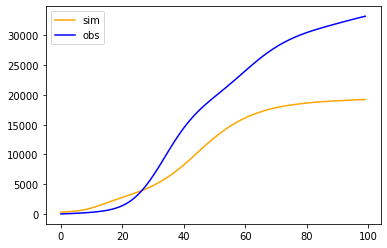

In [12]:
OpenCLRunner.update(repetitions=REPETITIONS)
OpenCLRunner.update(store_detailed_counts=STORE_DETAILED_COUNTS)

# Check the model returns the observations correctly
np.array_equal(obs0, OBSERVATIONS.loc[:len(sim0)-1,"Cases"])

# Print the fitness and plot the different disease counts
print(f"fitness: {fitness0}")
#print(pd.DataFrame({"sim":sim, "real_obs1":obs}))

fig, ax = plt.subplots(1,1)
x = range(len(sim0))
ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries0), label="sim", color="orange")
ax.plot(x, obs0, label="obs", color="blue")
ax.legend()

In [13]:
def plot_summaries(summaries, observations=None, plot_type="error_bars"):

    #fig, ax = plt.subplots(1, len(DiseaseStatus), sharey=True)
    fig, ax = plt.subplots(1, 1, figsize=(10,7))

    # Work out the number of repetitions and iterations
    iters, reps = _get_iters_and_reps(summaries)
    x = range(iters)
    total_not_susceptible = np.zeros(iters)  # Used to compare to observations

    for d, disease_status in enumerate(DiseaseStatus):

        # Calculate the mean and standard deviation
        mean, sd = OpenCLRunner.get_mean_total_counts(summaries, d, get_sd=True)

        # Don't plot susceptible or recovered as it hides everytihng else
        if disease_status==DiseaseStatus.Susceptible or disease_status==DiseaseStatus.Recovered:
            continue

        if plot_type == "error_bars":
            ax.errorbar(x, mean, sd, label=f"{disease_status}" )
        elif plot_type == "lines":
            for rep in range(reps):
                ax.plot(x, matrix[rep], label=f"{disease_status} {rep}",
                        color=plt.cm.get_cmap("hsv", len(DiseaseStatus))(d) )

    if observations is not None:
        # Plot the observations (cumulative infections)
        ax.plot(x, observations.loc[:len(x)-1, "Cases"],
                label=f"Observations (cumulative cases)", color="black", linestyle="dashed")
        # And the total new infections, for comparison
        ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries),
               label=f"Total not susceptible ", color="grey", linestyle="dashed")


    ax.legend()
    ax.set_title("Disease Status")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Number of cases")
    #ax.set_ylim(0, 5000)
    #ax.set_xlim(0,30)

def _get_iters_and_reps(summaries):
    reps = len(summaries)
    iters = len(summaries[0].total_counts[0])
    return (iters, reps)

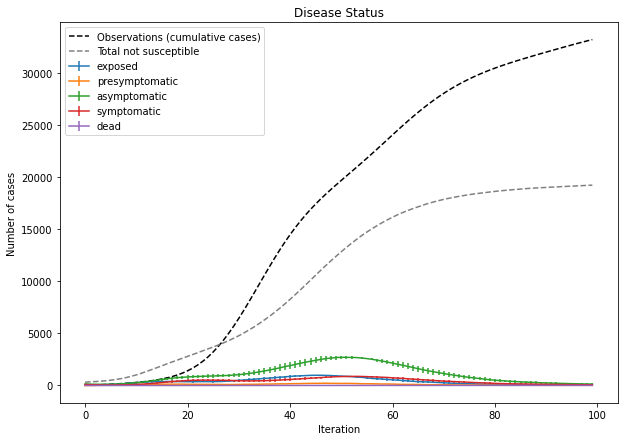

In [14]:
plot_summaries(summaries=summaries0, observations=OBSERVATIONS, plot_type="error_bars")

In [15]:
def plot_disease_status_by_age(summaries):

    #fig, ax = plt.subplots(1, len(DiseaseStatus), sharey=True)
    fig, ax = plt.subplots(int(len(DiseaseStatus)/2), int(len(DiseaseStatus)/2),
                           figsize=(15,11), tight_layout=True)
    iters, reps = _get_iters_and_reps(summaries)
    x = range(iters)
    age_thresholds = summaries[0].age_thresholds

    for d, disease_status in enumerate(DiseaseStatus):
        lower_age_bound = 0
        for age_idx in range(len(age_thresholds)):
            matrix = np.zeros(shape=(reps, iters))
            for rep in range(reps):
                #matrix[age_idx][rep][it] = summaries[rep].age_counts[str(disease_status)][age_idx][it]
                matrix[rep] = summaries[rep].age_counts[str(disease_status)][age_idx]
            mean = np.mean(matrix, axis=0)
            sd = np.std(matrix, axis=0)
            ax.flat[d].errorbar(x, mean, sd, label=f"{lower_age_bound} - {age_thresholds[age_idx]}" )
            lower_age_bound = age_thresholds[age_idx]

            ax.flat[d].legend()
            ax.flat[d].set_title(f"{str(disease_status)}")
            ax.flat[d].set_xlabel("Iteration")
            ax.flat[d].set_ylabel("Number of cases")
    #fig.set_title(f"Num {disease_status} people by age group")

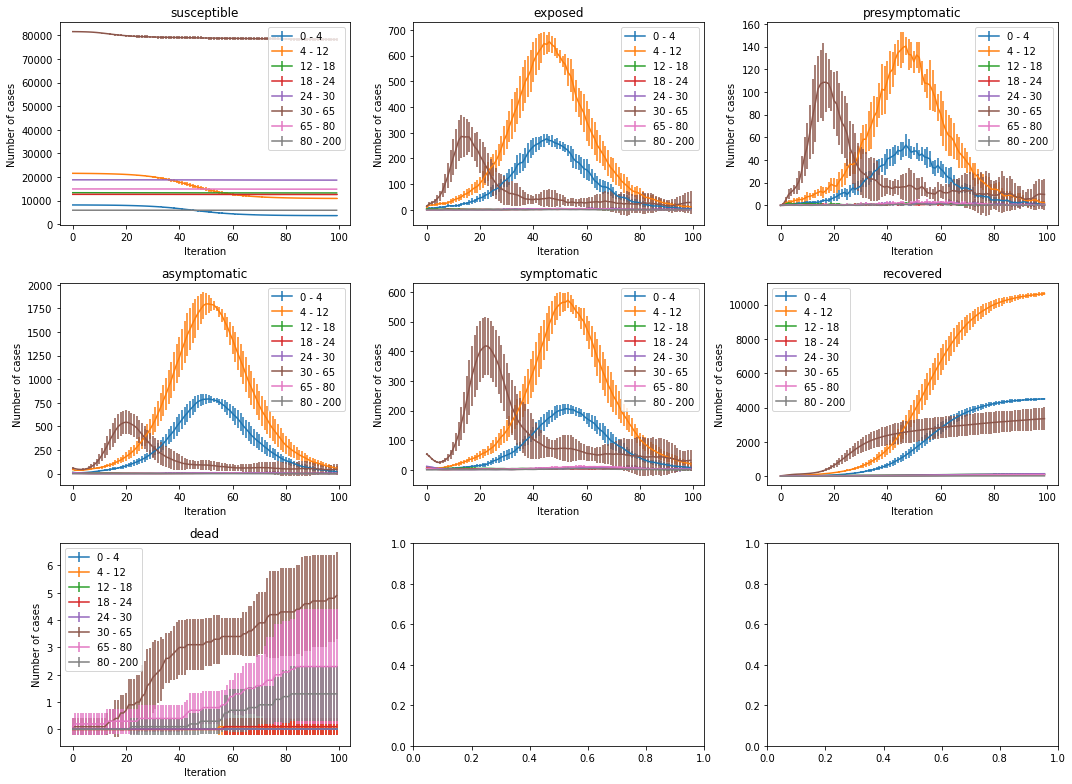

In [16]:
plot_disease_status_by_age(summaries0)

# ABC

In [17]:
import pyabc
from pygam import LinearGAM  # For graphing posteriors
from pyabc.transition.multivariatenormal import MultivariateNormalTransition  # For drawing from the posterior
import pickle

In [18]:
import itertools

In [19]:
def distance(sim,obs):
    fit = OpenCLRunner.fit_l2(sim["data"],obs["data"])
    print(fit)
    return fit

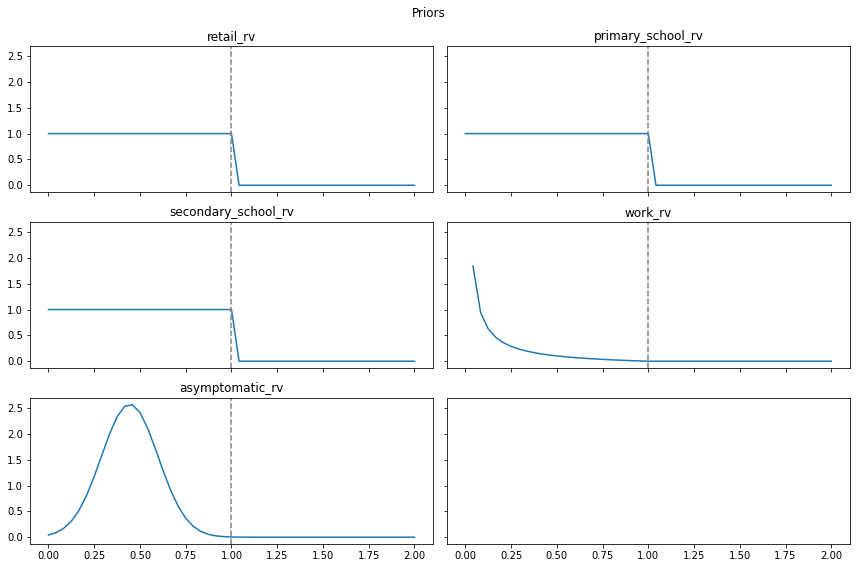

In [20]:
# The following should all be constant (overiding whatever is in the default.yml parameters file)
OpenCLRunner.set_constants( {"home": 1.0, "current_risk_beta": 0.03, "presymptomatic": 1.0, "symptomatic": 1.0 })
# FYI this is how to represent with discrete discributions and one possible value (hack that didn't work):
#home_rv, current_risk_beta_rv = ( pyabc.RV('rv_discrete', values=([1], [1.0])) for _ in range(2) )

# Now the random variables:
# School and retail are all uniform between 0-1
retail_rv, primary_school_rv, secondary_school_rv = ( pyabc.RV("uniform", 0, 1) for _ in range(3)  )
# Work needs some dampening because we know that workplaces are too big in the current implementation
work_rv = pyabc.RV("beta", 0.1, 2)

# Individual multipliers (see justification at the start of this notebook).
# Asymptomatic is normal such that the middle 95% is the range [0.138, 0.75]
asymptomatic_rv = pyabc.RV("norm", 0.444, 0.155)

fig, axes = plt.subplots(3, 2, figsize=(12,8), sharex=True, sharey=True)
x = np.linspace(0,2,49)  # (specified so that we have some whole numbers)
marker = itertools.cycle((',', '+', '.', 'o', '*'))
for i, variable in enumerate([retail_rv, primary_school_rv, secondary_school_rv, work_rv,
                              asymptomatic_rv]):
    var_name = [ k for k,v in locals().items() if v is variable][0]  # Hack to get the name of the variable
    ax = axes.flatten()[i]
    #ax.plot(x, pyabc.Distribution(param=variable).pdf({"param": x}), label = var_name, marker=next(marker), ms=3)
    ax.plot(x, pyabc.Distribution(param=variable).pdf({"param": x}))
    ax.set_title(var_name)
    ax.axvline(x=1.0, ls='--', color="grey", label="x=1")

#ax.legend()
fig.suptitle("Priors")
fig.tight_layout()

In [21]:
# Most priors can be passed straight to the distribution, except for 'asymptomatic' because it's normal
# so needs to be decorated to stay above 0
priors = pyabc.Distribution(
    #home = home_rv,
    retail = retail_rv,
    primary_school = primary_school_rv,
    secondary_school = secondary_school_rv,
    work = work_rv,
    #presymptomatic = presymptomatic_rv,
    #symptomatic = symptomatic_rv,
    asymptomatic = pyabc.LowerBoundDecorator(asymptomatic_rv, 0.0),
    #current_risk_beta = current_risk_beta_rv
)

In [22]:
abc = pyabc.ABCSMC(
    models=OpenCLRunner.run_aspics_with_params_abc, # Model (could be a list)
    parameter_priors=priors, # Priors (could be a list)
    distance_function=distance,  # Distance function
    sampler = pyabc.sampler.SingleCoreSampler()  # Single core because the model is parallelised
    #transition=transition,  # Define how to transition from one population to the next
)

In [23]:
y_observed = OBSERVATIONS.loc[:ITERATIONS-1, "Cases"].values

In [24]:
os.getcwd()

'/Users/fbenitez/PycharmProjects/uatk-aspics'

In [25]:
db_path = ("sqlite:///" + os.path.join(".", "abc-manchester.db"))

In [26]:
run_id = abc.new(db_path, {"data": y_observed})  # (ID only matters if multiple runs stored is same DB)

ABC.History INFO: Start <ABCSMC id=9, start_time=2022-08-16 19:46:38>


In [27]:
LOAD_PICKLES = True
history = None
fname = "abc-manchester.pkl"

if LOAD_PICKLES and os.path.isfile(fname):
    with open( fname, "rb" ) as f:
        history = pickle.load(f)
else:
    history = abc.run(max_nr_populations=2)
    # The history object only works if it has the associated database too ('abc-1.db')
    with open( fname, "wb" ) as f:
        pickle.dump( history, f)

ABC INFO: Calibration sample t = -1.


Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {804}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 805.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.23s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {16934}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 16935.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.24s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {90007}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 90008.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.31s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {89532}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 89533.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.37s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {43948}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 43949.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.36s/it]

.. finished, took 26.8s)


Ran Model with <Parameter 'retail': 0.9504511402798939, 'primary_school': 0.3841900154623258, 'secondary_school': 0.37325565136999517, 'work': 9.959481779512048e-17, 'asymptomatic': 0.68283745205777>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {4051}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 4052.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.70s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {81}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 82.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.62s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {25334}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 25335.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.55s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {55751}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 55752.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.47s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {65831}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 65832.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.50s/it]

.. finished, took 27.5s)


Ran Model with <Parameter 'retail': 0.3918915339193829, 'primary_school': 0.3636322940636265, 'secondary_school': 0.9195369450523754, 'work': 0.0006759488409333277, 'asymptomatic': 0.4030096861380373>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {49479}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 49480.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.39s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {85191}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 85192.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.46s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {45199}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 45200.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.37s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {17517}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 17518.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.32s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {14943}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 14944.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.30s/it]

.. finished, took 26.52s)


Ran Model with <Parameter 'retail': 0.29345276403433573, 'primary_school': 0.4205132850594272, 'secondary_school': 0.6211885579958497, 'work': 0.0013075566588958726, 'asymptomatic': 0.4779500476276065>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {77217}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 77218.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.59s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {63080}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 63081.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.40s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {92273}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 92274.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.40s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {29980}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 29981.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.36s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {44584}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 44585.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.39s/it]

.. finished, took 26.94s)


Ran Model with <Parameter 'retail': 0.5724283278668677, 'primary_school': 0.017946223426574814, 'secondary_school': 0.5012223493524965, 'work': 0.03359843046527286, 'asymptomatic': 0.2575816043162627>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {38457}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 38458.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.15s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {98057}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 98058.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.23s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {91122}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 91123.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.27s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {51278}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 51279.


Running models:  80%|████████  | 4/5 [00:20<00:05,  5.22s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {19911}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 19912.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.25s/it]

.. finished, took 26.25s)


Ran Model with <Parameter 'retail': 0.008436774129165214, 'primary_school': 0.24193888310371714, 'secondary_school': 0.8405939398080089, 'work': 5.499089968256891e-10, 'asymptomatic': 0.5269189556828437>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {41183}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 41184.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.20s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {98965}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 98966.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.29s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {10091}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 10092.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.19s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {5606}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 5607.


Running models:  80%|████████  | 4/5 [00:20<00:05,  5.25s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {25463}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 25464.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.20s/it]

.. finished, took 26.02s)


Ran Model with <Parameter 'retail': 0.020073548842928224, 'primary_school': 0.49393536374972247, 'secondary_school': 0.08956719715579686, 'work': 3.3239403834858557e-06, 'asymptomatic': 0.40481573581645164>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {33642}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 33643.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.40s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {74447}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 74448.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.30s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {43688}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 43689.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.29s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {91087}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 91088.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.24s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {22798}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 22799.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.25s/it]

.. finished, took 26.27s)


Ran Model with <Parameter 'retail': 0.4962190319894322, 'primary_school': 0.4191131118879853, 'secondary_school': 0.40542984281589645, 'work': 6.8302735932034e-09, 'asymptomatic': 0.5311857853724716>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {68693}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 68694.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.10s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {15463}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 15464.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.19s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {36527}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 36528.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.19s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {34396}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 34397.


Running models:  80%|████████  | 4/5 [00:20<00:05,  5.20s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {85964}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 85965.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.21s/it]

.. finished, took 26.05s)


Ran Model with <Parameter 'retail': 0.33411174663807375, 'primary_school': 0.8841372527816738, 'secondary_school': 0.4635948449168017, 'work': 0.014711750488043374, 'asymptomatic': 0.4524007156448729>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {58106}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 58107.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.10s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {23236}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 23237.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.14s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {38516}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 38517.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.09s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {78893}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 78894.


Running models:  80%|████████  | 4/5 [00:20<00:05,  5.19s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {64094}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 64095.


Running models: 100%|██████████| 5/5 [00:25<00:00,  5.15s/it]

.. finished, took 25.74s)


Ran Model with <Parameter 'retail': 0.49514446595324, 'primary_school': 0.31467654332802053, 'secondary_school': 0.5633339890570676, 'work': 5.807033652445735e-07, 'asymptomatic': 0.25151743285559613>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {59502}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 59503.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.22s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {1870}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 1871.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.30s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {72094}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 72095.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.22s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {2002}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 2003.


Running models:  80%|████████  | 4/5 [00:20<00:05,  5.18s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {65816}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 65817.


Running models: 100%|██████████| 5/5 [00:25<00:00,  5.19s/it]

.. finished, took 25.97s)


Ran Model with <Parameter 'retail': 0.5332906112051568, 'primary_school': 0.15067551944909352, 'secondary_school': 0.19196495448740403, 'work': 1.1378177198753848e-05, 'asymptomatic': 0.3132488129723175>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {28197}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 28198.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.17s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {4470}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 4471.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.13s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {86116}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 86117.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.13s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {40688}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 40689.


Running models:  80%|████████  | 4/5 [00:20<00:05,  5.09s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {90168}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 90169.


Running models: 100%|██████████| 5/5 [00:25<00:00,  5.14s/it]

.. finished, took 25.7s)


Ran Model with <Parameter 'retail': 0.44996713364653984, 'primary_school': 0.49161279411760817, 'secondary_school': 0.14585346955231582, 'work': 3.1734937028075057e-06, 'asymptomatic': 0.5081541793649679>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {78327}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 78328.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.10s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {63058}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 63059.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.12s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {52219}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 52220.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.18s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {71004}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 71005.


Running models:  80%|████████  | 4/5 [00:20<00:05,  5.12s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {89277}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 89278.


Running models: 100%|██████████| 5/5 [00:25<00:00,  5.15s/it]

.. finished, took 25.74s)


Ran Model with <Parameter 'retail': 0.7773019925576692, 'primary_school': 0.4810751892496431, 'secondary_school': 0.39647501968581766, 'work': 0.011168435204207688, 'asymptomatic': 0.42659538592260354>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {91439}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 91440.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.29s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {48309}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 48310.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.24s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {20217}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 20218.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.33s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {99848}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 99849.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.31s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {34622}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 34623.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.30s/it]

.. finished, took 26.48s)


Ran Model with <Parameter 'retail': 0.5130804810386521, 'primary_school': 0.4856570916051267, 'secondary_school': 0.5847164712037072, 'work': 0.08566714726255449, 'asymptomatic': 0.22132255590785807>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {53600}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 53601.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.57s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {2389}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 2390.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.32s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {54341}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 54342.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.19s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {19893}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 19894.


Running models:  80%|████████  | 4/5 [00:20<00:05,  5.20s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {48572}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 48573.


Running models: 100%|██████████| 5/5 [00:25<00:00,  5.19s/it]

.. finished, took 25.94s)


Ran Model with <Parameter 'retail': 0.921011665337143, 'primary_school': 0.302414283242051, 'secondary_school': 0.39929646029148713, 'work': 0.0022688526177555794, 'asymptomatic': 0.45066616873790055>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {63141}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 63142.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.32s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {20730}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 20731.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.29s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {8031}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 8032.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.18s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {32660}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 32661.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.28s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {79020}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 79021.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.23s/it]

.. finished, took 26.16s)


Ran Model with <Parameter 'retail': 0.4063930233910228, 'primary_school': 0.209468573169184, 'secondary_school': 0.08842108316292951, 'work': 0.03291244201878359, 'asymptomatic': 0.396482283212365>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {54448}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 54449.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.27s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {69103}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 69104.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.40s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {77924}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 77925.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.33s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {32120}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 32121.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.31s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {57653}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 57654.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.35s/it]

.. finished, took 26.76s)


Ran Model with <Parameter 'retail': 0.4265829899613849, 'primary_school': 0.37880190671042946, 'secondary_school': 0.46080087255740776, 'work': 0.02558221161073875, 'asymptomatic': 0.4953889187257257>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {36782}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 36783.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.08s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {46669}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 46670.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.24s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {7823}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 7824.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.29s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {87346}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 87347.


Running models:  80%|████████  | 4/5 [00:20<00:05,  5.22s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {13266}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 13267.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.24s/it]

.. finished, took 26.19s)


Ran Model with <Parameter 'retail': 0.9739833684250577, 'primary_school': 0.15140686991996066, 'secondary_school': 0.7021698092752645, 'work': 0.00011006321872562487, 'asymptomatic': 0.5291305323416465>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {82637}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 82638.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.33s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {53635}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 53636.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.17s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {85168}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 85169.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.31s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {7743}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 7744.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.34s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {45549}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 45550.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.25s/it]

.. finished, took 26.26s)


Ran Model with <Parameter 'retail': 0.43440194844757574, 'primary_school': 0.07536675692063222, 'secondary_school': 0.8708055407254791, 'work': 0.07747336229103109, 'asymptomatic': 0.29455223598875074>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {57606}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 57607.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.50s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {27994}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 27995.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.27s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {89099}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 89100.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.22s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {54034}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 54035.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.29s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {99233}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 99234.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.26s/it]

.. finished, took 26.31s)


Ran Model with <Parameter 'retail': 0.9281624947598539, 'primary_school': 0.5318565971623845, 'secondary_school': 0.804785013091186, 'work': 8.86242569892498e-08, 'asymptomatic': 0.5676922717147628>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {50956}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 50957.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.27s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {4615}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 4616.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.37s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {60819}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 60820.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.23s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {31869}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 31870.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.25s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {42941}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 42942.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.27s/it]

.. finished, took 26.38s)


Ran Model with <Parameter 'retail': 0.05153147304991135, 'primary_school': 0.6907039809661476, 'secondary_school': 0.5608797918931245, 'work': 4.867477431171704e-06, 'asymptomatic': 0.5895145650420078>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {84834}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 84835.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.00s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {32879}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 32880.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.20s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {2664}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 2665.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.18s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {241}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 242.


Running models:  80%|████████  | 4/5 [00:20<00:05,  5.15s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {44524}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 44525.


Running models: 100%|██████████| 5/5 [00:25<00:00,  5.19s/it]

.. finished, took 25.97s)


Ran Model with <Parameter 'retail': 0.3874385841150879, 'primary_school': 0.7792023155376085, 'secondary_school': 0.9039110055981693, 'work': 5.9402155492549925e-05, 'asymptomatic': 0.4221458184098832>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {30449}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 30450.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.17s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {75196}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 75197.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.29s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {85814}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 85815.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.40s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {33988}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 33989.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.27s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {17718}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 17719.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.28s/it]

.. finished, took 26.39s)


Ran Model with <Parameter 'retail': 0.330104314483452, 'primary_school': 0.15795900496471738, 'secondary_school': 0.9791723209660405, 'work': 0.0390897392175884, 'asymptomatic': 0.21489589914635002>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {70090}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 70091.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.31s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {36336}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 36337.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.15s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {59878}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 59879.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.31s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {63105}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 63106.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.34s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {99953}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 99954.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.30s/it]

.. finished, took 26.48s)


Ran Model with <Parameter 'retail': 0.5594633367361111, 'primary_school': 0.7928786468375785, 'secondary_school': 0.453437910796741, 'work': 0.00382635333851882, 'asymptomatic': 0.6357742234878868>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {13432}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 13433.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.41s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {37279}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 37280.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.22s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {29590}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 29591.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.16s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {83944}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 83945.


Running models:  80%|████████  | 4/5 [00:20<00:05,  5.05s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {97340}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 97341.


Running models: 100%|██████████| 5/5 [00:25<00:00,  5.10s/it]

.. finished, took 25.49s)


Ran Model with <Parameter 'retail': 0.3777310569099904, 'primary_school': 0.8510385458762418, 'secondary_school': 0.7370131331719456, 'work': 1.3263735859126921e-17, 'asymptomatic': 0.29554087338334756>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {31941}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 31942.


Running models:  20%|██        | 1/5 [00:04<00:19,  5.00s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {40891}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 40892.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.03s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {34635}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 34636.


Running models:  60%|██████    | 3/5 [00:14<00:09,  4.98s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {15792}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 15793.


Running models:  80%|████████  | 4/5 [00:19<00:04,  5.00s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {3762}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 3763.


Running models: 100%|██████████| 5/5 [00:24<00:00,  5.00s/it]

.. finished, took 25.0s)


Ran Model with <Parameter 'retail': 0.8244820939725532, 'primary_school': 0.2549058945307239, 'secondary_school': 0.2947103417556989, 'work': 0.07744495465876264, 'asymptomatic': 0.46690700834973786>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {26867}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 26868.


Running models:  20%|██        | 1/5 [00:04<00:19,  4.99s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {82268}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 82269.


Running models:  40%|████      | 2/5 [00:09<00:14,  4.98s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {18460}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 18461.


Running models:  60%|██████    | 3/5 [00:14<00:10,  5.00s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {34754}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 34755.


Running models:  80%|████████  | 4/5 [00:20<00:05,  5.02s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {92890}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 92891.


Running models: 100%|██████████| 5/5 [00:25<00:00,  5.03s/it]

.. finished, took 25.14s)


Ran Model with <Parameter 'retail': 0.6548065830081718, 'primary_school': 0.6889349650265001, 'secondary_school': 0.8179694386055131, 'work': 0.027185930733628464, 'asymptomatic': 0.5505984452199628>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {81044}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 81045.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.05s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {90034}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 90035.


Running models:  40%|████      | 2/5 [00:10<00:14,  5.00s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {55865}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 55866.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.05s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {94608}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 94609.


Running models:  80%|████████  | 4/5 [00:20<00:05,  5.21s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {34631}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 34632.


Running models: 100%|██████████| 5/5 [00:25<00:00,  5.16s/it]

.. finished, took 25.83s)


Ran Model with <Parameter 'retail': 0.7160321202201937, 'primary_school': 0.3907475627239567, 'secondary_school': 0.07945260031615586, 'work': 0.11950549093908856, 'asymptomatic': 0.4291743379237221>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {24103}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 24104.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.34s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {26097}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 26098.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.35s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {67474}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 67475.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.46s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {34684}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 34685.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.39s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {56310}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 56311.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.43s/it]

.. finished, took 27.17s)


Ran Model with <Parameter 'retail': 0.8121487844683417, 'primary_school': 0.8186158293090124, 'secondary_school': 0.5400815066703403, 'work': 0.05097235869229058, 'asymptomatic': 0.39573777580040725>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {71685}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 71686.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.33s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {12402}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 12403.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.35s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {90189}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 90190.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.31s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {74401}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 74402.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.33s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {46610}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 46611.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.37s/it]

.. finished, took 26.83s)


Ran Model with <Parameter 'retail': 0.8498936195683672, 'primary_school': 0.9138116778260701, 'secondary_school': 0.08201049589019416, 'work': 0.006120953428290298, 'asymptomatic': 0.3919082772264379>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {47862}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 47863.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.38s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {64520}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 64521.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.40s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {84015}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 84016.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.33s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {70022}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 70023.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.35s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {70694}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 70695.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.33s/it]

.. finished, took 26.66s)


Ran Model with <Parameter 'retail': 0.646793487935974, 'primary_school': 0.19770859643815597, 'secondary_school': 0.2008804805151042, 'work': 6.485457158335678e-10, 'asymptomatic': 0.4737668348467507>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {48438}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 48439.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.60s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {89503}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 89504.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.37s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {56395}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 56396.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.39s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {28944}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 28945.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.40s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {4237}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 4238.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.43s/it]

.. finished, took 27.17s)


Ran Model with <Parameter 'retail': 0.7926437325182661, 'primary_school': 0.22824918519286785, 'secondary_school': 0.0508968060606485, 'work': 3.385911980936514e-10, 'asymptomatic': 0.6178868834228786>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {90863}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 90864.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.58s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {49734}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 49735.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.59s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {56166}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 56167.


Running models:  60%|██████    | 3/5 [00:17<00:11,  5.71s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {7697}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 7698.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.54s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {37398}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 37399.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.51s/it]

.. finished, took 27.58s)


Ran Model with <Parameter 'retail': 0.41616351818298747, 'primary_school': 0.37675660141414, 'secondary_school': 0.9831405198664287, 'work': 0.01985267779317548, 'asymptomatic': 0.31005972196368825>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {94206}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 94207.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.19s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {47076}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 47077.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.37s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {82117}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 82118.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.38s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {44184}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 44185.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.39s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {80103}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 80104.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.38s/it]

.. finished, took 26.89s)


Ran Model with <Parameter 'retail': 0.3111901165680385, 'primary_school': 0.7944969046867997, 'secondary_school': 0.9854714175127881, 'work': 9.518372795886117e-06, 'asymptomatic': 0.2979321199618772>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {68319}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 68320.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.37s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {24178}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 24179.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.28s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {4358}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 4359.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.36s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {6917}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 6918.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.30s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {86917}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 86918.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.32s/it]

.. finished, took 26.6s)


Ran Model with <Parameter 'retail': 0.8157031436438372, 'primary_school': 0.7208374214389943, 'secondary_school': 0.026756611944967368, 'work': 8.371282612938479e-10, 'asymptomatic': 0.21529643191439146>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {70686}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 70687.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.16s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {13121}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 13122.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.09s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {46057}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 46058.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.19s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {90947}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 90948.


Running models:  80%|████████  | 4/5 [00:20<00:05,  5.23s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {30755}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 30756.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.22s/it]

.. finished, took 26.09s)


Ran Model with <Parameter 'retail': 0.43010387411110507, 'primary_school': 0.8810751947691348, 'secondary_school': 0.5990615591234315, 'work': 2.289415720721372e-05, 'asymptomatic': 0.5133887729217653>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {7737}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 7738.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.60s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {61657}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 61658.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.48s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {74418}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 74419.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.53s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {97801}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 97802.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.45s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {97274}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 97275.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.46s/it]

.. finished, took 27.32s)


Ran Model with <Parameter 'retail': 0.5673024314457896, 'primary_school': 0.32377728479929435, 'secondary_school': 0.69530500887459, 'work': 0.01967646433279557, 'asymptomatic': 0.5027062392208425>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {79226}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 79227.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.42s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {65763}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 65764.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.42s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {18735}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 18736.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.53s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {52299}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 52300.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.67s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {27073}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 27074.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.59s/it]

.. finished, took 27.97s)


Ran Model with <Parameter 'retail': 0.7145671074695381, 'primary_school': 0.9310899404981594, 'secondary_school': 0.3013502419373222, 'work': 0.000750134560651955, 'asymptomatic': 0.38240799675423826>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {96114}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 96115.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.70s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {32926}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 32927.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.61s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {90025}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 90026.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.60s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {45650}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 45651.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.57s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {49764}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 49765.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.57s/it]

.. finished, took 27.85s)


Ran Model with <Parameter 'retail': 0.02329593518549833, 'primary_school': 0.10026642338223113, 'secondary_school': 0.22187081246134088, 'work': 2.8718746476652933e-11, 'asymptomatic': 0.1704884803549216>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {6876}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 6877.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.67s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {30517}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 30518.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.62s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {24607}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 24608.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.61s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {80307}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 80308.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.62s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {11020}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 11021.


Running models: 100%|██████████| 5/5 [00:28<00:00,  5.66s/it]

.. finished, took 28.29s)


Ran Model with <Parameter 'retail': 0.44967217194576037, 'primary_school': 0.15191543778160577, 'secondary_school': 0.6108842823379408, 'work': 4.244184870354379e-13, 'asymptomatic': 0.5385279969227896>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {88702}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 88703.


Running models:  20%|██        | 1/5 [00:05<00:23,  5.85s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {69599}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 69600.


Running models:  40%|████      | 2/5 [00:11<00:17,  5.84s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {38117}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 38118.


Running models:  60%|██████    | 3/5 [00:17<00:11,  5.72s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {51703}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 51704.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.67s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {79968}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 79969.


Running models: 100%|██████████| 5/5 [00:28<00:00,  5.68s/it]

.. finished, took 28.41s)


Ran Model with <Parameter 'retail': 0.592804813348031, 'primary_school': 0.8633541275248406, 'secondary_school': 0.42329548794162086, 'work': 8.366234800000974e-17, 'asymptomatic': 0.42077299464877993>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {63911}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 63912.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.50s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {18639}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 18640.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.50s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {9425}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 9426.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.50s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {66944}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 66945.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.45s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {67090}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 67091.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.45s/it]

.. finished, took 27.24s)


Ran Model with <Parameter 'retail': 0.046151352312643334, 'primary_school': 0.7269499520740672, 'secondary_school': 0.67980793310301, 'work': 0.03730394765736163, 'asymptomatic': 0.5984068414250769>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {65715}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 65716.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.36s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {29357}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 29358.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.42s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {6165}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 6166.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.37s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {92124}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 92125.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.44s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {95959}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 95960.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.44s/it]

.. finished, took 27.19s)


Ran Model with <Parameter 'retail': 0.25106531985298697, 'primary_school': 0.8395870669850306, 'secondary_school': 0.4444128798974708, 'work': 0.009332828659704178, 'asymptomatic': 0.691059392748288>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {80138}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 80139.


Running models:  20%|██        | 1/5 [00:05<00:23,  5.80s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {47866}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 47867.


Running models:  40%|████      | 2/5 [00:11<00:17,  5.78s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {84671}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 84672.


Running models:  60%|██████    | 3/5 [00:17<00:11,  5.65s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {56802}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 56803.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.55s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {44317}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 44318.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.59s/it]

.. finished, took 27.94s)


Ran Model with <Parameter 'retail': 0.7310237007772703, 'primary_school': 0.011791007811877807, 'secondary_school': 0.9007817364478484, 'work': 2.0433152194973768e-12, 'asymptomatic': 0.44944380235116477>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {66907}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 66908.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.37s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {24624}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 24625.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.38s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {56278}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 56279.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.39s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {90808}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 90809.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.44s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {35703}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 35704.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.41s/it]

.. finished, took 27.06s)


Ran Model with <Parameter 'retail': 0.8077281413685848, 'primary_school': 0.22087851500897693, 'secondary_school': 0.48274059499638355, 'work': 1.9714344168876386e-06, 'asymptomatic': 0.7529391719856018>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {39226}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 39227.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.68s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {18564}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 18565.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.57s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {10945}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 10946.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.48s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {90259}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 90260.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.44s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {82963}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 82964.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.48s/it]

.. finished, took 27.4s)


Ran Model with <Parameter 'retail': 0.4508275460289669, 'primary_school': 0.6228275873597624, 'secondary_school': 0.26517604210577606, 'work': 0.0021588805581853067, 'asymptomatic': 0.45940314608301297>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {21413}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 21414.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.24s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {1464}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 1465.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.37s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {41068}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 41069.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.28s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {48761}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 48762.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.29s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {38039}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 38040.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.30s/it]

.. finished, took 26.52s)


Ran Model with <Parameter 'retail': 0.6940853212532827, 'primary_school': 0.7229021161682676, 'secondary_school': 0.8144390902239788, 'work': 0.27661353294050883, 'asymptomatic': 0.33243770089701435>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {54471}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 54472.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.39s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {54072}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 54073.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.37s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {92004}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 92005.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.39s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {61538}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 61539.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.34s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {99025}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 99026.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.38s/it]

.. finished, took 26.89s)


Ran Model with <Parameter 'retail': 0.02411811437415834, 'primary_school': 0.5660326187129008, 'secondary_school': 0.49147131018595835, 'work': 0.0035305104762406244, 'asymptomatic': 0.5642068685594606>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {98584}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 98585.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.21s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {15262}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 15263.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.31s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {95547}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 95548.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.38s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {56980}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 56981.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.37s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {11422}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 11423.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.34s/it]

.. finished, took 26.68s)


Ran Model with <Parameter 'retail': 0.4509341536911541, 'primary_school': 0.8380627381841841, 'secondary_school': 0.7998330551653798, 'work': 0.020391287855670924, 'asymptomatic': 0.23947232937967072>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {46470}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 46471.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.33s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {26717}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 26718.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.39s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {54197}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 54198.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.41s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {39973}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 39974.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.42s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {96071}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 96072.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.35s/it]

.. finished, took 26.77s)


Ran Model with <Parameter 'retail': 0.22323291036191872, 'primary_school': 0.9975222551545292, 'secondary_school': 0.4980409023929613, 'work': 1.208126742499151e-07, 'asymptomatic': 0.5726964102085628>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {59586}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 59587.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.21s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {69674}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 69675.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.18s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {17325}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 17326.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.15s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {75603}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 75604.


Running models:  80%|████████  | 4/5 [00:20<00:05,  5.14s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {95357}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 95358.


Running models: 100%|██████████| 5/5 [00:25<00:00,  5.15s/it]

.. finished, took 25.77s)


Ran Model with <Parameter 'retail': 0.7679204324965757, 'primary_school': 0.05744561186134711, 'secondary_school': 0.13744577225859944, 'work': 1.2404268981527946e-11, 'asymptomatic': 0.4256268414650585>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {51901}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 51902.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.36s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {19669}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 19670.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.28s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {48177}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 48178.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.29s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {67809}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 67810.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.26s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {97115}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 97116.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.26s/it]

.. finished, took 26.32s)


Ran Model with <Parameter 'retail': 0.2202668306046227, 'primary_school': 0.07907790810960469, 'secondary_school': 0.8026765455100691, 'work': 0.00018454526561892374, 'asymptomatic': 0.4527770138403876>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {81281}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 81282.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.28s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {73803}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 73804.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.35s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {72945}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 72946.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.34s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {74676}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 74677.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.37s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {96157}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 96158.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.38s/it]

.. finished, took 26.92s)


Ran Model with <Parameter 'retail': 0.7200627269929417, 'primary_school': 0.04408592416510526, 'secondary_school': 0.8560958109369995, 'work': 2.3972338159389353e-08, 'asymptomatic': 0.6737032184754899>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {59043}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 59044.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.46s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {31457}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 31458.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.32s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {26454}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 26455.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.34s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {3584}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 3585.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.28s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {37430}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 37431.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.28s/it]

.. finished, took 26.41s)


Ran Model with <Parameter 'retail': 0.5370553944074973, 'primary_school': 0.06652024368268261, 'secondary_school': 0.6262208004880442, 'work': 2.5574549024698965e-12, 'asymptomatic': 0.693466606523733>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {76807}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 76808.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.25s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {11945}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 11946.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.31s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {91520}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 91521.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.28s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {49854}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 49855.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.30s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {4592}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 4593.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.26s/it]

.. finished, took 26.33s)


Ran Model with <Parameter 'retail': 0.13979505172738727, 'primary_school': 0.7698335458818383, 'secondary_school': 0.560778803702445, 'work': 5.068234967310987e-05, 'asymptomatic': 0.3335572128573733>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {82972}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 82973.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.42s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {69755}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 69756.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.42s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {61217}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 61218.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.37s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {59886}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 59887.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.36s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {95097}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 95098.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.34s/it]

.. finished, took 26.73s)


Ran Model with <Parameter 'retail': 0.12918137909653027, 'primary_school': 0.05741633602475005, 'secondary_school': 0.09523512812666257, 'work': 0.0030588939296295075, 'asymptomatic': 0.6239520941470106>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {30537}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 30538.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.32s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {75829}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 75830.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.23s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {95265}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 95266.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.28s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {82143}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 82144.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.25s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {3465}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 3466.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.25s/it]

.. finished, took 26.25s)


Ran Model with <Parameter 'retail': 0.15747726505626658, 'primary_school': 0.9193409465916951, 'secondary_school': 0.3184574835128531, 'work': 1.0592115319513657e-09, 'asymptomatic': 0.4553818003293313>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {66886}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 66887.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.11s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {23938}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 23939.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.38s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {86260}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 86261.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.39s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {62151}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 62152.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.36s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {54876}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 54877.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.32s/it]

.. finished, took 26.59s)


Ran Model with <Parameter 'retail': 0.477196560023855, 'primary_school': 0.5613242347306191, 'secondary_school': 0.29135040146048563, 'work': 6.601154275903166e-05, 'asymptomatic': 0.647286620546874>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {2427}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 2428.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.28s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {35827}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 35828.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.33s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {89752}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 89753.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.31s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {56640}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 56641.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.30s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {1326}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 1327.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.30s/it]

.. finished, took 26.52s)


Ran Model with <Parameter 'retail': 0.1530493183882109, 'primary_school': 0.22049690288974222, 'secondary_school': 0.7942741114064144, 'work': 0.055827738691011965, 'asymptomatic': 0.2195919183052518>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {46072}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 46073.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.25s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {32110}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 32111.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.27s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {6792}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 6793.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.35s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {6147}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 6148.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.24s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {43750}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 43751.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.24s/it]

.. finished, took 26.21s)


Ran Model with <Parameter 'retail': 0.3484802638597978, 'primary_school': 0.8835914232902622, 'secondary_school': 0.35977891674259954, 'work': 9.572864419554531e-05, 'asymptomatic': 0.5827548453257033>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {73844}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 73845.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.37s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {13536}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 13537.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.40s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {57258}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 57259.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.35s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {24953}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 24954.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.36s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {40156}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 40157.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.38s/it]

.. finished, took 26.91s)


Ran Model with <Parameter 'retail': 0.7430558169580455, 'primary_school': 0.6105049694771193, 'secondary_school': 0.3730909496024467, 'work': 4.5438416525661963e-10, 'asymptomatic': 0.34972313574416647>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {63561}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 63562.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.10s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {23278}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 23279.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.21s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {39822}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 39823.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.22s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {61479}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 61480.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.35s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {14523}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 14524.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.28s/it]

.. finished, took 26.4s)


Ran Model with <Parameter 'retail': 0.6735302322123032, 'primary_school': 0.9790677287675955, 'secondary_school': 0.808263429023322, 'work': 0.011661838717236974, 'asymptomatic': 0.4817820168238368>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {98290}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 98291.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.41s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {17369}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 17370.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.43s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {3546}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 3547.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.38s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {83444}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 83445.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.26s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {87376}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 87377.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.29s/it]

.. finished, took 26.43s)


Ran Model with <Parameter 'retail': 0.991383905214243, 'primary_school': 0.4480210145614014, 'secondary_school': 0.1801304603386812, 'work': 0.0020306989787616746, 'asymptomatic': 0.30054931561636566>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {58039}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 58040.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.12s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {66130}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 66131.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.17s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {98869}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 98870.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.19s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {25147}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 25148.


Running models:  80%|████████  | 4/5 [00:20<00:05,  5.11s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {88281}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 88282.


Running models: 100%|██████████| 5/5 [00:25<00:00,  5.14s/it]

.. finished, took 25.68s)


Ran Model with <Parameter 'retail': 0.7337235881186898, 'primary_school': 0.7617022240381576, 'secondary_school': 0.733319777917154, 'work': 4.466957751407857e-07, 'asymptomatic': 0.26815024789858666>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {8372}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 8373.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.35s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {73993}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 73994.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.36s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {59430}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 59431.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.21s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {86526}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 86527.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.23s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {61187}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 61188.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.20s/it]

.. finished, took 26.01s)


Ran Model with <Parameter 'retail': 0.37625145463588283, 'primary_school': 0.7802925088109219, 'secondary_school': 0.24337002045177636, 'work': 1.519995141825607e-15, 'asymptomatic': 0.6619372680087567>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {26982}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 26983.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.48s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {91056}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 91057.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.34s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {16523}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 16524.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.39s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {78657}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 78658.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.32s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {3037}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 3038.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.35s/it]

.. finished, took 26.75s)


Ran Model with <Parameter 'retail': 0.3463944129238772, 'primary_school': 0.9501096710889065, 'secondary_school': 0.5449095784202069, 'work': 0.0009340782182018868, 'asymptomatic': 0.24229549630484773>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {19296}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 19297.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.23s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {62604}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 62605.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.33s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {87070}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 87071.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.35s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {96216}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 96217.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.41s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {30421}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 30422.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.35s/it]

.. finished, took 26.76s)


Ran Model with <Parameter 'retail': 0.35384235622003346, 'primary_school': 0.93060172441693, 'secondary_school': 0.2163320205788024, 'work': 0.0053406798454341525, 'asymptomatic': 0.4913173271281669>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {41932}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 41933.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.53s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {13368}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 13369.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.45s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {45386}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 45387.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.36s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {48151}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 48152.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.30s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {64450}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 64451.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.32s/it]

.. finished, took 26.62s)


Ran Model with <Parameter 'retail': 0.9054473322996883, 'primary_school': 0.8608936143589712, 'secondary_school': 0.3697083419344809, 'work': 0.025381400864508075, 'asymptomatic': 0.5307725705935638>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {89363}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 89364.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.33s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {39516}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 39517.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.33s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {91490}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 91491.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.43s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {53390}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 53391.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.49s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {48143}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 48144.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.45s/it]

.. finished, took 27.26s)


Ran Model with <Parameter 'retail': 0.17551520691450428, 'primary_school': 0.9368472643054296, 'secondary_school': 0.2159572877595214, 'work': 0.2714434272487185, 'asymptomatic': 0.3978751202088942>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {43158}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 43159.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.30s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {41776}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 41777.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.25s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {58727}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 58728.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.16s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {78138}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 78139.


Running models:  80%|████████  | 4/5 [00:20<00:05,  5.18s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {6670}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 6671.


Running models: 100%|██████████| 5/5 [00:25<00:00,  5.16s/it]

.. finished, took 25.82s)


Ran Model with <Parameter 'retail': 0.69462292210249, 'primary_school': 0.6709703380803125, 'secondary_school': 0.4556698579646017, 'work': 0.009211273168673196, 'asymptomatic': 0.14553023691180178>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {45188}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 45189.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.25s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {78803}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 78804.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.35s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {51193}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 51194.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.35s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {92037}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 92038.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.31s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {3126}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 3127.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.28s/it]

.. finished, took 26.41s)


Ran Model with <Parameter 'retail': 0.018732521038261618, 'primary_school': 0.8270724871048063, 'secondary_school': 0.8057909338266417, 'work': 1.560253085183398e-07, 'asymptomatic': 0.549568455282359>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {85128}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 85129.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.38s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {16070}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 16071.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.30s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {38271}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 38272.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.22s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {12553}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 12554.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.24s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {36734}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 36735.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.25s/it]

.. finished, took 26.27s)


Ran Model with <Parameter 'retail': 0.28336851454509193, 'primary_school': 0.5406930784645002, 'secondary_school': 0.006524493311259594, 'work': 3.793240319322851e-12, 'asymptomatic': 0.26317356263181785>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {26892}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 26893.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.45s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {45557}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 45558.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.51s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {31719}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 31720.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.51s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {34329}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 34330.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.48s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {19244}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 19245.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.49s/it]

.. finished, took 27.45s)


Ran Model with <Parameter 'retail': 0.09707671625726289, 'primary_school': 0.09046355868232347, 'secondary_school': 0.6981121216337646, 'work': 0.008121216558057526, 'asymptomatic': 0.2534644937085645>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {28482}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 28483.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.31s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {25019}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 25020.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.35s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {57113}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 57114.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.38s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {98357}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 98358.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.35s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {76783}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 76784.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.36s/it]

.. finished, took 26.82s)


Ran Model with <Parameter 'retail': 0.05026263167035072, 'primary_school': 0.4913232235704408, 'secondary_school': 0.5840499095299865, 'work': 3.203880711422919e-11, 'asymptomatic': 0.2793632496642686>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {35941}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 35942.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.44s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {32455}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 32456.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.49s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {2901}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 2902.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.48s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {8065}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 8066.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.43s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {17556}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 17557.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.46s/it]

.. finished, took 27.31s)


Ran Model with <Parameter 'retail': 0.8826058075313468, 'primary_school': 0.19792053962511424, 'secondary_school': 0.05951980200884821, 'work': 0.022883880694415677, 'asymptomatic': 0.24916127670259192>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {94840}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 94841.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.32s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {86046}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 86047.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.35s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {57745}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 57746.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.29s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {53092}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 53093.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.37s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {3587}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 3588.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.36s/it]

.. finished, took 26.82s)


Ran Model with <Parameter 'retail': 0.45713758048671504, 'primary_school': 0.2929227189125436, 'secondary_school': 0.5901926880667056, 'work': 0.00018170706980502613, 'asymptomatic': 0.5503430526243511>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {27267}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 27268.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.49s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {86103}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 86104.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.34s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {33370}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 33371.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.37s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {9143}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 9144.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.42s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {86271}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 86272.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.37s/it]

.. finished, took 26.85s)


Ran Model with <Parameter 'retail': 0.16498825512156, 'primary_school': 0.03714773005653749, 'secondary_school': 0.23114250459459162, 'work': 5.645930444264568e-09, 'asymptomatic': 0.25049103878163637>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {64307}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 64308.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.40s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {86988}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 86989.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.39s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {79023}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 79024.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.41s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {48665}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 48666.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.26s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {66745}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 66746.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.29s/it]

.. finished, took 26.45s)


Ran Model with <Parameter 'retail': 0.4905992484723103, 'primary_school': 0.2658078846304953, 'secondary_school': 0.7239408868118317, 'work': 4.461567881694633e-08, 'asymptomatic': 0.14465511267354558>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {16606}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 16607.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.21s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {85608}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 85609.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.30s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {99520}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 99521.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.38s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {6896}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 6897.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.43s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {34760}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 34761.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.42s/it]

.. finished, took 27.11s)


Ran Model with <Parameter 'retail': 0.959194396633656, 'primary_school': 0.64697806406661, 'secondary_school': 0.1865828653269993, 'work': 9.96010439968879e-13, 'asymptomatic': 0.44778912769859974>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {43474}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 43475.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.55s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {2360}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 2361.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.41s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {98730}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 98731.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.37s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {16335}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 16336.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.37s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {32657}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 32658.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.39s/it]

.. finished, took 26.94s)


Ran Model with <Parameter 'retail': 0.8975467852048519, 'primary_school': 0.4208368450311414, 'secondary_school': 0.2566223250234494, 'work': 2.6594002736470555e-12, 'asymptomatic': 0.7856464907801444>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {47857}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 47858.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.35s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {22954}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 22955.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.37s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {17504}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 17505.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.41s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {92624}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 92625.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.30s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {7901}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 7902.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.30s/it]

.. finished, took 26.51s)


Ran Model with <Parameter 'retail': 0.0670283539744787, 'primary_school': 0.9767159221819572, 'secondary_school': 0.8843712668354706, 'work': 0.0009413279531462081, 'asymptomatic': 0.47090957161744273>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {43731}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 43732.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.19s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {2910}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 2911.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.30s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {77824}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 77825.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.31s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {41428}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 41429.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.34s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {92490}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 92491.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.32s/it]

.. finished, took 26.58s)


Ran Model with <Parameter 'retail': 0.4819183211767465, 'primary_school': 0.43599871868712103, 'secondary_school': 0.541326763021016, 'work': 0.0009437941994978508, 'asymptomatic': 0.5571833130849568>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {3971}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 3972.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.27s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {57752}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 57753.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.25s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {1098}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 1099.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.39s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {71472}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 71473.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.38s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {81856}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 81857.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.40s/it]

.. finished, took 26.99s)


Ran Model with <Parameter 'retail': 0.7896383289258762, 'primary_school': 0.37659918737803133, 'secondary_school': 0.5841618676767271, 'work': 0.0011777451493389004, 'asymptomatic': 0.40239755384631437>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {91792}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 91793.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.24s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {3513}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 3514.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.30s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {85299}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 85300.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.34s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {99780}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 99781.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.40s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {26213}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 26214.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.39s/it]

.. finished, took 26.95s)


Ran Model with <Parameter 'retail': 0.3508418890545628, 'primary_school': 0.4594136739650506, 'secondary_school': 0.39575971059368487, 'work': 0.13486589390147694, 'asymptomatic': 0.31372498979757946>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {1256}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 1257.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.25s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {25356}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 25357.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.32s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {83660}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 83661.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.26s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {43390}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 43391.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.31s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {63217}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 63218.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.29s/it]

.. finished, took 26.44s)


Ran Model with <Parameter 'retail': 0.08317355174431995, 'primary_school': 0.8762914955741568, 'secondary_school': 0.4486947047302776, 'work': 0.1861894858903324, 'asymptomatic': 0.4199554855591008>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {58735}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 58736.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.56s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {88190}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 88191.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.49s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {4721}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 4722.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.50s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {22076}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 22077.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.43s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {16917}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 16918.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.43s/it]

.. finished, took 27.15s)


Ran Model with <Parameter 'retail': 0.8224188653730842, 'primary_school': 0.036646123541492104, 'secondary_school': 0.34697741429263695, 'work': 0.174733753297644, 'asymptomatic': 0.3216207455701598>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {76646}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 76647.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.18s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {16416}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 16417.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.29s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {62841}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 62842.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.27s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {53890}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 53891.


Running models:  80%|████████  | 4/5 [00:20<00:05,  5.16s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {21133}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 21134.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.21s/it]

.. finished, took 26.06s)


Ran Model with <Parameter 'retail': 0.6037487465341954, 'primary_school': 0.5966212471529215, 'secondary_school': 0.13754041222641789, 'work': 4.8120458344569234e-15, 'asymptomatic': 0.7174005548200417>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {36480}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 36481.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.34s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {80467}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 80468.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.34s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {20136}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 20137.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.30s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {75764}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 75765.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.27s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {40585}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 40586.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.29s/it]

.. finished, took 26.43s)


Ran Model with <Parameter 'retail': 0.49547338668717555, 'primary_school': 0.0266809395810359, 'secondary_school': 0.026835445468998076, 'work': 0.001571123828288483, 'asymptomatic': 0.17043063376303424>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {25841}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 25842.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.34s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {33328}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 33329.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.32s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {27030}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 27031.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.28s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {86542}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 86543.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.30s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {71053}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 71054.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.32s/it]

.. finished, took 26.6s)


Ran Model with <Parameter 'retail': 0.3930307673582122, 'primary_school': 0.9898238133581868, 'secondary_school': 0.993625980727753, 'work': 0.0020320097359778316, 'asymptomatic': 0.652138968846435>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {22568}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 22569.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.36s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {64324}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 64325.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.46s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {46569}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 46570.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.41s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {66591}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 66592.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.40s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {99030}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 99031.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.36s/it]

.. finished, took 26.8s)


Ran Model with <Parameter 'retail': 0.9114041049065954, 'primary_school': 0.41187253034506655, 'secondary_school': 0.6995309217663805, 'work': 5.094267420381819e-14, 'asymptomatic': 0.4973057323812941>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {25432}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 25433.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.34s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {48716}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 48717.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.35s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {30998}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 30999.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.37s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {12595}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 12596.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.33s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {35478}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 35479.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.32s/it]

.. finished, took 26.61s)


Ran Model with <Parameter 'retail': 0.8637603148115811, 'primary_school': 0.2890287142103318, 'secondary_school': 0.337643570094303, 'work': 1.0110357550493459e-14, 'asymptomatic': 0.4843861389284508>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {48628}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 48629.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.49s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {85748}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 85749.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.37s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {93197}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 93198.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.32s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {21650}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 21651.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.29s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {17509}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 17510.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.34s/it]

.. finished, took 26.68s)


Ran Model with <Parameter 'retail': 0.06522001742602546, 'primary_school': 0.28074612382683406, 'secondary_school': 0.6533389130020367, 'work': 0.015284110570185585, 'asymptomatic': 0.5967679618782474>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {76585}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 76586.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.36s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {24723}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 24724.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.43s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {37977}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 37978.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.44s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {30966}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 30967.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.42s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {80873}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 80874.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.45s/it]

.. finished, took 27.23s)


Ran Model with <Parameter 'retail': 0.39973081639042185, 'primary_school': 0.037099686580517655, 'secondary_school': 0.057624831583219516, 'work': 0.055083863449648184, 'asymptomatic': 0.6558495742970758>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {84772}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 84773.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.29s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {56662}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 56663.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.33s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {84398}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 84399.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.36s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {17884}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 17885.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.35s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {76982}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 76983.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.34s/it]

.. finished, took 26.71s)


Ran Model with <Parameter 'retail': 0.29148889351730733, 'primary_school': 0.18798466055987206, 'secondary_school': 0.6581336233258042, 'work': 0.0006302317557206854, 'asymptomatic': 0.6546263018737357>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {40286}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 40287.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.48s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {15670}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 15671.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.26s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {46245}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 46246.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.28s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {61596}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 61597.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.34s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {33542}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 33543.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.35s/it]

.. finished, took 26.78s)


Ran Model with <Parameter 'retail': 0.8214787413924711, 'primary_school': 0.037710586079420017, 'secondary_school': 0.9034525252483575, 'work': 0.03339853877874203, 'asymptomatic': 0.6284555516725719>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {40688}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 40689.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.27s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {56986}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 56987.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.23s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {26446}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 26447.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.21s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {86264}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 86265.


Running models:  80%|████████  | 4/5 [00:20<00:05,  5.22s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {92895}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 92896.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.23s/it]

.. finished, took 26.18s)


Ran Model with <Parameter 'retail': 0.6089213957664124, 'primary_school': 0.7107584328810204, 'secondary_school': 0.08080045304960204, 'work': 5.983157027939823e-06, 'asymptomatic': 0.4030725850859503>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {70610}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 70611.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.25s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {47143}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 47144.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.19s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {98238}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 98239.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.20s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {29769}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 29770.


Running models:  80%|████████  | 4/5 [00:20<00:05,  5.18s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {38209}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 38210.


Running models: 100%|██████████| 5/5 [00:25<00:00,  5.19s/it]

.. finished, took 25.94s)


Ran Model with <Parameter 'retail': 0.14184257092090302, 'primary_school': 0.5283975028546507, 'secondary_school': 0.22911798526263627, 'work': 8.65661925829047e-09, 'asymptomatic': 0.2414528985144998>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {49046}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 49047.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.17s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {16706}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 16707.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.16s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {4137}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 4138.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.16s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {30868}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 30869.


Running models:  80%|████████  | 4/5 [00:20<00:05,  5.13s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {7488}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 7489.


Running models: 100%|██████████| 5/5 [00:25<00:00,  5.13s/it]

.. finished, took 25.64s)


Ran Model with <Parameter 'retail': 0.9811810800199415, 'primary_school': 0.6601478105336905, 'secondary_school': 0.2258603691554414, 'work': 6.998398990002506e-07, 'asymptomatic': 0.1194421960846827>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {64685}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 64686.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.39s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {34894}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 34895.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.37s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {79790}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 79791.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.37s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {62597}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 62598.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.42s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {67655}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 67656.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.40s/it]

.. finished, took 27.0s)


Ran Model with <Parameter 'retail': 0.8489093734902698, 'primary_school': 0.2329378605623823, 'secondary_school': 0.4638296304509403, 'work': 2.6711243708538628e-17, 'asymptomatic': 0.4906542036694781>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {54974}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 54975.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.49s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {91676}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 91677.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.39s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {21539}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 21540.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.42s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {95602}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 95603.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.38s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {22590}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 22591.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.36s/it]

.. finished, took 26.82s)


Ran Model with <Parameter 'retail': 0.36901369089992286, 'primary_school': 0.17672711478414216, 'secondary_school': 0.24183805742269393, 'work': 0.455902583368691, 'asymptomatic': 0.3441773747123329>
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {17248}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 17249.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.34s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {39766}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 39767.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.33s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {88508}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 88509.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.31s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {42970}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 42971.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.27s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {21057}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 21058.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.31s/it]

.. finished, took 26.55s)



ABC INFO: t: 0, eps: 1.65015598e+05.


Ran Model with <Parameter 'retail': 0.5409876902335655, 'primary_school': 0.3148067067398024, 'secondary_school': 0.7095861753537445, 'work': 0.0541654205867746, 'asymptomatic': 0.2028446564082175>
121410.66248958532
205558.56783749003
199475.74717995166
98358.19710039422
194508.85132569162
133395.50483415846
161599.22786065532
195806.36710219612
180093.5733839495
47080.70401767586
122420.7558821624
130604.8854989736
201735.08456626974
93231.84941982004
67296.13047241274
180493.73751064052
85118.26372547787
92704.40972078944
236663.36106740308
218885.0935631753
226525.7366300792
100461.13560835355
184930.28950509976
216905.33141755644
79176.19935510925
234260.4861547931
121110.28847806448
181075.63629721146
149118.00640392158
51785.316934049944
66978.45378179464
206655.14729597227
223774.0963621125
139823.4910508245
214604.11342031637
195904.62710686543
145321.68902665563
17044.332248580467
56884.329426301585
168431.96866367143
240690.3932450151
203801.07933737742
98409.21372696765
128

Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {67012}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 67013.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.34s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {21753}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 21754.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.47s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {28121}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 28122.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.47s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {97676}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 97677.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.43s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {95634}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 95635.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.42s/it]

.. finished, took 27.1s)


Ran Model with <Parameter 'retail': 0.1482875429942062, 'primary_school': 0.14695887355853576, 'secondary_school': 0.20281554465313567, 'work': 2.6241722611045636e-07, 'asymptomatic': 0.2680374887513619>
49149.678245538904
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {64918}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 64919.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.38s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {50108}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 50109.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.40s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {12199}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 12200.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.37s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {8449}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 8450.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.33s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {33635}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 33636.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.35s/it]

.. finished, took 26.77s)


Ran Model with <Parameter 'retail': 0.22466725242365804, 'primary_school': 0.8301958503655213, 'secondary_school': 0.055639778711246035, 'work': 0.009127565575046667, 'asymptomatic': 0.28259639773949863>
132070.52554404407
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {5990}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 5991.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.40s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {68938}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 68939.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.26s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {34530}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 34531.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.27s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {48380}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 48381.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.31s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {96107}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 96108.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.31s/it]

.. finished, took 26.56s)


Ran Model with <Parameter 'retail': 0.02410488405683575, 'primary_school': 0.7833585121792985, 'secondary_school': 0.8742136602902092, 'work': 0.08668545032452633, 'asymptomatic': 0.47137049429718375>
293371.86394765263
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {38337}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 38338.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.30s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {77594}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 77595.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.37s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {12627}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 12628.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.34s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {99389}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 99390.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.32s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {4879}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 4880.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.33s/it]

.. finished, took 26.65s)


Ran Model with <Parameter 'retail': 0.7552358403393368, 'primary_school': 0.8467089077458331, 'secondary_school': 0.08741948973120017, 'work': 0.00887690655658381, 'asymptomatic': 0.4225070938129837>
144081.20315002927
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {84173}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 84174.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.35s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {63005}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 63006.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.25s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {86111}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 86112.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.27s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {26648}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 26649.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.32s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {46683}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 46684.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.31s/it]

.. finished, took 26.57s)


Ran Model with <Parameter 'retail': 0.39361835192455896, 'primary_school': 0.7752558718283639, 'secondary_school': 0.36361267243359374, 'work': 1.7173563692879028e-06, 'asymptomatic': 0.7004088723723079>
175640.45846558246
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {10017}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 10018.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.41s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {47752}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 47753.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.40s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {81484}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 81485.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.44s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {21763}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 21764.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.43s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {57350}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 57351.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.42s/it]

.. finished, took 27.09s)


Ran Model with <Parameter 'retail': 0.8457881701040665, 'primary_school': 0.5368590217590316, 'secondary_school': 0.5160857542806145, 'work': 0.06781795609633796, 'asymptomatic': 0.5636364810402117>
164060.4215942407
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {11310}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 11311.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.61s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {37037}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 37038.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.54s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {35689}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 35690.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.49s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {80092}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 80093.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.40s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {98422}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 98423.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.46s/it]

.. finished, took 27.31s)


Ran Model with <Parameter 'retail': 0.2262912510820304, 'primary_school': 0.6373728083386988, 'secondary_school': 0.05303354755001177, 'work': 0.08533637584157709, 'asymptomatic': 0.4094227725415156>
133548.96853004894
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {92269}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 92270.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.40s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {6162}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 6163.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.32s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {72658}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 72659.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.29s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {45537}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 45538.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.31s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {14446}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 14447.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.32s/it]

.. finished, took 26.62s)


Ran Model with <Parameter 'retail': 0.47206551937114116, 'primary_school': 0.7942044567443795, 'secondary_school': 0.880166134927231, 'work': 3.2569086605635826e-07, 'asymptomatic': 0.7373245382315434>
233851.70743451925
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {12335}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 12336.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.50s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {35906}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 35907.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.40s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {99494}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 99495.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.46s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {41785}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 41786.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.46s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {53643}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 53644.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.45s/it]

.. finished, took 27.27s)


Ran Model with <Parameter 'retail': 0.8441364398455137, 'primary_school': 0.21478334246155273, 'secondary_school': 0.7910951771220809, 'work': 0.009362444950792286, 'asymptomatic': 0.23377614182934608>
59287.1720502842
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {65495}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 65496.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.20s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {79966}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 79967.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.22s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {77001}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 77002.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.30s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {39194}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 39195.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.29s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {60186}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 60187.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.27s/it]

.. finished, took 26.37s)


Ran Model with <Parameter 'retail': 0.7046681535493504, 'primary_school': 0.48286268441342917, 'secondary_school': 0.36113460330588865, 'work': 0.10330980917721345, 'asymptomatic': 0.782500074661852>
137014.44034188514
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {49648}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 49649.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.40s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {5181}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 5182.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.34s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {78871}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 78872.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.30s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {91884}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 91885.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.40s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {57847}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 57848.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.35s/it]

.. finished, took 26.77s)


Ran Model with <Parameter 'retail': 0.06877928939145017, 'primary_school': 0.4635545827501696, 'secondary_school': 0.09783539237448435, 'work': 0.17075539921356303, 'asymptomatic': 0.3870701851406736>
191181.61620239535
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {51682}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 51683.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.36s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {88776}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 88777.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.20s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {14079}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 14080.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.24s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {40625}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 40626.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.32s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {97874}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 97875.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.31s/it]

.. finished, took 26.54s)


Ran Model with <Parameter 'retail': 0.9112187808039636, 'primary_school': 0.7244536162431829, 'secondary_school': 0.8178454894172899, 'work': 2.063570805493906e-06, 'asymptomatic': 0.33755334704953593>
240325.14692524375
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {19198}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 19199.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.48s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {96769}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 96770.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.37s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {49444}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 49445.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.38s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {68909}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 68910.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.46s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {31291}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 31292.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.46s/it]

.. finished, took 27.32s)


Ran Model with <Parameter 'retail': 0.014387382891697609, 'primary_school': 0.9545058521695934, 'secondary_school': 0.54743988675446, 'work': 8.641781905472481e-11, 'asymptomatic': 0.3427805868028501>
222820.6527815588
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {22639}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 22640.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.51s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {86147}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 86148.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.47s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {33394}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 33395.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.47s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {66264}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 66265.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.46s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {18959}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 18960.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.46s/it]

.. finished, took 27.28s)


Ran Model with <Parameter 'retail': 0.6157891384285207, 'primary_school': 0.5665651121509873, 'secondary_school': 0.7503932503000678, 'work': 0.0010373948579378638, 'asymptomatic': 0.12892080081696505>
215142.70228525065
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {8863}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 8864.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.60s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {78257}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 78258.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.52s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {3566}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 3567.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.53s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {45315}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 45316.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.56s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {93679}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 93680.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.52s/it]

.. finished, took 27.61s)


Ran Model with <Parameter 'retail': 0.854188001941604, 'primary_school': 0.8722505140680116, 'secondary_school': 0.526696098234018, 'work': 1.8787812789844482e-10, 'asymptomatic': 0.32830852709537245>
167279.75899695695
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {21405}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 21406.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.35s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {7286}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 7287.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.15s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {61089}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 61090.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.20s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {89238}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 89239.


Running models:  80%|████████  | 4/5 [00:20<00:05,  5.21s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {73596}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 73597.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.21s/it]

.. finished, took 26.07s)


Ran Model with <Parameter 'retail': 0.1016215840646485, 'primary_school': 0.45160306312127096, 'secondary_school': 0.5621434221795887, 'work': 6.996262299362486e-06, 'asymptomatic': 0.2644440489108606>
198508.3727280036
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {22296}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 22297.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.38s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {68945}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 68946.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.34s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {61665}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 61666.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.25s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {34683}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 34684.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.26s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {26350}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 26351.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.27s/it]

.. finished, took 26.34s)


Ran Model with <Parameter 'retail': 0.7995051540418949, 'primary_school': 0.932970686645209, 'secondary_school': 0.9894665360169527, 'work': 0.00042642930514323385, 'asymptomatic': 0.6020988156247581>
253833.99232719012
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {6833}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 6834.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.40s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {81579}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 81580.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.31s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {41680}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 41681.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.28s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {23214}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 23215.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.25s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {58047}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 58048.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.27s/it]

.. finished, took 26.35s)


Ran Model with <Parameter 'retail': 0.14046374881284163, 'primary_school': 0.8640164964293793, 'secondary_school': 0.35881948994217727, 'work': 2.38066156632814e-17, 'asymptomatic': 0.28294099794291633>
187418.671557025
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {50024}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 50025.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.28s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {44100}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 44101.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.29s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {90411}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 90412.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.34s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {26395}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 26396.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.30s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {32500}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 32501.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.30s/it]

.. finished, took 26.49s)


Ran Model with <Parameter 'retail': 0.30030534573649925, 'primary_school': 0.13447170218848092, 'secondary_school': 0.3756297902588084, 'work': 3.2632715627704245e-06, 'asymptomatic': 0.2842181327898473>
58944.23071955389
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {80346}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 80347.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.14s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {24287}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 24288.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.16s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {91837}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 91838.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.15s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {95547}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 95548.


Running models:  80%|████████  | 4/5 [00:20<00:05,  5.25s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {96972}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 96973.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.25s/it]

.. finished, took 26.23s)


Ran Model with <Parameter 'retail': 0.44701478524555927, 'primary_school': 0.8968376418979528, 'secondary_school': 0.7020979280287225, 'work': 1.5038628695265448e-19, 'asymptomatic': 0.19872189973996937>
216178.48760235144
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {64479}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 64480.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.46s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {82426}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 82427.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.40s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {78356}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 78357.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.49s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {35519}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 35520.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.48s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {72116}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 72117.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.46s/it]

.. finished, took 27.29s)


Ran Model with <Parameter 'retail': 0.43911568161570846, 'primary_school': 0.7490718861087461, 'secondary_school': 0.3972539949413455, 'work': 4.0516769545273814e-17, 'asymptomatic': 0.24974475631911366>
168718.76923768737
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {71164}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 71165.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.55s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {37855}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 37856.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.49s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {18300}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 18301.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.47s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {25547}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 25548.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.53s/it]

Running a simulation  {6390}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809


/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running simulation 6391.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.55s/it]

.. finished, took 27.77s)


Ran Model with <Parameter 'retail': 0.9706277511121973, 'primary_school': 0.9355658231155732, 'secondary_school': 0.14786972487868055, 'work': 0.018128724703671984, 'asymptomatic': 0.48952299298060686>
156228.10855719916
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {95251}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 95252.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.51s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {51677}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 51678.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.40s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {88750}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 88751.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.42s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {93733}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 93734.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.44s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {4150}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 4151.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.40s/it]

.. finished, took 27.02s)


Ran Model with <Parameter 'retail': 0.16524935083436998, 'primary_school': 0.6512109801521656, 'secondary_school': 0.9215260496015594, 'work': 5.185614275266918e-07, 'asymptomatic': 0.7149002751772395>
223118.55814163014
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {42741}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 42742.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.26s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {25424}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 25425.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.30s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {27932}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 27933.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.28s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {30974}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 30975.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.33s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {88514}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 88515.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.31s/it]

.. finished, took 26.53s)


Ran Model with <Parameter 'retail': 0.6088929499935947, 'primary_school': 0.20502896322775355, 'secondary_school': 0.5122261729294618, 'work': 0.006618844844358998, 'asymptomatic': 0.4261079210236569>
123136.76523686985
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {78840}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 78841.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.48s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {36213}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 36214.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.36s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {76339}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 76340.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.37s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {27717}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 27718.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.40s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {63211}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 63212.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.38s/it]

.. finished, took 26.89s)


Ran Model with <Parameter 'retail': 0.5367316804161761, 'primary_school': 0.8186973136559755, 'secondary_school': 0.6887277165368989, 'work': 1.147878895079941e-14, 'asymptomatic': 0.36047204724490167>
219588.07370182927
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {36892}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 36893.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.56s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {29501}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 29502.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.47s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {54689}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 54690.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.49s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {95968}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 95969.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.46s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {68644}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 68645.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.42s/it]

.. finished, took 27.11s)


Ran Model with <Parameter 'retail': 0.47723945577453697, 'primary_school': 0.30254085241807105, 'secondary_school': 0.27050569847717365, 'work': 0.001780181335435257, 'asymptomatic': 0.731953428237711>
105162.10591158776
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {38421}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 38422.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.51s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {67099}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 67100.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.54s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {1456}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 1457.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.62s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {30366}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 30367.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.57s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {7370}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 7371.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.53s/it]

.. finished, took 27.64s)


Ran Model with <Parameter 'retail': 0.6062573778829278, 'primary_school': 0.3659257377080726, 'secondary_school': 0.9985004785029495, 'work': 0.01046705486671767, 'asymptomatic': 0.4509389294606077>
211715.81369789076
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {32960}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 32961.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.53s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {29879}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 29880.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.48s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {23323}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 23324.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.47s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {51706}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 51707.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.41s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {6990}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 6991.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.47s/it]

.. finished, took 27.38s)


Ran Model with <Parameter 'retail': 0.8907712538469754, 'primary_school': 0.2871496615810569, 'secondary_school': 0.1194967795930767, 'work': 0.001168094328987307, 'asymptomatic': 0.3283644862209616>
86865.36314665357
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {92498}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 92499.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.16s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {78930}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 78931.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.21s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {58892}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 58893.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.31s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {19105}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 19106.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.26s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {32456}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 32457.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.31s/it]

.. finished, took 26.54s)


Ran Model with <Parameter 'retail': 0.9848358755800669, 'primary_school': 0.8882551667169241, 'secondary_school': 0.9242521156554323, 'work': 0.0059115981866792785, 'asymptomatic': 0.34596838640820765>
251167.15260774049
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {7288}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 7289.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.20s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {8882}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 8883.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.29s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {3689}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 3690.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.29s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {69905}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 69906.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.31s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {24533}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 24534.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.34s/it]

.. finished, took 26.7s)


Ran Model with <Parameter 'retail': 0.681098673389731, 'primary_school': 0.7943156324869273, 'secondary_school': 0.6931911707813975, 'work': 0.0008119547913678756, 'asymptomatic': 0.24464723606294722>
214117.74361607683
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {84910}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 84911.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.34s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {22754}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 22755.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.39s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {53304}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 53305.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.44s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {80888}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 80889.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.49s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {57298}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 57299.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.44s/it]

.. finished, took 27.2s)


Ran Model with <Parameter 'retail': 0.5390565672103816, 'primary_school': 0.9685806692806093, 'secondary_school': 0.8298150236426912, 'work': 0.0016010994531164165, 'asymptomatic': 0.7776364357761235>
237941.91744642222
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {6793}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 6794.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.36s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {57167}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 57168.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.54s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {8742}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 8743.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.53s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {80131}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 80132.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.54s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {59310}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 59311.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.56s/it]

.. finished, took 27.79s)


Ran Model with <Parameter 'retail': 0.8141659893564029, 'primary_school': 0.6052927090633453, 'secondary_school': 0.1438674575089972, 'work': 2.0893282225710588e-13, 'asymptomatic': 0.5221402287432346>
139284.51011566218
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {17563}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 17564.


Running models:  20%|██        | 1/5 [00:05<00:23,  5.83s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {82122}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 82123.


Running models:  40%|████      | 2/5 [00:11<00:17,  5.68s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {64117}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 64118.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.47s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {31584}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 31585.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.40s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {32887}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 32888.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.45s/it]

.. finished, took 27.26s)


Ran Model with <Parameter 'retail': 0.08289842541939552, 'primary_school': 0.7820884457508032, 'secondary_school': 0.49330717480762853, 'work': 0.0010900800819051756, 'asymptomatic': 0.38500368957996084>
208095.09560765725
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {29076}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 29077.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.50s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {5347}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 5348.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.57s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {29988}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 29989.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.60s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {50699}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 50700.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.57s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {1512}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 1513.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.56s/it]

.. finished, took 27.81s)


Ran Model with <Parameter 'retail': 0.853103385058662, 'primary_school': 0.5913301331366699, 'secondary_school': 0.9667394645551962, 'work': 4.310417929136584e-22, 'asymptomatic': 0.6015738414882454>
246009.55195926843
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {91268}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 91269.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.42s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {28776}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 28777.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.39s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {94421}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 94422.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.37s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {38948}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 38949.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.43s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {23199}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 23200.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.44s/it]

.. finished, took 27.18s)


Ran Model with <Parameter 'retail': 0.34645579659404313, 'primary_school': 0.617194690757664, 'secondary_school': 0.8727845885291843, 'work': 0.000668311559402277, 'asymptomatic': 0.3730267723072159>
218830.01931307322
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {23410}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 23411.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.48s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {41977}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 41978.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.51s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {15619}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 15620.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.46s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {62361}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 62362.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.44s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {87225}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 87226.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.45s/it]

.. finished, took 27.25s)


Ran Model with <Parameter 'retail': 0.15533959101710382, 'primary_school': 0.7923744396555569, 'secondary_school': 0.20511486980107252, 'work': 1.3112626625249154e-05, 'asymptomatic': 0.30176917486404226>
153024.5397724169
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {40332}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 40333.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.34s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {27917}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 27918.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.34s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {85577}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 85578.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.39s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {19634}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 19635.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.30s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {35115}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 35116.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.34s/it]

.. finished, took 26.72s)


Ran Model with <Parameter 'retail': 0.4323473764813093, 'primary_school': 0.7629224964865406, 'secondary_school': 0.43718322337030724, 'work': 2.4142172623701192e-05, 'asymptomatic': 0.4262221069009213>
184505.6660800421
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {40258}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 40259.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.32s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {20541}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 20542.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.33s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {28147}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 28148.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.33s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {64238}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 64239.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.32s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {18800}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 18801.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.31s/it]

.. finished, took 26.54s)


Ran Model with <Parameter 'retail': 0.2803858635232933, 'primary_school': 0.42760340125486673, 'secondary_school': 0.43103756906464463, 'work': 3.189275494648297e-05, 'asymptomatic': 0.536103983949894>
187051.19258192394
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {55893}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 55894.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.21s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {79041}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 79042.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.35s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {50744}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 50745.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.32s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {12063}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 12064.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.30s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {52821}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 52822.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.30s/it]

.. finished, took 26.48s)


Ran Model with <Parameter 'retail': 0.08932912511341473, 'primary_school': 0.5964799956570571, 'secondary_school': 0.9814486630334169, 'work': 0.0042630176399498666, 'asymptomatic': 0.3923996897131802>
219342.0119899514
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {14958}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 14959.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.45s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {97792}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 97793.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.50s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {98076}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 98077.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.43s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {39579}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 39580.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.33s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {18996}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 18997.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.37s/it]

.. finished, took 26.83s)


Ran Model with <Parameter 'retail': 0.34586858784473484, 'primary_school': 0.43470046024289133, 'secondary_school': 0.5234986830616546, 'work': 5.367940662750817e-07, 'asymptomatic': 0.3589954674596868>
192664.02162510782
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {73163}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 73164.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.30s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {76917}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 76918.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.34s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {61801}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 61802.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.27s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {19078}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 19079.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.26s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {1349}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 1350.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.27s/it]

.. finished, took 26.36s)


Ran Model with <Parameter 'retail': 0.7723453970541513, 'primary_school': 0.48887545182377645, 'secondary_school': 0.9239775308346407, 'work': 1.11830299635279e-12, 'asymptomatic': 0.46825202288011153>
230981.59823960005
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {70582}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 70583.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.30s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {65235}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 65236.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.35s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {39117}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 39118.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.32s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {25186}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 25187.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.26s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {3474}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 3475.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.31s/it]

.. finished, took 26.54s)


Ran Model with <Parameter 'retail': 0.04088556963946732, 'primary_school': 0.2961358393875718, 'secondary_school': 0.327687254359716, 'work': 0.6830177793063408, 'asymptomatic': 0.6002132566525772>
347739.48993791314
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {5342}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 5343.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.20s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {61737}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 61738.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.29s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {51980}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 51981.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.24s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {25329}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 25330.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.28s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {83795}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 83796.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.27s/it]

.. finished, took 26.35s)


Ran Model with <Parameter 'retail': 0.8997497010026294, 'primary_school': 0.30549823200049, 'secondary_school': 0.8694823639919478, 'work': 0.0003329121206523709, 'asymptomatic': 0.2257864788936853>
181367.9850904233
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {16094}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 16095.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.37s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {31222}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 31223.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.32s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {28488}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 28489.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.29s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {10805}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 10806.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.36s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {78683}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 78684.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.36s/it]

.. finished, took 26.81s)


Ran Model with <Parameter 'retail': 0.7490786430810323, 'primary_school': 0.7086687199799934, 'secondary_school': 0.19965065995806208, 'work': 0.0014400866145653105, 'asymptomatic': 0.40630420903555625>
139945.8328973035
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {54963}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 54964.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.35s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {63016}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 63017.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.45s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {17016}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 17017.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.57s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {59066}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 59067.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.52s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {52862}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 52863.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.47s/it]

.. finished, took 27.38s)


Ran Model with <Parameter 'retail': 0.43866790473398165, 'primary_school': 0.4723364526940418, 'secondary_school': 0.09356916289278827, 'work': 3.243400568126594e-06, 'asymptomatic': 0.4107946569016801>
120360.95114612547
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {48860}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 48861.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.28s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {50027}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 50028.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.64s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {90772}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 90773.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.60s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {20415}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 20416.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.50s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {86864}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 86865.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.49s/it]

.. finished, took 27.45s)


Ran Model with <Parameter 'retail': 0.21494441281700538, 'primary_school': 0.9390715698982259, 'secondary_school': 0.9931553944413718, 'work': 3.2151350126814736e-08, 'asymptomatic': 0.5385273869101366>
226530.0548897651
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {57461}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 57462.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.51s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {31701}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 31702.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.48s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {77148}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 77149.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.44s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {85663}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 85664.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.49s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {37572}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 37573.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.46s/it]

.. finished, took 27.33s)


Ran Model with <Parameter 'retail': 0.8927332948955696, 'primary_school': 0.8168942230649323, 'secondary_school': 0.42511193985124773, 'work': 2.68561121881055e-08, 'asymptomatic': 0.38256559187605177>
149617.46117990374
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {16481}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 16482.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.66s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {37771}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 37772.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.58s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {1544}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 1545.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.47s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {54168}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 54169.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.45s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {2477}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 2478.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.46s/it]

.. finished, took 27.3s)


Ran Model with <Parameter 'retail': 0.9190773698360555, 'primary_school': 0.2769201211975568, 'secondary_school': 0.923889880444805, 'work': 0.02402017225389116, 'asymptomatic': 0.5298709090893476>
171175.94325500296
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {82879}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 82880.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.58s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {94179}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 94180.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.45s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {21279}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 21280.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.43s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {35120}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 35121.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.42s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {45538}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 45539.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.42s/it]

.. finished, took 27.12s)


Ran Model with <Parameter 'retail': 0.3983216928169738, 'primary_school': 0.6755362073980163, 'secondary_school': 0.4882663299173674, 'work': 0.3613564834216481, 'asymptomatic': 0.1906956228154485>
241704.8847692574
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {85513}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 85514.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.22s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {98808}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 98809.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.42s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {37428}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 37429.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.44s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {23810}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 23811.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.42s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {23654}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 23655.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.38s/it]

.. finished, took 26.92s)


Ran Model with <Parameter 'retail': 0.6236693102770792, 'primary_school': 0.642894615255837, 'secondary_school': 0.7812633447188245, 'work': 0.041763312786861385, 'asymptomatic': 0.3716521218943868>
226087.70582559326
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {58594}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 58595.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.35s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {47687}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 47688.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.37s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {64178}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 64179.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.33s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {16765}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 16766.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.32s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {38000}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 38001.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.30s/it]

.. finished, took 26.5s)


Ran Model with <Parameter 'retail': 0.886495430497125, 'primary_school': 0.7727605449185744, 'secondary_school': 0.16159515193823626, 'work': 0.022232542022749272, 'asymptomatic': 0.5456744852666456>
149416.52166370358
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {77223}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 77224.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.44s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {32896}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 32897.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.43s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {32697}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 32698.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.41s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {19517}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 19518.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.38s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {81686}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 81687.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.42s/it]

.. finished, took 27.1s)


Ran Model with <Parameter 'retail': 0.5952864436820678, 'primary_school': 0.2774844678892102, 'secondary_school': 0.5344097292453202, 'work': 0.00103938648531812, 'asymptomatic': 0.35320620564230876>
166805.3105966354
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {99854}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 99855.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.34s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {80270}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 80271.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.47s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {62832}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 62833.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.45s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {31321}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 31322.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.39s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {19080}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 19081.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.36s/it]

.. finished, took 26.79s)


Ran Model with <Parameter 'retail': 0.9301817182636235, 'primary_school': 0.4557893998133211, 'secondary_school': 0.06924786479779699, 'work': 4.4665374815470616e-06, 'asymptomatic': 0.610997130025386>
131253.34709393128
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {66766}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 66767.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.30s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {14730}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 14731.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.44s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {19840}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 19841.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.40s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {31971}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 31972.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.34s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {52939}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 52940.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.40s/it]

.. finished, took 26.99s)


Ran Model with <Parameter 'retail': 0.22563227540475717, 'primary_school': 0.4531530025171373, 'secondary_school': 0.31261700641919776, 'work': 4.52315069214625e-09, 'asymptomatic': 0.5017772349582661>
161562.94966235297
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {65130}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 65131.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.39s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {64532}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 64533.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.39s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {73664}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 73665.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.37s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {67137}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 67138.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.26s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {75547}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 75548.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.32s/it]

.. finished, took 26.58s)


Ran Model with <Parameter 'retail': 0.6827731912812469, 'primary_school': 0.20167201507471233, 'secondary_school': 0.68865248877704, 'work': 0.0006365623210987071, 'asymptomatic': 0.3849245862509568>
92787.34036063326
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {26933}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 26934.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.17s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {73234}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 73235.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.25s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {35477}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 35478.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.31s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {36306}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 36307.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.29s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {65065}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 65066.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.28s/it]

.. finished, took 26.38s)


Ran Model with <Parameter 'retail': 0.6333337583832234, 'primary_school': 0.28034092759058626, 'secondary_school': 0.9974697931631422, 'work': 0.40797408651651024, 'asymptomatic': 0.36418118620155304>
223249.90960607352
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {99131}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 99132.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.37s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {4724}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 4725.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.34s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {49548}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 49549.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.28s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {43536}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 43537.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.34s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {80107}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 80108.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.31s/it]

.. finished, took 26.53s)


Ran Model with <Parameter 'retail': 0.633861214709681, 'primary_school': 0.3091164609306928, 'secondary_school': 0.20199762621318762, 'work': 1.1350661472075157e-08, 'asymptomatic': 0.3969900493632828>
98980.50433716732
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {16357}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 16358.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.22s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {49860}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 49861.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.34s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {97595}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 97596.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.27s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {59671}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 59672.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.26s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {1501}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 1502.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.28s/it]

.. finished, took 26.38s)


Ran Model with <Parameter 'retail': 0.18445903501198513, 'primary_school': 0.30027158101634, 'secondary_school': 0.49726188109197855, 'work': 0.12155773577559538, 'asymptomatic': 0.3000507961663792>
210512.64700487713
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {40360}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 40361.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.35s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {19944}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 19945.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.37s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {7320}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 7321.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.32s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {28586}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 28587.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.47s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {93201}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 93202.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.39s/it]

.. finished, took 26.97s)


Ran Model with <Parameter 'retail': 0.704979499786446, 'primary_school': 0.5504640997262056, 'secondary_school': 0.45290215690662505, 'work': 0.10464240621854443, 'asymptomatic': 0.44646321411320733>
161131.89816048217
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {49690}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 49691.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.20s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {83062}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 83063.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.18s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {42765}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 42766.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.25s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {99707}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 99708.


Running models:  80%|████████  | 4/5 [00:20<00:05,  5.23s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {32593}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 32594.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.25s/it]

.. finished, took 26.25s)


Ran Model with <Parameter 'retail': 0.5715654919703188, 'primary_school': 0.4831921789016066, 'secondary_school': 0.022702997190338636, 'work': 0.36308039498332495, 'asymptomatic': 0.34457429794746774>
156237.66796301075
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {36423}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 36424.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.22s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {97570}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 97571.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.25s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {23903}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 23904.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.25s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {4041}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 4042.


Running models:  80%|████████  | 4/5 [00:20<00:05,  5.24s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {7919}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 7920.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.24s/it]

.. finished, took 26.22s)


Ran Model with <Parameter 'retail': 0.13969036745730523, 'primary_school': 0.41624487397707033, 'secondary_school': 0.46196049412029105, 'work': 5.728081348292993e-05, 'asymptomatic': 0.4027746652735383>
188819.54847557496
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {31165}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 31166.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.26s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {21992}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 21993.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.26s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {98135}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 98136.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.24s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {90691}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 90692.


Running models:  80%|████████  | 4/5 [00:20<00:05,  5.24s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {37953}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 37954.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.24s/it]

.. finished, took 26.2s)


Ran Model with <Parameter 'retail': 0.9411993946591585, 'primary_school': 0.9089252963241359, 'secondary_school': 0.7834719351369877, 'work': 5.9578401202582486e-08, 'asymptomatic': 0.27007862520587844>
231055.880523392
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {87008}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 87009.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.29s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {94395}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 94396.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.29s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {78336}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 78337.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.26s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {94254}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 94255.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.24s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {94802}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 94803.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.28s/it]

.. finished, took 26.43s)


Ran Model with <Parameter 'retail': 0.7619848276135934, 'primary_school': 0.23323813099795132, 'secondary_school': 0.2972379196409759, 'work': 0.005063815564623838, 'asymptomatic': 0.4405879895192659>
68767.77780588814
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {92490}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 92491.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.11s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {79462}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 79463.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.23s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {33727}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 33728.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.15s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {83155}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 83156.


Running models:  80%|████████  | 4/5 [00:20<00:05,  5.24s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {82483}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 82484.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.21s/it]

.. finished, took 26.04s)


Ran Model with <Parameter 'retail': 0.314530191047834, 'primary_school': 0.5694291804405401, 'secondary_school': 0.9611327497131184, 'work': 8.05811419132672e-09, 'asymptomatic': 0.5457954780502366>
220680.29028982177
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {28444}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 28445.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.31s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {81956}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 81957.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.27s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {80237}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 80238.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.27s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {65364}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 65365.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.26s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {16118}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 16119.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.28s/it]

.. finished, took 26.4s)


Ran Model with <Parameter 'retail': 0.7098388698000543, 'primary_school': 0.6798050532572231, 'secondary_school': 0.5886413478336513, 'work': 7.366991658198813e-09, 'asymptomatic': 0.07213478750373253>
191834.54663037104
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {12231}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 12232.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.31s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {61064}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 61065.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.32s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {70048}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 70049.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.35s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {1814}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 1815.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.30s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {72803}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 72804.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.32s/it]

.. finished, took 26.58s)


Ran Model with <Parameter 'retail': 0.8078506607709739, 'primary_school': 0.9781758252152504, 'secondary_school': 0.061581079588262866, 'work': 0.0045619211529309605, 'asymptomatic': 0.48058514044452705>
150031.70632636288
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {1486}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 1487.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.11s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {7224}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 7225.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.27s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {35574}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 35575.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.32s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {1849}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 1850.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.35s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {58363}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 58364.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.31s/it]

.. finished, took 26.54s)


Ran Model with <Parameter 'retail': 0.16722628926970762, 'primary_school': 0.6786652177955842, 'secondary_school': 0.21169327665535242, 'work': 2.6346841787735095e-15, 'asymptomatic': 0.6531411141710709>
156792.7290713444
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {78452}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 78453.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.32s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {95757}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 95758.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.27s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {96235}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 96236.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.28s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {5030}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 5031.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.28s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {76707}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 76708.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.31s/it]

.. finished, took 26.53s)


Ran Model with <Parameter 'retail': 0.8074725780309713, 'primary_school': 0.9570849069486795, 'secondary_school': 0.5114842101200738, 'work': 3.853750027450439e-06, 'asymptomatic': 0.5312413469763712>
178660.93150680704
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {92589}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 92590.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.34s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {34226}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 34227.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.26s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {20023}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 20024.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.32s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {86976}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 86977.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.27s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {85240}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 85241.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.30s/it]

.. finished, took 26.51s)


Ran Model with <Parameter 'retail': 0.04828693615330404, 'primary_school': 0.5405660814487574, 'secondary_school': 0.154549462289728, 'work': 4.5799762774043004e-05, 'asymptomatic': 0.30463304329066343>
145309.91891705123
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {43257}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 43258.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.24s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {24870}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 24871.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.34s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {48354}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 48355.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.29s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {64070}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 64071.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.34s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {9845}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 9846.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.30s/it]

.. finished, took 26.48s)


Ran Model with <Parameter 'retail': 0.4736959068784702, 'primary_school': 0.8617700118662743, 'secondary_school': 0.9173674676782936, 'work': 0.6210346852730122, 'asymptomatic': 0.5214404151807411>
300410.5030625927
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {44630}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 44631.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.43s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {40288}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 40289.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.31s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {67854}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 67855.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.37s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {40642}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 40643.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.37s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {46595}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 46596.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.37s/it]

.. finished, took 26.86s)


Ran Model with <Parameter 'retail': 0.8465467264667059, 'primary_school': 0.07936707364981255, 'secondary_school': 0.016317128093899513, 'work': 0.04824967843431668, 'asymptomatic': 0.6026522442061653>
203262.40931052648
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {69073}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 69074.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.29s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {77709}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 77710.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.35s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {49997}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 49998.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.29s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {47325}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 47326.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.23s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {13822}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 13823.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.27s/it]

.. finished, took 26.35s)


Ran Model with <Parameter 'retail': 0.43203187332794957, 'primary_school': 0.75819308319344, 'secondary_school': 0.5553904565603284, 'work': 0.10718217397547372, 'asymptomatic': 0.5316536147072457>
217224.02521783818
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {11333}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 11334.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.29s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {92816}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 92817.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.30s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {6959}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 6960.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.27s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {18926}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 18927.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.28s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {84997}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 84998.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.29s/it]

.. finished, took 26.43s)


Ran Model with <Parameter 'retail': 0.07846385453733096, 'primary_school': 0.017899938096965773, 'secondary_school': 0.2941719729465522, 'work': 0.006006422305706018, 'asymptomatic': 0.3321071706112386>
109574.8392670507
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {91179}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 91180.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.31s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {10787}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 10788.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.19s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {2198}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 2199.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.27s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {39092}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 39093.


Running models:  80%|████████  | 4/5 [00:20<00:05,  5.24s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {34798}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 34799.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.26s/it]

.. finished, took 26.31s)


Ran Model with <Parameter 'retail': 0.5449161543692215, 'primary_school': 0.5990237732778692, 'secondary_school': 0.5820765203779097, 'work': 4.3185584995813686e-07, 'asymptomatic': 0.5178353348530856>
212734.44141050597
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {27354}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 27355.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.27s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {51039}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 51040.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.32s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {64777}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 64778.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.29s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {4820}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 4821.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.32s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {84834}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 84835.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.30s/it]

.. finished, took 26.52s)


Ran Model with <Parameter 'retail': 0.9825483577430056, 'primary_school': 0.14718658160763187, 'secondary_school': 0.7489295072053249, 'work': 2.4664673474272142e-11, 'asymptomatic': 0.3006778126273243>
87121.43742615821
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {10534}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 10535.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.36s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {36361}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 36362.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.34s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {98514}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 98515.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.33s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {67010}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 67011.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.26s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {82821}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 82822.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.29s/it]

.. finished, took 26.45s)


Ran Model with <Parameter 'retail': 0.8513716495372775, 'primary_school': 0.7025082909455269, 'secondary_school': 0.6249816614750039, 'work': 2.2407946471540506e-08, 'asymptomatic': 0.35858457943442>
202718.1402136474
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {37695}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 37696.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.20s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {60265}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 60266.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.12s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {2936}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 2937.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.20s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {69912}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 69913.


Running models:  80%|████████  | 4/5 [00:20<00:05,  5.16s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {74716}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 74717.


Running models: 100%|██████████| 5/5 [00:25<00:00,  5.16s/it]

.. finished, took 25.81s)


Ran Model with <Parameter 'retail': 0.24766709640446405, 'primary_school': 0.9453354646571113, 'secondary_school': 0.8109302503120618, 'work': 0.016839098802777584, 'asymptomatic': 0.45265044903953977>
221930.33077324062
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {80738}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 80739.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.19s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {75058}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 75059.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.31s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {87350}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 87351.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.26s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {18955}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 18956.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.27s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {96533}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 96534.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.24s/it]

.. finished, took 26.22s)


Ran Model with <Parameter 'retail': 0.479147251803292, 'primary_school': 0.11386263149751752, 'secondary_school': 0.4540989326569915, 'work': 0.013412945612573307, 'asymptomatic': 0.32009903176139776>
93018.44715581958
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {27597}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 27598.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.31s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {61387}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 61388.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.28s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {47405}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 47406.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.26s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {44383}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 44384.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.27s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {99641}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 99642.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.28s/it]

.. finished, took 26.41s)


Ran Model with <Parameter 'retail': 0.3962577087331567, 'primary_school': 0.27654724948969245, 'secondary_school': 0.334705153217017, 'work': 2.907822688870332e-10, 'asymptomatic': 0.4559624347344886>
138887.651909448
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {34188}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 34189.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.39s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {18966}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 18967.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.26s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {58482}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 58483.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.30s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {96811}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 96812.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.29s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {29621}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 29622.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.29s/it]

.. finished, took 26.47s)


Ran Model with <Parameter 'retail': 0.4577611482561851, 'primary_school': 0.2883746302988106, 'secondary_school': 0.7110228876662298, 'work': 0.08607537144818289, 'asymptomatic': 0.5510330126201912>
194018.77102229052
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {14370}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 14371.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.23s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {36132}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 36133.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.30s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {24502}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 24503.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.28s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {65654}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 65655.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.33s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {42598}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 42599.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.28s/it]

.. finished, took 26.39s)


Ran Model with <Parameter 'retail': 0.713833751476378, 'primary_school': 0.7204659230560598, 'secondary_school': 0.7447076087040491, 'work': 1.2803962662863696e-07, 'asymptomatic': 0.6400654842689425>
234661.33440045037
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {10511}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 10512.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.32s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {15287}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 15288.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.25s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {41537}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 41538.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.25s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {40968}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 40969.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.24s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {45333}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 45334.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.27s/it]

.. finished, took 26.34s)


Ran Model with <Parameter 'retail': 0.7333737978845059, 'primary_school': 0.08586911725494384, 'secondary_school': 0.9034890401135912, 'work': 5.599347339394318e-07, 'asymptomatic': 0.43046175203368314>
97177.19887257504
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {61522}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 61523.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.23s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {38027}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 38028.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.31s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {67173}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 67174.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.30s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {28795}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 28796.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.30s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {5940}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 5941.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.32s/it]

.. finished, took 26.58s)


Ran Model with <Parameter 'retail': 0.5864118055371647, 'primary_school': 0.02008140053668439, 'secondary_school': 0.5370507520593709, 'work': 0.008936308277559837, 'asymptomatic': 0.27028557636889117>
98701.27536501238
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {48845}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 48846.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.24s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {82004}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 82005.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.24s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {67314}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 67315.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.23s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {7998}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 7999.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.29s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {53648}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 53649.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.26s/it]

.. finished, took 26.3s)


Ran Model with <Parameter 'retail': 0.6474717527040429, 'primary_school': 0.7690269178043558, 'secondary_school': 0.4195681928058872, 'work': 2.6975580454597318e-06, 'asymptomatic': 0.43904173903823457>
163904.88536587308
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {30022}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 30023.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.32s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {42221}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 42222.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.24s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {3822}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 3823.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.33s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {31110}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 31111.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.24s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {69467}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 69468.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.24s/it]

.. finished, took 26.19s)


Ran Model with <Parameter 'retail': 0.06031887539272918, 'primary_school': 0.46971971497306353, 'secondary_school': 0.98664656154668, 'work': 0.001382285580076354, 'asymptomatic': 0.507086748100398>
218470.39286731737
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {3578}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 3579.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.35s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {4314}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 4315.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.42s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {82450}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 82451.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.35s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {6234}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 6235.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.34s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {83687}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 83688.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.36s/it]

.. finished, took 26.81s)


Ran Model with <Parameter 'retail': 0.5207744318306896, 'primary_school': 0.00853332904528259, 'secondary_school': 0.08805637997337634, 'work': 0.04771667703873561, 'asymptomatic': 0.36382164151682256>
199947.78040488472
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {25738}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 25739.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.11s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {17247}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 17248.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.22s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {5732}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 5733.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.24s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {87835}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 87836.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.32s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {60623}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 60624.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.27s/it]

.. finished, took 26.36s)


Ran Model with <Parameter 'retail': 0.2959772561154279, 'primary_school': 0.552085809379826, 'secondary_school': 0.6793422324372826, 'work': 1.0458079072709145e-08, 'asymptomatic': 0.598242910068695>
212790.85475799942
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {84612}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 84613.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.44s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {99157}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 99158.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.42s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {47320}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 47321.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.46s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {76514}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 76515.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.40s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {36110}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 36111.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.45s/it]

.. finished, took 27.23s)


Ran Model with <Parameter 'retail': 0.590913933991246, 'primary_school': 0.6502065042307424, 'secondary_school': 0.3355955719619005, 'work': 0.0019289293659577732, 'asymptomatic': 0.4600134847214342>
143290.72603877753
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {22520}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 22521.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.28s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {90841}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 90842.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.21s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {36449}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 36450.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.22s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {49346}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 49347.


Running models:  80%|████████  | 4/5 [00:20<00:05,  5.25s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {8074}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 8075.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.26s/it]

.. finished, took 26.29s)


Ran Model with <Parameter 'retail': 0.019766676768538494, 'primary_school': 0.6642215450262848, 'secondary_school': 0.7523075124901829, 'work': 4.735477089881343e-05, 'asymptomatic': 0.4068684852898974>
225715.18244929824
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {14404}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 14405.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.15s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {93666}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 93667.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.25s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {51700}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 51701.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.31s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {1845}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 1846.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.30s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {47095}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 47096.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.25s/it]

.. finished, took 26.26s)


Ran Model with <Parameter 'retail': 0.8699624289807849, 'primary_school': 0.6685977077526877, 'secondary_school': 0.024956923663119857, 'work': 2.140264432509846e-06, 'asymptomatic': 0.43430531140363>
142469.98452333742
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {60188}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 60189.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.29s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {48660}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 48661.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.24s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {37980}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 37981.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.30s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {18961}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 18962.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.24s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {20812}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 20813.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.28s/it]

.. finished, took 26.39s)


Ran Model with <Parameter 'retail': 0.9509238611680054, 'primary_school': 0.34782472648096796, 'secondary_school': 0.9706627604072788, 'work': 0.08835106960753249, 'asymptomatic': 0.6111640260091729>
206409.58496881873
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {73495}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 73496.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.23s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {64117}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 64118.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.42s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {580}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 581.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.43s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {52296}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 52297.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.40s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {69264}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 69265.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.40s/it]

.. finished, took 27.0s)


Ran Model with <Parameter 'retail': 0.41531753070715705, 'primary_school': 0.21956476268595715, 'secondary_school': 0.3445019411375566, 'work': 0.00021842840560138164, 'asymptomatic': 0.6340003642422194>
124169.46949939022
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {89996}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 89997.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.43s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {82014}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 82015.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.41s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {6919}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 6920.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.36s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {60340}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 60341.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.38s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {27873}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 27874.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.35s/it]

.. finished, took 26.75s)


Ran Model with <Parameter 'retail': 0.5749495475292333, 'primary_school': 0.1819916241971402, 'secondary_school': 0.3142030563982351, 'work': 0.0036187890106276297, 'asymptomatic': 0.45438195041115637>
60566.23473619604
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {35402}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 35403.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.38s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {73797}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 73798.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.32s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {11877}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 11878.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.33s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {56758}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 56759.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.27s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {77240}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 77241.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.29s/it]

.. finished, took 26.46s)


Ran Model with <Parameter 'retail': 0.07502636340940882, 'primary_school': 0.587236660924323, 'secondary_school': 0.29514211997948003, 'work': 7.339344029105402e-05, 'asymptomatic': 0.46931403520657233>
181511.4191395131
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {10932}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 10933.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.12s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {51633}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 51634.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.23s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {45760}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 45761.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.20s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {8871}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 8872.


Running models:  80%|████████  | 4/5 [00:20<00:05,  5.25s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {11351}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 11352.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.22s/it]

.. finished, took 26.08s)


Ran Model with <Parameter 'retail': 0.004050779939025806, 'primary_school': 0.1450425579064777, 'secondary_school': 0.818872066620145, 'work': 0.0013727500030638413, 'asymptomatic': 0.4313302339377758>
143585.40703358402
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {42472}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 42473.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.47s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {70183}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 70184.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.28s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {23594}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 23595.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.24s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {13759}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 13760.


Running models:  80%|████████  | 4/5 [00:20<00:05,  5.22s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {60901}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 60902.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.24s/it]

.. finished, took 26.2s)


Ran Model with <Parameter 'retail': 0.9267926113640945, 'primary_school': 0.9780332794509151, 'secondary_school': 0.10464859419203087, 'work': 1.3760057308688135e-10, 'asymptomatic': 0.4250045841347346>
154398.18497495365
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {24069}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 24070.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.33s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {85079}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 85080.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.28s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {70275}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 70276.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.29s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {30579}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 30580.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.26s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {55432}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 55433.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.29s/it]

.. finished, took 26.44s)


Ran Model with <Parameter 'retail': 0.8504824779573784, 'primary_school': 0.09795785096057441, 'secondary_school': 0.8269559970217975, 'work': 0.021617287378389652, 'asymptomatic': 0.3705466709962778>
92685.59253670444
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {37517}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 37518.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.20s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {45816}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 45817.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.30s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {91360}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 91361.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.27s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {57017}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 57018.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.29s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {76112}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 76113.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.26s/it]

.. finished, took 26.28s)


Ran Model with <Parameter 'retail': 0.8566265332296383, 'primary_school': 0.9187022965067162, 'secondary_school': 0.19151789152071486, 'work': 4.451602433339699e-07, 'asymptomatic': 0.42219332195108344>
149420.72439645042
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {81421}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 81422.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.41s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {86203}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 86204.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.33s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {17924}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 17925.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.32s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {54430}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 54431.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.27s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {38663}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 38664.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.29s/it]

.. finished, took 26.44s)


Ran Model with <Parameter 'retail': 0.27598986604621223, 'primary_school': 0.24030264657648925, 'secondary_school': 0.939920000865921, 'work': 0.0019088136008532047, 'asymptomatic': 0.338710435520045>
173977.2431224268
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {12282}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 12283.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.29s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {89520}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 89521.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.35s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {92670}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 92671.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.30s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {19265}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 19266.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.30s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {37614}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 37615.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.30s/it]

.. finished, took 26.49s)


Ran Model with <Parameter 'retail': 0.17471293349574712, 'primary_school': 0.019925786570044957, 'secondary_school': 0.488683453580506, 'work': 3.245937737135445e-14, 'asymptomatic': 0.6230732976734423>
99084.69229704456
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {61203}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 61204.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.27s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {51925}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 51926.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.24s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {32286}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 32287.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.26s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {36128}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 36129.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.30s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {57282}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 57283.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.27s/it]

.. finished, took 26.34s)


Ran Model with <Parameter 'retail': 0.4438148954025395, 'primary_school': 0.18948433816532573, 'secondary_school': 0.8946316623265859, 'work': 0.4206227294919556, 'asymptomatic': 0.38659166264862693>
187689.68935612848
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {87500}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 87501.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.33s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {44329}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 44330.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.20s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {33518}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 33519.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.29s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {90640}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 90641.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.28s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {54288}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 54289.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.30s/it]

.. finished, took 26.49s)


Ran Model with <Parameter 'retail': 0.1978220505440511, 'primary_school': 0.39150155955898736, 'secondary_school': 0.5692988130534803, 'work': 4.1411581365393307e-13, 'asymptomatic': 0.23247299176069192>
190777.3665831458
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {62531}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 62532.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.30s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {31529}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 31530.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.31s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {97772}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 97773.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.28s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {9035}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 9036.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.27s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {97675}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 97676.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.29s/it]

.. finished, took 26.46s)


Ran Model with <Parameter 'retail': 0.5945467974582724, 'primary_school': 0.07937364956120108, 'secondary_school': 0.26226762149969585, 'work': 0.0009304350098010358, 'asymptomatic': 0.5532043628859198>
135945.8234371325
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {61113}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 61114.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.28s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {99063}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 99064.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.25s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {71103}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 71104.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.28s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {81761}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 81762.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.25s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {52259}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 52260.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.24s/it]

.. finished, took 26.21s)


Ran Model with <Parameter 'retail': 0.5090994380203355, 'primary_school': 0.76992790434328, 'secondary_school': 0.32778932491949686, 'work': 0.0012586165393469793, 'asymptomatic': 0.5076278688047972>
151045.05932270674
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {25481}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 25482.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.34s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {23817}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 23818.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.18s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {31632}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 31633.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.24s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {83075}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 83076.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.46s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {90117}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 90118.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.37s/it]

.. finished, took 26.83s)


Ran Model with <Parameter 'retail': 0.37690223900139785, 'primary_school': 0.710634736291103, 'secondary_school': 0.49582227638754484, 'work': 0.00012422055406681616, 'asymptomatic': 0.4964746755249595>
200740.36016376977
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {31832}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 31833.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.54s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {86331}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 86332.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.46s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {88999}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 89000.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.48s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {79956}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 79957.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.47s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {49855}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 49856.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.45s/it]

.. finished, took 27.27s)


Ran Model with <Parameter 'retail': 0.886752286059181, 'primary_school': 0.05892176691704365, 'secondary_school': 0.3493566588373179, 'work': 1.8793232906458485e-27, 'asymptomatic': 0.34910380307733363>
106919.00921519988
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {52564}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 52565.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.39s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {68964}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 68965.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.39s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {60268}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 60269.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.45s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {57882}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 57883.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.47s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {28342}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 28343.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.49s/it]

.. finished, took 27.47s)


Ran Model with <Parameter 'retail': 0.7004060086360084, 'primary_school': 0.359563388359757, 'secondary_school': 0.3872168806872822, 'work': 2.4705656326076647e-11, 'asymptomatic': 0.23712079559529087>
110768.05935503248
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {88440}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 88441.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.47s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {43445}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 43446.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.49s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {77682}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 77683.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.56s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {3843}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 3844.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.49s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {61207}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 61208.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.47s/it]

.. finished, took 27.36s)


Ran Model with <Parameter 'retail': 0.41240818478659524, 'primary_school': 0.7623095361229398, 'secondary_school': 0.8697096520653069, 'work': 7.442162951644379e-07, 'asymptomatic': 0.4924622732110972>
227176.19692547017
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {81849}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 81850.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.48s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {4126}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 4127.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.54s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {8471}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 8472.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.53s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {16312}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 16313.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.48s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {82625}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 82626.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.49s/it]

.. finished, took 27.47s)


Ran Model with <Parameter 'retail': 0.10034856552065696, 'primary_school': 0.19580492177713926, 'secondary_school': 0.9565656695297213, 'work': 0.04305070160769901, 'asymptomatic': 0.46925587381572387>
174127.8553434803
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {33889}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 33890.


Running models:  20%|██        | 1/5 [00:05<00:23,  5.81s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {23574}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 23575.


Running models:  40%|████      | 2/5 [00:11<00:17,  5.69s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {85013}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 85014.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.63s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {64937}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 64938.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.55s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {83475}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 83476.


Running models: 100%|██████████| 5/5 [00:28<00:00,  5.65s/it]

.. finished, took 28.25s)


Ran Model with <Parameter 'retail': 0.4880004896997483, 'primary_school': 0.12805272900127795, 'secondary_school': 0.10066634539740427, 'work': 0.0008320226389208244, 'asymptomatic': 0.41611972694265803>
65387.71550222564
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {48925}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 48926.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.42s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {33523}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 33524.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.33s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {64318}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 64319.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.46s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {10588}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 10589.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.54s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {87382}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 87383.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.50s/it]

.. finished, took 27.52s)


Ran Model with <Parameter 'retail': 0.8093748596812911, 'primary_school': 0.5674833562556154, 'secondary_school': 0.42929562094510443, 'work': 0.09180483924656335, 'asymptomatic': 0.32933798516570384>
142521.0222503333
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {97756}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 97757.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.12s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {65931}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 65932.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.35s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {60097}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 60098.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.35s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {70535}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 70536.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.30s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {69153}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 69154.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.31s/it]

.. finished, took 26.55s)


Ran Model with <Parameter 'retail': 0.26383286860789423, 'primary_school': 0.5002144560928191, 'secondary_school': 0.9210371587470142, 'work': 1.4139356198905996e-11, 'asymptomatic': 0.41563690374210477>
213714.72491506056
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {38305}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 38306.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.23s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {84841}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 84842.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.24s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {15517}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 15518.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.32s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {59231}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 59232.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.28s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {48645}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 48646.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.26s/it]

.. finished, took 26.28s)


Ran Model with <Parameter 'retail': 0.2952581004699819, 'primary_school': 0.9804155785030747, 'secondary_school': 0.34768281956114533, 'work': 1.4719843131257132e-06, 'asymptomatic': 0.40042689358325223>
177798.12801736695
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {1306}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 1307.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.14s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {85975}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 85976.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.25s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {83448}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 83449.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.24s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {20155}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 20156.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.31s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {62845}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 62846.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.31s/it]

.. finished, took 26.56s)


Ran Model with <Parameter 'retail': 0.4064509692475661, 'primary_school': 0.9611818160426989, 'secondary_school': 0.8914307773370409, 'work': 0.012576149751959278, 'asymptomatic': 0.29600584245381273>
226940.55734046307
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {95382}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 95383.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.68s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {86913}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 86914.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.56s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {15390}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 15391.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.52s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {48450}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 48451.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.41s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {78351}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 78352.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.50s/it]

.. finished, took 27.51s)


Ran Model with <Parameter 'retail': 0.26569506781754915, 'primary_school': 0.36363516396248396, 'secondary_school': 0.04713185631391892, 'work': 0.08398437917468168, 'asymptomatic': 0.6028282300498686>
118440.46020005157
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {93352}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 93353.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.47s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {61386}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 61387.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.40s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {3699}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 3700.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.28s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {96811}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 96812.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.30s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {92428}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 92429.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.38s/it]

.. finished, took 26.89s)


Ran Model with <Parameter 'retail': 0.8001874487447405, 'primary_school': 0.10830605962408635, 'secondary_school': 0.5556795572401543, 'work': 0.00016295109881279014, 'asymptomatic': 0.37258237809803973>
91083.51636492742
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {16911}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 16912.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.47s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {94703}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 94704.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.42s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {60132}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 60133.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.54s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {56768}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 56769.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.52s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {98415}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 98416.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.47s/it]

.. finished, took 27.33s)


Ran Model with <Parameter 'retail': 0.08869171343195381, 'primary_school': 0.17323613763632972, 'secondary_school': 0.6777138593757345, 'work': 6.515736257916908e-05, 'asymptomatic': 0.3825987019352583>
151604.99930727878
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {21573}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 21574.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.56s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {96621}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 96622.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.55s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {63403}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 63404.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.67s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {94766}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 94767.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.68s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {11025}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 11026.


Running models: 100%|██████████| 5/5 [00:28<00:00,  5.62s/it]

.. finished, took 28.12s)


Ran Model with <Parameter 'retail': 0.7571092934301189, 'primary_school': 0.14775858939788078, 'secondary_school': 0.27107721761280024, 'work': 0.8548396829492203, 'asymptomatic': 0.5202699915215431>
119933.5890022474
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {98761}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 98762.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.53s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {14036}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 14037.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.57s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {51589}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 51590.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.60s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {7654}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 7655.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.45s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {34726}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 34727.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.54s/it]

.. finished, took 27.71s)


Ran Model with <Parameter 'retail': 0.6794447276596182, 'primary_school': 0.825658117072942, 'secondary_school': 0.09058771680762612, 'work': 0.5937122219930053, 'asymptomatic': 0.41388448039354553>
185628.99881656424
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {99019}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 99020.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.72s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {79036}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 79037.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.65s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {96748}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 96749.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.46s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {67872}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 67873.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.46s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {57041}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 57042.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.49s/it]

.. finished, took 27.47s)


Ran Model with <Parameter 'retail': 0.7640346556834947, 'primary_school': 0.5362021060103702, 'secondary_school': 0.6133979381208476, 'work': 0.00022631893670153994, 'asymptomatic': 0.30783058105127437>
205713.4287927747
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {79814}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 79815.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.53s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {51676}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 51677.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.60s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {82943}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 82944.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.56s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {47006}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 47007.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.49s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {17865}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 17866.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.45s/it]

.. finished, took 27.23s)


Ran Model with <Parameter 'retail': 0.6583237995924532, 'primary_school': 0.8556065276602381, 'secondary_school': 0.06669967045020431, 'work': 0.13615934907549299, 'asymptomatic': 0.6465885002150327>
148778.5662089805
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {4965}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 4966.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.51s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {64438}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 64439.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.57s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {30464}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 30465.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.54s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {52683}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 52684.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.56s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {28748}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 28749.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.53s/it]

.. finished, took 27.67s)


Ran Model with <Parameter 'retail': 0.8683396951355371, 'primary_school': 0.6119965350158829, 'secondary_school': 0.16590135136443518, 'work': 8.209007886631794e-05, 'asymptomatic': 0.5031897127785683>
141835.3184139973
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {39077}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 39078.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.57s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {28347}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 28348.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.55s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {35120}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 35121.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.45s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {75433}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 75434.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.51s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {47860}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 47861.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.52s/it]

.. finished, took 27.58s)


Ran Model with <Parameter 'retail': 0.30337745949367667, 'primary_school': 0.8445896161111767, 'secondary_school': 0.5600805194065633, 'work': 1.9773152577390093e-08, 'asymptomatic': 0.39363801071656274>
208565.44846229925
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {50420}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 50421.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.56s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {13920}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 13921.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.54s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {47297}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 47298.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.59s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {94607}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 94608.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.67s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {51645}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 51646.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.59s/it]

.. finished, took 27.98s)


Ran Model with <Parameter 'retail': 0.04702716696369347, 'primary_school': 0.15965536056133778, 'secondary_school': 0.9517984912700497, 'work': 0.08961104508298647, 'asymptomatic': 0.4104787388989348>
208600.8175174776
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {42482}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 42483.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.52s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {87859}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 87860.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.64s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {32486}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 32487.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.56s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {90548}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 90549.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.53s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {59962}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 59963.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.49s/it]

.. finished, took 27.46s)


Ran Model with <Parameter 'retail': 0.4107213616155795, 'primary_school': 0.9113815220064391, 'secondary_school': 0.082232345150127, 'work': 1.5785735150849727e-05, 'asymptomatic': 0.3126822107134554>
135470.72409757026
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {13250}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 13251.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.42s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {447}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 448.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.46s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {60039}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 60040.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.47s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {99754}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 99755.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.41s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {36600}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 36601.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.46s/it]

.. finished, took 27.29s)


Ran Model with <Parameter 'retail': 0.9970984604578016, 'primary_school': 0.5980056931792591, 'secondary_school': 0.2473028588473284, 'work': 0.08247897336547722, 'asymptomatic': 0.2761874837759717>
142029.4745004712
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {76441}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 76442.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.61s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {59272}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 59273.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.58s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {498}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 499.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.44s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {41261}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 41262.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.51s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {63732}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 63733.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.52s/it]

.. finished, took 27.58s)


Ran Model with <Parameter 'retail': 0.6896749213970862, 'primary_school': 0.7972942613045662, 'secondary_school': 0.0513211002030628, 'work': 7.267220322743107e-14, 'asymptomatic': 0.26071822976515724>
139240.05234184596
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {88495}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 88496.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.49s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {33731}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 33732.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.52s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {84562}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 84563.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.51s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {22869}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 22870.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.44s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {39609}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 39610.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.42s/it]

.. finished, took 27.12s)


Ran Model with <Parameter 'retail': 0.15825097999015825, 'primary_school': 0.09353063028170894, 'secondary_school': 0.5750912927919936, 'work': 0.12437340027488597, 'asymptomatic': 0.523193695142518>
80005.55811242117
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {96762}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 96763.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.64s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {90567}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 90568.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.60s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {10322}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 10323.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.60s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {32004}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 32005.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.59s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {8182}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 8183.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.60s/it]

.. finished, took 27.98s)


Ran Model with <Parameter 'retail': 0.8007156995626801, 'primary_school': 0.7245986688305733, 'secondary_school': 0.03369522055915064, 'work': 1.4007132570635672e-06, 'asymptomatic': 0.3353243468858801>
141954.74456403352
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {42126}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 42127.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.02s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {69557}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 69558.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.19s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {19088}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 19089.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.22s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {17106}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 17107.


Running models:  80%|████████  | 4/5 [00:20<00:05,  5.25s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {82157}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 82158.


Running models: 100%|██████████| 5/5 [00:25<00:00,  5.17s/it]

.. finished, took 25.87s)


Ran Model with <Parameter 'retail': 0.35742616904379243, 'primary_school': 0.11645204147738564, 'secondary_school': 0.5929918085684458, 'work': 9.218928190466272e-07, 'asymptomatic': 0.5760021051577483>
50912.97092136738
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {32479}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 32480.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.64s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {56608}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 56609.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.56s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {41640}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 41641.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.56s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {327}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 328.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.57s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {61908}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 61909.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.56s/it]

.. finished, took 27.78s)


Ran Model with <Parameter 'retail': 0.07646045593509143, 'primary_school': 0.1958952703515604, 'secondary_school': 0.23206359671632415, 'work': 1.718458437689948e-05, 'asymptomatic': 0.5851954515716995>
118761.95247771907
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {37096}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 37097.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.58s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {17788}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 17789.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.50s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {44}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 45.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.38s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {72025}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 72026.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.44s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {82995}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 82996.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.50s/it]

.. finished, took 27.48s)


Ran Model with <Parameter 'retail': 0.5344266658766094, 'primary_school': 0.6961270217287252, 'secondary_school': 0.01020417340385038, 'work': 1.907016281113672e-15, 'asymptomatic': 0.20184166906028164>
132381.1829495416
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {89659}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 89660.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.58s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {86790}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 86791.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.45s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {80531}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 80532.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.42s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {62561}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 62562.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.40s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {89388}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 89389.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.42s/it]

.. finished, took 27.09s)


Ran Model with <Parameter 'retail': 0.32192534720831245, 'primary_school': 0.8321417429670814, 'secondary_school': 0.3243381859434221, 'work': 7.986031077889542e-06, 'asymptomatic': 0.3472733711318518>
167471.9405653377
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {47414}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 47415.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.52s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {52479}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 52480.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.57s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {66883}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 66884.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.46s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {71324}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 71325.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.38s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {73166}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 73167.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.42s/it]

.. finished, took 27.1s)


Ran Model with <Parameter 'retail': 0.26842337981529996, 'primary_school': 0.909171095571001, 'secondary_school': 0.13693909069263765, 'work': 5.180774357737691e-08, 'asymptomatic': 0.5171592226040626>
136343.09652211954
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {47502}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 47503.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.68s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {96158}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 96159.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.38s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {49592}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 49593.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.32s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {74726}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 74727.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.35s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {68327}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 68328.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.37s/it]

.. finished, took 26.87s)


Ran Model with <Parameter 'retail': 0.6114866649707246, 'primary_school': 0.6748660052745679, 'secondary_school': 0.582561838893274, 'work': 0.013353845315244887, 'asymptomatic': 0.461206136054086>
202771.22913105792
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {43858}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 43859.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.15s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {25969}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 25970.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.14s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {84265}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 84266.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.03s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {32815}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 32816.


Running models:  80%|████████  | 4/5 [00:20<00:04,  4.95s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {81854}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 81855.


Running models: 100%|██████████| 5/5 [00:24<00:00,  5.00s/it]

.. finished, took 24.98s)


Ran Model with <Parameter 'retail': 0.9684487771805386, 'primary_school': 0.9756580436385476, 'secondary_school': 0.3538392858213396, 'work': 2.2968273981840644e-05, 'asymptomatic': 0.49833564363620575>
157845.02255934456
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {10302}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 10303.


Running models:  20%|██        | 1/5 [00:04<00:19,  4.95s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {89082}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 89083.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.04s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {44494}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 44495.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.01s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {92437}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 92438.


Running models:  80%|████████  | 4/5 [00:19<00:04,  4.97s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {16436}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 16437.


Running models: 100%|██████████| 5/5 [00:24<00:00,  4.94s/it]

.. finished, took 24.69s)


Ran Model with <Parameter 'retail': 0.8150025218771546, 'primary_school': 0.993129006800007, 'secondary_school': 0.25969530355072057, 'work': 0.002279992589336076, 'asymptomatic': 0.15059186115277234>
146934.87099201468
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {21127}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 21128.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.09s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {50240}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 50241.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.01s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {14585}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 14586.


Running models:  60%|██████    | 3/5 [00:14<00:09,  4.93s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {52940}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 52941.


Running models:  80%|████████  | 4/5 [00:19<00:04,  4.93s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {46168}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 46169.


Running models: 100%|██████████| 5/5 [00:24<00:00,  4.96s/it]

.. finished, took 24.8s)


Ran Model with <Parameter 'retail': 0.685510134172736, 'primary_school': 0.6503401654856474, 'secondary_school': 0.16431992969070652, 'work': 1.602392651592051e-07, 'asymptomatic': 0.5520580942353889>
137892.90616880913
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {8616}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 8617.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.11s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {46255}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 46256.


Running models:  40%|████      | 2/5 [00:09<00:14,  4.97s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {85813}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 85814.


Running models:  60%|██████    | 3/5 [00:14<00:09,  4.87s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {97344}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 97345.


Running models:  80%|████████  | 4/5 [00:19<00:04,  4.86s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {18801}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 18802.


Running models: 100%|██████████| 5/5 [00:25<00:00,  5.00s/it]

.. finished, took 25.02s)


Ran Model with <Parameter 'retail': 0.15035072096056745, 'primary_school': 0.3705478432598356, 'secondary_school': 0.2217622017183587, 'work': 2.070733997362948e-05, 'asymptomatic': 0.6405307438534629>
141566.91080248944
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {72925}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 72926.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.70s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {40010}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 40011.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.56s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {31104}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 31105.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.37s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {79602}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 79603.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.36s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {61921}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 61922.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.39s/it]

.. finished, took 26.94s)


Ran Model with <Parameter 'retail': 0.19171260840740345, 'primary_school': 0.48022296906234696, 'secondary_school': 0.08494001239198035, 'work': 0.0973183757797183, 'asymptomatic': 0.19498342687246506>
129703.70563788839
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {37825}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 37826.


Running models:  20%|██        | 1/5 [00:05<00:23,  5.76s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {99404}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 99405.


Running models:  40%|████      | 2/5 [00:11<00:17,  5.75s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {84562}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 84563.


Running models:  60%|██████    | 3/5 [00:17<00:11,  5.66s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {71159}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 71160.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.62s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {66178}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 66179.


Running models: 100%|██████████| 5/5 [00:28<00:00,  5.68s/it]

.. finished, took 28.42s)


Ran Model with <Parameter 'retail': 0.8656060174600747, 'primary_school': 0.07216821738468604, 'secondary_school': 0.09634570349941407, 'work': 3.7807873338443796e-06, 'asymptomatic': 0.5665829772083695>
206536.92630394208
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {28224}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 28225.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.55s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {46371}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 46372.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.63s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {85468}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 85469.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.65s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {36677}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 36678.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.54s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {9351}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 9352.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.60s/it]

.. finished, took 28.0s)


Ran Model with <Parameter 'retail': 0.09327674562143862, 'primary_school': 0.21157146003712568, 'secondary_school': 0.22452795762104083, 'work': 0.0013417502600286998, 'asymptomatic': 0.18651815766314095>
106807.39493480777
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {98156}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 98157.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.41s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {95271}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 95272.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.41s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {60250}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 60251.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.20s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {44953}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 44954.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.22s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {37872}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 37873.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.24s/it]

.. finished, took 26.21s)


Ran Model with <Parameter 'retail': 0.3235112188572138, 'primary_school': 0.10930946725114687, 'secondary_school': 0.08213847266636354, 'work': 0.02452742460484639, 'asymptomatic': 0.40663003261071856>
82377.54273902567
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {39236}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 39237.


Running models:  20%|██        | 1/5 [00:05<00:23,  5.79s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {6153}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 6154.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.46s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {25008}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 25009.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.38s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {33071}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 33072.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.35s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {76664}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 76665.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.43s/it]

.. finished, took 27.13s)


Ran Model with <Parameter 'retail': 0.0565748876061275, 'primary_school': 0.7026357519731998, 'secondary_school': 0.2491875208610027, 'work': 2.1758264710007238e-06, 'asymptomatic': 0.06192427622253793>
169986.1384193429
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {30035}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 30036.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.57s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {27261}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 27262.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.44s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {52892}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 52893.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.29s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {82682}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 82683.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.33s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {39147}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 39148.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.34s/it]

.. finished, took 26.69s)


Ran Model with <Parameter 'retail': 0.08331030583025933, 'primary_school': 0.6644360085488654, 'secondary_school': 0.4454388692037937, 'work': 0.135911169487843, 'asymptomatic': 0.2718293874751075>
261663.1097903562
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {13322}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 13323.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.31s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {23613}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 23614.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.35s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {20711}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 20712.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.41s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {3117}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 3118.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.35s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {55141}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 55142.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.35s/it]

.. finished, took 26.74s)


Ran Model with <Parameter 'retail': 0.3027627992099624, 'primary_school': 0.4541849728108356, 'secondary_school': 0.9580614297419388, 'work': 0.12135743985849338, 'asymptomatic': 0.25850673996668616>
230039.65767875765
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {31661}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 31662.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.11s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {66463}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 66464.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.20s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {40377}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 40378.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.24s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {40796}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 40797.


Running models:  80%|████████  | 4/5 [00:20<00:05,  5.22s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {31831}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 31832.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.23s/it]

.. finished, took 26.18s)


Ran Model with <Parameter 'retail': 0.3404159802246508, 'primary_school': 0.30273241027946207, 'secondary_school': 0.8917467470232041, 'work': 0.0021705968692091616, 'asymptomatic': 0.5519803464308676>
194116.8884123172
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {58048}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 58049.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.71s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {96702}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 96703.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.57s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {48915}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 48916.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.47s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {21401}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 21402.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.54s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {22190}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 22191.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.55s/it]

.. finished, took 27.73s)


Ran Model with <Parameter 'retail': 0.6859037864208433, 'primary_school': 0.4071317261981774, 'secondary_school': 0.08345731384954591, 'work': 1.2991754417361136e-10, 'asymptomatic': 0.5408627118898133>
118495.50320109198
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {704}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 705.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.21s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {61005}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 61006.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.07s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {42873}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 42874.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.16s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {24073}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 24074.


Running models:  80%|████████  | 4/5 [00:20<00:05,  5.25s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {80697}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 80698.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.22s/it]

.. finished, took 26.12s)


Ran Model with <Parameter 'retail': 0.9358816893794302, 'primary_school': 0.3586312990818764, 'secondary_school': 0.28926514673874204, 'work': 0.003830934912612272, 'asymptomatic': 0.48048283470371916>
112222.29047831809
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {74502}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 74503.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.36s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {1071}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 1072.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.40s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {55376}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 55377.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.39s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {87815}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 87816.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.34s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {49969}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 49970.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.36s/it]

.. finished, took 26.79s)


Ran Model with <Parameter 'retail': 0.6523280268889788, 'primary_school': 0.21752674360125923, 'secondary_school': 0.9939669219468587, 'work': 0.00014477826133004813, 'asymptomatic': 0.3763566957086367>
129076.29385878725
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {34535}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 34536.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.58s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {75477}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 75478.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.43s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {32154}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 32155.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.38s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {11955}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 11956.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.34s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {5569}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 5570.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.36s/it]

.. finished, took 26.82s)


Ran Model with <Parameter 'retail': 0.0434122889328622, 'primary_school': 0.7657949309840707, 'secondary_school': 0.7413651604299579, 'work': 0.27084074355724885, 'asymptomatic': 0.7104895378005014>
346952.9807285708
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {60140}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 60141.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.61s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {79001}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 79002.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.58s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {68020}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 68021.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.50s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {20019}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 20020.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.51s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {84170}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 84171.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.50s/it]

.. finished, took 27.5s)


Ran Model with <Parameter 'retail': 0.6129643714931156, 'primary_school': 0.7541374901619717, 'secondary_school': 0.5294632319973945, 'work': 0.0003169058957338861, 'asymptomatic': 0.30975582747542235>
188840.92345739045
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {49073}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 49074.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.16s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {66684}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 66685.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.38s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {80604}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 80605.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.49s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {62933}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 62934.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.50s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {44184}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 44185.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.47s/it]

.. finished, took 27.34s)


Ran Model with <Parameter 'retail': 0.2186575044763991, 'primary_school': 0.1575658671185638, 'secondary_school': 0.6395248438979946, 'work': 0.017763116169842476, 'asymptomatic': 0.2239143455568061>
111967.33964295125
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {54388}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 54389.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.59s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {93305}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 93306.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.47s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {49906}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 49907.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.41s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {48355}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 48356.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.41s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {28833}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 28834.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.46s/it]

.. finished, took 27.29s)


Ran Model with <Parameter 'retail': 0.857736583907906, 'primary_school': 0.7952096763526766, 'secondary_school': 0.047720715196199026, 'work': 0.08385532134602793, 'asymptomatic': 0.15030388854946508>
143787.58634012882
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {84430}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 84431.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.21s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {48767}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 48768.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.31s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {48110}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 48111.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.46s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {88305}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 88306.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.47s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {13657}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 13658.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.43s/it]

.. finished, took 27.13s)


Ran Model with <Parameter 'retail': 0.30885862391256225, 'primary_school': 0.2753243408508006, 'secondary_school': 0.5987739627152819, 'work': 1.0495562182033319e-05, 'asymptomatic': 0.5623146503181016>
180750.27132571614
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {54383}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 54384.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.15s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {40014}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 40015.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.34s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {57933}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 57934.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.36s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {25173}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 25174.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.41s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {69389}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 69390.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.37s/it]

.. finished, took 26.84s)


Ran Model with <Parameter 'retail': 0.483553693153004, 'primary_school': 0.5275805681548699, 'secondary_school': 0.9348413248435483, 'work': 0.014284217846401399, 'asymptomatic': 0.5336198451326697>
225581.97124983193
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {44842}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 44843.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.41s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {17660}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 17661.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.37s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {2858}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 2859.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.32s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {54897}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 54898.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.23s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {30232}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 30233.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.24s/it]

.. finished, took 26.23s)


Ran Model with <Parameter 'retail': 0.37253281827696927, 'primary_school': 0.49337154788716686, 'secondary_school': 0.9142329283781243, 'work': 5.368096686433319e-08, 'asymptomatic': 0.289346278066463>
214155.04988106166
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {72593}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 72594.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.17s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {53200}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 53201.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.17s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {71976}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 71977.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.31s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {53216}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 53217.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.29s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {70365}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 70366.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.20s/it]

.. finished, took 26.02s)


Ran Model with <Parameter 'retail': 0.5601624630700258, 'primary_school': 0.5438113999887222, 'secondary_school': 0.7050464969551403, 'work': 0.0004200170206324086, 'asymptomatic': 0.5855973067247747>
221695.38258709855
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {69411}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 69412.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.15s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {26081}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 26082.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.43s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {58988}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 58989.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.22s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {68339}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 68340.


Running models:  80%|████████  | 4/5 [00:20<00:05,  5.11s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {91022}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 91023.


Running models: 100%|██████████| 5/5 [00:25<00:00,  5.10s/it]

.. finished, took 25.51s)


Ran Model with <Parameter 'retail': 0.03415902557357331, 'primary_school': 0.2774052752648257, 'secondary_school': 0.026842695278770146, 'work': 0.026242243424204607, 'asymptomatic': 0.7620451062669659>
104602.09988657015
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {52911}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 52912.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.08s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {49491}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 49492.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.01s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {67712}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 67713.


Running models:  60%|██████    | 3/5 [00:15<00:09,  4.99s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {4965}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 4966.


Running models:  80%|████████  | 4/5 [00:20<00:04,  5.00s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {57236}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 57237.


Running models: 100%|██████████| 5/5 [00:25<00:00,  5.01s/it]

.. finished, took 25.06s)


Ran Model with <Parameter 'retail': 0.3844570850130886, 'primary_school': 0.6602027161978087, 'secondary_school': 0.2950499384187165, 'work': 0.027624993086053158, 'asymptomatic': 0.5736166938904533>
154147.08621988285
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {10414}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 10415.


Running models:  20%|██        | 1/5 [00:04<00:19,  5.00s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {98655}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 98656.


Running models:  40%|████      | 2/5 [00:09<00:14,  4.86s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {99551}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 99552.


Running models:  60%|██████    | 3/5 [00:14<00:09,  4.86s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {92015}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 92016.


Running models:  80%|████████  | 4/5 [00:19<00:04,  4.92s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {79622}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 79623.


Running models: 100%|██████████| 5/5 [00:24<00:00,  4.95s/it]

.. finished, took 24.77s)


Ran Model with <Parameter 'retail': 0.05410804993571161, 'primary_school': 0.40023310438378257, 'secondary_school': 0.23938408083445117, 'work': 2.6452445546511245e-06, 'asymptomatic': 0.31283157844576603>
160023.0364531307
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {94230}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 94231.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.05s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {60381}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 60382.


Running models:  40%|████      | 2/5 [00:09<00:14,  4.94s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {78795}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 78796.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.14s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {92805}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 92806.


Running models:  80%|████████  | 4/5 [00:20<00:05,  5.25s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {71664}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 71665.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.28s/it]

.. finished, took 26.38s)


Ran Model with <Parameter 'retail': 0.937420226896494, 'primary_school': 0.16101703428374048, 'secondary_school': 0.8883909303876435, 'work': 0.0005352342363073494, 'asymptomatic': 0.4241766509085864>
89042.75120255438
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {4293}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 4294.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.47s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {59108}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 59109.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.39s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {50974}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 50975.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.34s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {68231}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 68232.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.35s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {74383}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 74384.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.37s/it]

.. finished, took 26.86s)


Ran Model with <Parameter 'retail': 0.16397226732518266, 'primary_school': 0.4052339927737467, 'secondary_school': 0.030012605519606605, 'work': 0.0034000242969293897, 'asymptomatic': 0.8567856678408157>
117343.43203383818
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {45630}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 45631.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.74s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {97223}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 97224.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.53s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {85423}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 85424.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.51s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {53339}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 53340.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.59s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {46233}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 46234.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.52s/it]

.. finished, took 27.62s)


Ran Model with <Parameter 'retail': 0.8410952072522052, 'primary_school': 0.3539080910950374, 'secondary_school': 0.09949512108861047, 'work': 3.5179201176815363e-13, 'asymptomatic': 0.40421741295736946>
110921.67683676623
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {54703}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 54704.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.01s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {80051}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 80052.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.17s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {54276}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 54277.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.18s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {22861}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 22862.


Running models:  80%|████████  | 4/5 [00:20<00:05,  5.20s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {98756}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 98757.


Running models: 100%|██████████| 5/5 [00:25<00:00,  5.18s/it]

.. finished, took 25.92s)


Ran Model with <Parameter 'retail': 0.11527022894660399, 'primary_school': 0.17585685092206682, 'secondary_school': 0.7152324082943082, 'work': 3.029201668563877e-05, 'asymptomatic': 0.3311933415773336>
143578.502631139
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {20411}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 20412.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.65s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {93771}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 93772.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.66s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {78440}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 78441.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.51s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {41894}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 41895.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.40s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {71012}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 71013.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.45s/it]

.. finished, took 27.24s)


Ran Model with <Parameter 'retail': 0.37329613264607786, 'primary_school': 0.783828943108706, 'secondary_school': 0.2513261169738875, 'work': 3.454966335184277e-06, 'asymptomatic': 0.20988012854713586>
144393.49066062502
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {83185}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 83186.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.61s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {9344}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 9345.


Running models:  40%|████      | 2/5 [00:11<00:17,  5.77s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {33011}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 33012.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.64s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {923}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 924.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.53s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {67142}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 67143.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.59s/it]

.. finished, took 27.95s)


Ran Model with <Parameter 'retail': 0.20914084049071713, 'primary_school': 0.1417580814415238, 'secondary_school': 0.8196624179472103, 'work': 0.28983594890584263, 'asymptomatic': 0.4867259004718732>
185788.9053949132
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {49212}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 49213.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.54s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {88652}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 88653.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.39s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {19900}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 19901.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.49s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {58893}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 58894.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.44s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {31029}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 31030.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.41s/it]

.. finished, took 27.04s)


Ran Model with <Parameter 'retail': 0.7387915378453959, 'primary_school': 0.6049461887438733, 'secondary_school': 0.09228065391202478, 'work': 0.1039632170372982, 'asymptomatic': 0.6623095629724667>
140474.0118572827
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {2008}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 2009.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.56s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {4406}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 4407.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.45s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {38572}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 38573.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.37s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {86341}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 86342.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.24s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {53561}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 53562.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.41s/it]

.. finished, took 27.08s)


Ran Model with <Parameter 'retail': 0.5906180855318219, 'primary_school': 0.5796263214485665, 'secondary_school': 0.7955798518991899, 'work': 5.686455356588206e-05, 'asymptomatic': 0.3258443705699017>
223259.6816061512
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {92718}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 92719.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.43s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {73822}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 73823.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.48s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {70071}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 70072.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.31s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {14172}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 14173.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.46s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {87137}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 87138.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.46s/it]

.. finished, took 27.29s)


Ran Model with <Parameter 'retail': 0.7520650709952764, 'primary_school': 0.5247102555372801, 'secondary_school': 0.731203199692368, 'work': 4.127039436942768e-12, 'asymptomatic': 0.4462571005334711>
223484.81856689954
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {32634}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 32635.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.52s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {26636}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 26637.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.29s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {69223}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 69224.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.36s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {35154}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 35155.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.37s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {49694}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 49695.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.32s/it]

.. finished, took 26.59s)


Ran Model with <Parameter 'retail': 0.3393175877756581, 'primary_school': 0.9087704087698042, 'secondary_school': 0.9419170590961695, 'work': 1.724234627730702e-11, 'asymptomatic': 0.7003790081822903>
230869.98452999472
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {62456}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 62457.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.15s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {95746}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 95747.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.44s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {77664}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 77665.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.41s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {59204}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 59205.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.27s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {50208}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 50209.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.25s/it]

.. finished, took 26.27s)


Ran Model with <Parameter 'retail': 0.3962377432897386, 'primary_school': 0.6542565494227409, 'secondary_school': 0.511860181475153, 'work': 0.07705113963398497, 'asymptomatic': 0.28393405675761785>
202674.0970593924
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {54945}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 54946.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.52s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {53467}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 53468.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.57s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {44260}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 44261.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.28s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {53799}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 53800.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.20s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {13810}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 13811.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.32s/it]

.. finished, took 26.58s)


Ran Model with <Parameter 'retail': 0.6612587964014901, 'primary_school': 0.18950079890963356, 'secondary_school': 0.23473610214854856, 'work': 5.3129130278942e-11, 'asymptomatic': 0.4374688634081325>
46332.38626446948
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {55481}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 55482.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.29s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {10805}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 10806.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.34s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {30879}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 30880.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.37s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {27851}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 27852.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.44s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {83194}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 83195.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.43s/it]

.. finished, took 27.15s)


Ran Model with <Parameter 'retail': 0.639992671695497, 'primary_school': 0.10967662139628942, 'secondary_school': 0.9055879628101123, 'work': 5.5826916222160834e-05, 'asymptomatic': 0.36591918619991226>
97666.31497768307
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {97440}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 97441.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.49s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {17090}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 17091.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.41s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {44731}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 44732.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.39s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {76726}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 76727.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.27s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {29057}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 29058.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.30s/it]

.. finished, took 26.49s)


Ran Model with <Parameter 'retail': 0.13494924969896216, 'primary_school': 0.38910474344881185, 'secondary_school': 0.6100928450077576, 'work': 0.009467800568478362, 'asymptomatic': 0.41368940582394315>
198944.2957663275
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {45296}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 45297.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.13s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {15582}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 15583.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.32s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {30993}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 30994.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.31s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {3696}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 3697.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.30s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {91509}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 91510.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.21s/it]

.. finished, took 26.04s)


Ran Model with <Parameter 'retail': 0.36208857997592336, 'primary_school': 0.8281881903709476, 'secondary_school': 0.3527619327289526, 'work': 0.003069927873086216, 'asymptomatic': 0.3845776682203155>
170009.49685908726
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {30710}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 30711.


Running models:  20%|██        | 1/5 [00:04<00:19,  4.79s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {35223}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 35224.


Running models:  40%|████      | 2/5 [00:09<00:14,  4.82s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {13362}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 13363.


Running models:  60%|██████    | 3/5 [00:14<00:09,  4.82s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {25736}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 25737.


Running models:  80%|████████  | 4/5 [00:19<00:04,  4.76s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {76869}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 76870.


Running models: 100%|██████████| 5/5 [00:23<00:00,  4.77s/it]

.. finished, took 23.85s)


Ran Model with <Parameter 'retail': 0.7753696057990246, 'primary_school': 0.00695735406042064, 'secondary_school': 0.8413539330241759, 'work': 6.797447326245155e-11, 'asymptomatic': 0.4398250606847378>
95412.42532857027
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {17479}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 17480.


Running models:  20%|██        | 1/5 [00:04<00:19,  4.84s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {26643}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 26644.


Running models:  40%|████      | 2/5 [00:09<00:15,  5.02s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {2663}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 2664.


Running models:  60%|██████    | 3/5 [00:14<00:09,  4.93s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {70704}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 70705.


Running models:  80%|████████  | 4/5 [00:19<00:04,  4.91s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {72627}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 72628.


Running models: 100%|██████████| 5/5 [00:24<00:00,  4.86s/it]

.. finished, took 24.32s)


Ran Model with <Parameter 'retail': 0.5126354140890621, 'primary_school': 0.7338962492881697, 'secondary_school': 0.8930491349998954, 'work': 0.16613942118387434, 'asymptomatic': 0.15471537812004127>
239629.4889227117
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {69524}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 69525.


Running models:  20%|██        | 1/5 [00:04<00:19,  4.79s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {38225}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 38226.


Running models:  40%|████      | 2/5 [00:09<00:14,  4.92s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {167}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 168.


Running models:  60%|██████    | 3/5 [00:14<00:09,  4.90s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {26013}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 26014.


Running models:  80%|████████  | 4/5 [00:19<00:04,  4.88s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {16849}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 16850.


Running models: 100%|██████████| 5/5 [00:24<00:00,  4.86s/it]

.. finished, took 24.32s)


Ran Model with <Parameter 'retail': 0.49082266484614867, 'primary_school': 0.9954162463683334, 'secondary_school': 0.39208638744291313, 'work': 0.006561664837142017, 'asymptomatic': 0.48393560536371993>
174937.91777564978
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {57657}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 57658.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.07s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {58713}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 58714.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.08s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {68302}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 68303.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.07s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {46041}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 46042.


Running models:  80%|████████  | 4/5 [00:20<00:05,  5.23s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {90184}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 90185.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.21s/it]

.. finished, took 26.07s)


Ran Model with <Parameter 'retail': 0.9999349594668339, 'primary_school': 0.5604144968947411, 'secondary_school': 0.34031585917282947, 'work': 0.018674711203829644, 'asymptomatic': 0.3351207994951374>
141966.92891642055
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {37786}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 37787.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.69s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {45915}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 45916.


Running models:  40%|████      | 2/5 [00:11<00:17,  5.80s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {81140}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 81141.


Running models:  60%|██████    | 3/5 [00:17<00:11,  5.78s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {92825}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 92826.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.50s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {25895}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 25896.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.42s/it]

.. finished, took 27.12s)


Ran Model with <Parameter 'retail': 0.5087888733312146, 'primary_school': 0.12750856463214133, 'secondary_school': 0.006061326313476445, 'work': 0.2656547890697674, 'asymptomatic': 0.29751480259941754>
82446.10857257
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {9277}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 9278.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.01s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {64247}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 64248.


Running models:  40%|████      | 2/5 [00:09<00:14,  4.97s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {63378}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 63379.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.10s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {15310}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 15311.


Running models:  80%|████████  | 4/5 [00:20<00:04,  4.99s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {55268}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 55269.


Running models: 100%|██████████| 5/5 [00:24<00:00,  4.99s/it]

.. finished, took 24.95s)


Ran Model with <Parameter 'retail': 0.8270784020464287, 'primary_school': 0.1165181629434815, 'secondary_school': 0.2823729928858322, 'work': 2.2314414056949148e-05, 'asymptomatic': 0.6762642100693527>
170520.20018402513
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {7180}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 7181.


Running models:  20%|██        | 1/5 [00:04<00:19,  4.87s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {91438}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 91439.


Running models:  40%|████      | 2/5 [00:09<00:14,  4.95s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {84742}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 84743.


Running models:  60%|██████    | 3/5 [00:14<00:09,  4.94s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {84927}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 84928.


Running models:  80%|████████  | 4/5 [00:19<00:04,  4.90s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {65380}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 65381.


Running models: 100%|██████████| 5/5 [00:24<00:00,  4.90s/it]

.. finished, took 24.52s)


Ran Model with <Parameter 'retail': 0.4796801621399741, 'primary_school': 0.00284626679990152, 'secondary_school': 0.4348432275520716, 'work': 0.02345303009237335, 'asymptomatic': 0.612508955679369>
98947.15053744601
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {36109}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 36110.


Running models:  20%|██        | 1/5 [00:04<00:19,  4.93s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {40877}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 40878.


Running models:  40%|████      | 2/5 [00:09<00:14,  4.82s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {64357}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 64358.


Running models:  60%|██████    | 3/5 [00:14<00:09,  4.86s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {33163}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 33164.


Running models:  80%|████████  | 4/5 [00:19<00:04,  4.82s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {81839}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 81840.


Running models: 100%|██████████| 5/5 [00:24<00:00,  4.82s/it]

.. finished, took 24.1s)


Ran Model with <Parameter 'retail': 0.47200978080120914, 'primary_school': 0.6314977711975814, 'secondary_school': 0.8369892956224843, 'work': 1.614743844301321e-05, 'asymptomatic': 0.3755071418581464>
223419.42545597954
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {50313}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 50314.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.02s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {57828}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 57829.


Running models:  40%|████      | 2/5 [00:09<00:14,  4.98s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {19211}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 19212.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.30s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {14952}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 14953.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.44s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {43641}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 43642.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.37s/it]

.. finished, took 26.84s)


Ran Model with <Parameter 'retail': 0.1416085550751187, 'primary_school': 0.705396245707769, 'secondary_school': 0.24957853100402017, 'work': 0.001902745093315536, 'asymptomatic': 0.3026698344205977>
164196.15299013557
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {63628}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 63629.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.68s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {13597}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 13598.


Running models:  40%|████      | 2/5 [00:11<00:17,  5.69s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {44218}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 44219.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.63s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {7442}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 7443.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.64s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {96588}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 96589.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.60s/it]

.. finished, took 28.0s)


Ran Model with <Parameter 'retail': 0.9121982949497067, 'primary_school': 0.5246177645626834, 'secondary_school': 0.7009270945350569, 'work': 8.704117459994928e-05, 'asymptomatic': 0.329789701137464>
219652.32880823276
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {98787}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 98788.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.44s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {34966}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 34967.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.52s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {71993}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 71994.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.46s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {73549}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 73550.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.40s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {29770}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 29771.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.41s/it]

.. finished, took 27.07s)


Ran Model with <Parameter 'retail': 0.940446474669965, 'primary_school': 0.20712785356335417, 'secondary_school': 0.1081750303149962, 'work': 3.912685791277818e-07, 'asymptomatic': 0.4537619978039178>
48287.341996428004
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {42073}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 42074.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.13s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {29703}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 29704.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.28s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {50494}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 50495.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.36s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {27515}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 27516.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.33s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {52334}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 52335.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.27s/it]

.. finished, took 26.38s)


Ran Model with <Parameter 'retail': 0.7842130760278043, 'primary_school': 0.25655984790023634, 'secondary_school': 0.25061215668241843, 'work': 1.5563790477377925e-10, 'asymptomatic': 0.6175840836671372>
77668.40427793015
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {2642}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 2643.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.61s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {2156}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 2157.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.54s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {18224}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 18225.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.40s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {49291}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 49292.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.31s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {81639}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 81640.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.36s/it]

.. finished, took 26.83s)


Ran Model with <Parameter 'retail': 0.3593081015623344, 'primary_school': 0.06604195768270937, 'secondary_school': 0.24807604151322382, 'work': 3.8018736774091496e-07, 'asymptomatic': 0.5571108662209913>
119332.58776863929
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {70742}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 70743.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.57s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {46653}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 46654.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.44s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {20804}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 20805.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.30s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {41481}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 41482.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.26s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {63118}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 63119.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.29s/it]

.. finished, took 26.43s)


Ran Model with <Parameter 'retail': 0.8807083708670483, 'primary_school': 0.6810501467974389, 'secondary_school': 0.5515957654200137, 'work': 0.2849571655271785, 'asymptomatic': 0.5486070556965652>
200049.88134742796
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {67101}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 67102.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.65s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {60149}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 60150.


Running models:  40%|████      | 2/5 [00:11<00:17,  5.71s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {20857}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 20858.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.64s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {27257}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 27258.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.54s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {1724}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 1725.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.54s/it]

.. finished, took 27.7s)


Ran Model with <Parameter 'retail': 0.5262727073617685, 'primary_school': 0.15828702468000766, 'secondary_school': 0.4491667114497343, 'work': 0.3052107988086763, 'asymptomatic': 0.5165660324390586>
53044.8326320293
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {92946}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 92947.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.34s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {45706}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 45707.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.33s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {6258}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 6259.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.42s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {84267}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 84268.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.32s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {2142}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 2143.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.33s/it]

.. finished, took 26.64s)


Ran Model with <Parameter 'retail': 0.9266527061989714, 'primary_school': 0.49687931367902216, 'secondary_school': 0.4153463656122801, 'work': 2.718505297735628e-05, 'asymptomatic': 0.34540904083154766>
134898.9483205855
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {26152}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 26153.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.31s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {54356}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 54357.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.23s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {23999}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 24000.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.16s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {70498}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 70499.


Running models:  80%|████████  | 4/5 [00:20<00:05,  5.21s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {77926}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 77927.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.21s/it]

.. finished, took 26.06s)


Ran Model with <Parameter 'retail': 0.29356820964861896, 'primary_school': 0.5719522416273483, 'secondary_school': 0.42673629000917557, 'work': 0.004965337099796472, 'asymptomatic': 0.2525697422327251>
181124.71675472675
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {55094}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 55095.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.38s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {59128}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 59129.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.27s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {47602}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 47603.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.32s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {48088}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 48089.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.37s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {17237}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 17238.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.36s/it]

.. finished, took 26.81s)


Ran Model with <Parameter 'retail': 0.10010635216670027, 'primary_school': 0.0516310932737758, 'secondary_school': 0.6165422214114062, 'work': 0.051347950073564276, 'asymptomatic': 0.546087795385992>
68597.03441957239
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {16782}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 16783.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.15s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {66751}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 66752.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.34s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {14039}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 14040.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.43s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {97068}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 97069.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.53s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {25417}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 25418.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.42s/it]

.. finished, took 27.09s)



ABC INFO: Accepted: 100 / 195 = 5.1282e-01, ESS: 1.0000e+02.
ABC INFO: t: 1, eps: 1.31661936e+05.


Ran Model with <Parameter 'retail': 0.680595071172236, 'primary_school': 0.7152913741539768, 'secondary_school': 0.22915367621885585, 'work': 7.850925353441721e-08, 'asymptomatic': 0.4877776510274788>
139597.4986109708
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {50784}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 50785.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.51s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {87609}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 87610.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.63s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {31359}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 31360.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.59s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {98332}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 98333.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.37s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {71547}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 71548.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.43s/it]

.. finished, took 27.16s)


Ran Model with <Parameter 'asymptomatic': 0.3452655270400417, 'primary_school': 0.547730868064178, 'retail': 0.9267289496440974, 'secondary_school': 0.5375599453360984, 'work': 0.008355696655145572>
151875.1422204437
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {63351}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 63352.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.42s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {422}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 423.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.65s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {83705}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 83706.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.51s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {71463}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 71464.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.56s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {4572}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 4573.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.55s/it]

.. finished, took 27.74s)


Ran Model with <Parameter 'asymptomatic': 0.6567425987295767, 'primary_school': 0.48847878925485355, 'retail': 0.987397386400727, 'secondary_school': 0.14560469484645877, 'work': 0.16644589021850137>
148900.42412995338
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {54711}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 54712.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.73s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {32638}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 32639.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.49s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {85822}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 85823.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.49s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {35128}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 35129.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.50s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {42024}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 42025.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.48s/it]

.. finished, took 27.43s)


Ran Model with <Parameter 'asymptomatic': 0.6362283688058749, 'primary_school': 0.32315001305041263, 'retail': 0.18383510006530845, 'secondary_school': 0.1888727076415378, 'work': 0.044457773271413946>
123008.36301000026
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {40281}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 40282.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.53s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {78441}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 78442.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.56s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {9610}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 9611.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.65s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {7173}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 7174.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.60s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {52186}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 52187.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.57s/it]

.. finished, took 27.83s)


Ran Model with <Parameter 'asymptomatic': 0.3352381088405195, 'primary_school': 0.6528735482575507, 'retail': 0.6982784913507437, 'secondary_school': 0.35391971966034597, 'work': 0.07677965922890066>
137966.6021857464
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {48662}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 48663.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.31s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {56734}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 56735.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.48s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {88153}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 88154.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.55s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {96557}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 96558.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.48s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {33574}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 33575.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.45s/it]

.. finished, took 27.27s)


Ran Model with <Parameter 'asymptomatic': 0.12236582090327874, 'primary_school': 0.39531309735567977, 'retail': 0.9064681431862, 'secondary_school': 0.41648773434021336, 'work': 0.02337336261393943>
115236.87061752414
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {72002}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 72003.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.70s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {23357}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 23358.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.49s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {31590}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 31591.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.46s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {85008}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 85009.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.38s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {22072}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 22073.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.40s/it]

.. finished, took 27.03s)


Ran Model with <Parameter 'asymptomatic': 0.39897169274813055, 'primary_school': 0.06850439006155261, 'retail': 0.2952693108412016, 'secondary_school': 0.047587051665478594, 'work': 0.004821172538125654>
192967.6045937245
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {84353}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 84354.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.14s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {86666}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 86667.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.38s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {11110}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 11111.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.24s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {76147}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 76148.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.31s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {12526}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 12527.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.35s/it]

.. finished, took 26.75s)


Ran Model with <Parameter 'asymptomatic': 0.44437357451508724, 'primary_school': 0.8582944610581541, 'retail': 0.5453272539752012, 'secondary_school': 0.1617687958665348, 'work': 0.046161197042113404>
138185.66455084982
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {397}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 398.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.56s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {93262}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 93263.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.49s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {1201}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 1202.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.63s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {47912}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 47913.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.61s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {36736}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 36737.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.52s/it]

.. finished, took 27.6s)


Ran Model with <Parameter 'asymptomatic': 0.4542851127717861, 'primary_school': 0.21360401368742213, 'retail': 0.7837756017104126, 'secondary_school': 0.016271050997691494, 'work': 0.011948599477364815>
58580.349873315026
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {62090}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 62091.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.35s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {63558}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 63559.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.32s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {81532}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 81533.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.26s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {89705}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 89706.


Running models:  80%|████████  | 4/5 [00:20<00:05,  5.08s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {19066}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 19067.


Running models: 100%|██████████| 5/5 [00:25<00:00,  5.15s/it]

.. finished, took 25.73s)


Ran Model with <Parameter 'asymptomatic': 0.44500217216213084, 'primary_school': 0.15510487351018226, 'retail': 0.09005257990864471, 'secondary_school': 0.5848065993174839, 'work': 0.08418295203182036>
177692.34232301626
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {75806}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 75807.


Running models:  20%|██        | 1/5 [00:04<00:19,  4.97s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {36546}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 36547.


Running models:  40%|████      | 2/5 [00:09<00:14,  4.97s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {71426}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 71427.


Running models:  60%|██████    | 3/5 [00:14<00:09,  4.94s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {47121}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 47122.


Running models:  80%|████████  | 4/5 [00:19<00:04,  4.94s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {95457}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 95458.


Running models: 100%|██████████| 5/5 [00:24<00:00,  4.94s/it]

.. finished, took 24.68s)


Ran Model with <Parameter 'asymptomatic': 0.4970970109334618, 'primary_school': 0.4293445019188633, 'retail': 0.8044173712847558, 'secondary_school': 0.20232287707973112, 'work': 0.014572270152568135>
124483.43295796434
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {45913}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 45914.


Running models:  20%|██        | 1/5 [00:04<00:19,  4.94s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {51873}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 51874.


Running models:  40%|████      | 2/5 [00:09<00:15,  5.00s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {73561}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 73562.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.03s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {29720}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 29721.


Running models:  80%|████████  | 4/5 [00:20<00:05,  5.02s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {10083}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 10084.


Running models: 100%|██████████| 5/5 [00:24<00:00,  4.99s/it]

.. finished, took 24.93s)


Ran Model with <Parameter 'asymptomatic': 0.525457274979739, 'primary_school': 0.5575809577193944, 'retail': 0.3837502440869601, 'secondary_school': 0.28697171885590367, 'work': 0.06116693527587081>
147668.57489933327
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {41668}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 41669.


Running models:  20%|██        | 1/5 [00:04<00:19,  4.89s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {99267}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 99268.


Running models:  40%|████      | 2/5 [00:09<00:14,  4.91s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {83895}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 83896.


Running models:  60%|██████    | 3/5 [00:14<00:09,  4.96s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {87861}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 87862.


Running models:  80%|████████  | 4/5 [00:19<00:04,  4.97s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {72536}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 72537.


Running models: 100%|██████████| 5/5 [00:25<00:00,  5.04s/it]

.. finished, took 25.2s)


Ran Model with <Parameter 'asymptomatic': 0.14089516422810855, 'primary_school': 0.8428707880608571, 'retail': 0.0758820435744817, 'secondary_school': 0.19280100375889733, 'work': 0.0938866572001422>
203117.72010486922
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {30588}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 30589.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.53s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {50375}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 50376.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.49s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {23478}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 23479.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.62s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {76808}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 76809.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.70s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {135}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 136.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.54s/it]

.. finished, took 27.71s)


Ran Model with <Parameter 'asymptomatic': 0.4776338339130181, 'primary_school': 0.10165442583471232, 'retail': 0.8348870560222447, 'secondary_school': 0.2956415495343611, 'work': 0.09434423424477699>
159756.13098845378
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {53969}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 53970.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.58s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {84575}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 84576.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.59s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {42355}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 42356.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.58s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {10222}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 10223.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.43s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {33590}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 33591.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.40s/it]

.. finished, took 27.01s)


Ran Model with <Parameter 'asymptomatic': 0.19803550651440802, 'primary_school': 0.6927965966407423, 'retail': 0.9998775010366293, 'secondary_school': 0.34112326547096283, 'work': 0.1458565477259093>
152296.82866428967
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {25188}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 25189.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.59s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {34781}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 34782.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.60s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {29333}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 29334.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.42s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {7796}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 7797.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.41s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {32131}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 32132.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.42s/it]

.. finished, took 27.1s)


Ran Model with <Parameter 'asymptomatic': 0.4591049412460564, 'primary_school': 0.7049242715812304, 'retail': 0.730869805348481, 'secondary_school': 0.04728609540408481, 'work': 0.034273416775797025>
139663.7229333373
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {32932}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 32933.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.73s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {88075}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 88076.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.48s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {81856}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 81857.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.53s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {58265}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 58266.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.50s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {38633}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 38634.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.52s/it]

.. finished, took 27.62s)


Ran Model with <Parameter 'asymptomatic': 0.4635345460439389, 'primary_school': 0.4608717220236207, 'retail': 0.24739944137148584, 'secondary_school': 0.4103305879607524, 'work': 0.011024002946729469>
181895.9443476407
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {67412}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 67413.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.62s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {99497}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 99498.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.59s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {29021}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 29022.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.62s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {94827}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 94828.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.57s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {65}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 66.


Running models: 100%|██████████| 5/5 [00:28<00:00,  5.63s/it]

.. finished, took 28.15s)


Ran Model with <Parameter 'asymptomatic': 0.40557976381119104, 'primary_school': 0.11957266644748087, 'retail': 0.7875568278194852, 'secondary_school': 0.7242965701406984, 'work': 0.015316053737031866>
91637.16414075678
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {28944}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 28945.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.47s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {12952}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 12953.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.66s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {99281}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 99282.


Running models:  60%|██████    | 3/5 [00:17<00:11,  5.77s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {69507}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 69508.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.67s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {78819}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 78820.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.58s/it]

.. finished, took 27.91s)


Ran Model with <Parameter 'asymptomatic': 0.30767982999136284, 'primary_school': 0.1397587283954219, 'retail': 0.31692209924690956, 'secondary_school': 0.12100952135499288, 'work': 0.04047470137275102>
40591.755756557264
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {55274}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 55275.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.61s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {76353}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 76354.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.53s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {8458}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 8459.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.50s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {96016}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 96017.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.45s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {47524}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 47525.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.55s/it]

.. finished, took 27.73s)


Ran Model with <Parameter 'asymptomatic': 0.5319026265837965, 'primary_school': 0.4198189739669573, 'retail': 0.27676038860403096, 'secondary_school': 0.5427093481659391, 'work': 0.029118408590477454>
196444.12380644018
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {76647}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 76648.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.55s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {3236}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 3237.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.35s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {54605}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 54606.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.42s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {94466}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 94467.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.43s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {30937}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 30938.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.41s/it]

.. finished, took 27.06s)


Ran Model with <Parameter 'asymptomatic': 0.5187595091362093, 'primary_school': 0.38255180487479573, 'retail': 0.2513225672160492, 'secondary_school': 0.7284948639299893, 'work': 0.05361956958943871>
204617.82529945916
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {62551}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 62552.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.23s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {23583}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 23584.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.37s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {19319}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 19320.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.27s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {34789}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 34790.


Running models:  80%|████████  | 4/5 [00:20<00:05,  5.19s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {29061}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 29062.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.20s/it]

.. finished, took 26.01s)


Ran Model with <Parameter 'asymptomatic': 0.6093558586747364, 'primary_school': 0.3507204554852656, 'retail': 0.096937197098072, 'secondary_school': 0.13537184947751824, 'work': 0.04370475471197441>
124934.4307345257
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {75704}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 75705.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.73s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {73762}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 73763.


Running models:  40%|████      | 2/5 [00:11<00:17,  5.75s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {43824}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 43825.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.63s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {84638}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 84639.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.37s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {19003}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 19004.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.48s/it]

.. finished, took 27.39s)


Ran Model with <Parameter 'asymptomatic': 0.6481253991835951, 'primary_school': 0.5718304145215423, 'retail': 0.7986299846695989, 'secondary_school': 0.5934456521022468, 'work': 0.040663109748289135>
204380.56124680743
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {25092}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 25093.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.61s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {98000}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 98001.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.44s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {21373}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 21374.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.23s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {56263}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 56264.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.28s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {75670}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 75671.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.35s/it]

.. finished, took 26.77s)


Ran Model with <Parameter 'asymptomatic': 0.5071126915775093, 'primary_school': 0.6044284265798567, 'retail': 0.39988123626756616, 'secondary_school': 0.041067046138750285, 'work': 0.037961561905439346>
127836.45215852949
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {28784}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 28785.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.75s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {47078}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 47079.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.59s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {2268}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 2269.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.66s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {14177}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 14178.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.59s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {36527}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 36528.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.60s/it]

.. finished, took 28.0s)


Ran Model with <Parameter 'asymptomatic': 0.3298895708919039, 'primary_school': 0.7244208557580167, 'retail': 0.3732916792765467, 'secondary_school': 0.15482769218643938, 'work': 0.007981705432692235>
132120.63556871045
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {20974}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 20975.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.44s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {73246}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 73247.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.44s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {69611}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 69612.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.42s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {7069}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 7070.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.35s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {73327}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 73328.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.39s/it]

.. finished, took 26.93s)


Ran Model with <Parameter 'asymptomatic': 0.43939200018170393, 'primary_school': 0.7953877931567316, 'retail': 0.848561699768372, 'secondary_school': 0.26613114224348877, 'work': 0.031488762221866154>
147105.76294217707
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {31115}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 31116.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.54s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {53050}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 53051.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.44s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {14743}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 14744.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.45s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {58465}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 58466.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.37s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {7235}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 7236.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.38s/it]

.. finished, took 26.91s)


Ran Model with <Parameter 'asymptomatic': 0.39286999890184093, 'primary_school': 0.7551183605119934, 'retail': 0.39890331321256944, 'secondary_school': 0.03248456579511973, 'work': 0.10135426502756265>
134588.75850530757
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {53636}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 53637.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.64s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {61167}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 61168.


Running models:  40%|████      | 2/5 [00:11<00:17,  5.70s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {99898}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 99899.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.54s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {58622}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 58623.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.43s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {50678}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 50679.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.49s/it]

.. finished, took 27.44s)


Ran Model with <Parameter 'asymptomatic': 0.3710987115283231, 'primary_school': 0.5284920585477165, 'retail': 0.5482412344040168, 'secondary_school': 0.04651148625078594, 'work': 0.3371630345818525>
158679.51584360222
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {64986}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 64987.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.59s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {19181}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 19182.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.61s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {63094}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 63095.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.51s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {65881}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 65882.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.34s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {86650}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 86651.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.43s/it]

.. finished, took 27.13s)


Ran Model with <Parameter 'asymptomatic': 0.33880555818461994, 'primary_school': 0.4547754742968632, 'retail': 0.17053334468300468, 'secondary_school': 0.27237952171849183, 'work': 0.03922458037181047>
153992.8548280082
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {17216}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 17217.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.57s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {94709}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 94710.


Running models:  40%|████      | 2/5 [00:11<00:17,  5.68s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {24217}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 24218.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.58s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {19674}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 19675.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.63s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {46042}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 46043.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.60s/it]

.. finished, took 27.98s)


Ran Model with <Parameter 'asymptomatic': 0.32621157468327944, 'primary_school': 0.11277658861579815, 'retail': 0.39403984452931035, 'secondary_school': 0.23903984982306603, 'work': 0.12651556485093338>
72713.2221926659
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {75438}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 75439.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.26s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {73404}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 73405.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.38s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {51219}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 51220.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.54s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {90263}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 90264.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.58s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {46619}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 46620.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.49s/it]

.. finished, took 27.44s)


Ran Model with <Parameter 'asymptomatic': 0.30973593223065066, 'primary_school': 0.5972841287363464, 'retail': 0.5811083484950267, 'secondary_school': 0.3794560036140487, 'work': 0.07579745658382962>
151442.6799527795
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {57294}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 57295.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.46s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {95634}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 95635.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.22s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {258}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 259.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.08s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {66011}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 66012.


Running models:  80%|████████  | 4/5 [00:20<00:05,  5.04s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {26580}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 26581.


Running models: 100%|██████████| 5/5 [00:25<00:00,  5.07s/it]

.. finished, took 25.33s)


Ran Model with <Parameter 'asymptomatic': 0.49335970672369683, 'primary_school': 0.38600189658270906, 'retail': 0.4932498174433062, 'secondary_school': 0.12994063073525686, 'work': 0.36037239861162396>
152040.84638912007
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {1968}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 1969.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.02s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {41197}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 41198.


Running models:  40%|████      | 2/5 [00:09<00:14,  4.97s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {53967}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 53968.


Running models:  60%|██████    | 3/5 [00:14<00:09,  4.95s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {68720}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 68721.


Running models:  80%|████████  | 4/5 [00:19<00:04,  4.94s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {6292}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 6293.


Running models: 100%|██████████| 5/5 [00:24<00:00,  4.91s/it]

.. finished, took 24.56s)


Ran Model with <Parameter 'asymptomatic': 0.5102561216964195, 'primary_school': 0.49154542384995303, 'retail': 0.43955434074753186, 'secondary_school': 0.191128385437863, 'work': 0.016091708734171307>
122689.40053289037
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {65363}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 65364.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.01s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {27164}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 27165.


Running models:  40%|████      | 2/5 [00:09<00:14,  4.95s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {12919}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 12920.


Running models:  60%|██████    | 3/5 [00:14<00:09,  4.93s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {48685}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 48686.


Running models:  80%|████████  | 4/5 [00:20<00:05,  5.09s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {467}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 468.


Running models: 100%|██████████| 5/5 [00:25<00:00,  5.02s/it]

.. finished, took 25.08s)


Ran Model with <Parameter 'asymptomatic': 0.38521278835276623, 'primary_school': 0.22768694885159446, 'retail': 0.8249280377417667, 'secondary_school': 0.2664086065987485, 'work': 0.00957172681073402>
61588.49388643953
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {32776}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 32777.


Running models:  20%|██        | 1/5 [00:04<00:19,  4.94s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {14886}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 14887.


Running models:  40%|████      | 2/5 [00:09<00:14,  4.80s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {21585}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 21586.


Running models:  60%|██████    | 3/5 [00:14<00:09,  4.88s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {56381}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 56382.


Running models:  80%|████████  | 4/5 [00:19<00:04,  4.93s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {17096}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 17097.


Running models: 100%|██████████| 5/5 [00:24<00:00,  4.93s/it]

.. finished, took 24.63s)


Ran Model with <Parameter 'asymptomatic': 0.3455018517985811, 'primary_school': 0.08545253613771736, 'retail': 0.28958590511557325, 'secondary_school': 0.7174625007863239, 'work': 0.06717898897295274>
81072.75802610886
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {73819}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 73820.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.66s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {51853}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 51854.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.62s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {68630}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 68631.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.64s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {59587}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 59588.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.78s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {10007}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 10008.


Running models: 100%|██████████| 5/5 [00:28<00:00,  5.74s/it]

.. finished, took 28.69s)


Ran Model with <Parameter 'asymptomatic': 0.4785737307520798, 'primary_school': 0.11833601349764226, 'retail': 0.578348606793781, 'secondary_school': 0.24604055418886195, 'work': 0.09238718076217309>
154159.33905177462
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {34669}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 34670.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.37s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {8473}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 8474.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.50s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {28764}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 28765.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.66s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {91777}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 91778.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.71s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {66600}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 66601.


Running models: 100%|██████████| 5/5 [00:28<00:00,  5.65s/it]

.. finished, took 28.25s)


Ran Model with <Parameter 'asymptomatic': 0.30710079406181684, 'primary_school': 0.004350773702831516, 'retail': 0.07768459951535314, 'secondary_school': 0.5259576660030595, 'work': 0.047288836513921365>
77613.02218236319
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {56227}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 56228.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.73s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {36487}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 36488.


Running models:  40%|████      | 2/5 [00:11<00:17,  5.70s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {4822}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 4823.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.53s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {95161}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 95162.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.48s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {45480}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 45481.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.52s/it]

.. finished, took 27.59s)


Ran Model with <Parameter 'asymptomatic': 0.6642274436790041, 'primary_school': 0.48252004142219435, 'retail': 0.24884430935166948, 'secondary_school': 0.0886087076387132, 'work': 0.017869273185355247>
121940.69552401283
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {2858}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 2859.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.65s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {67415}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 67416.


Running models:  40%|████      | 2/5 [00:11<00:17,  5.67s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {66773}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 66774.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.49s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {29042}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 29043.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.42s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {42265}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 42266.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.42s/it]

.. finished, took 27.09s)


Ran Model with <Parameter 'asymptomatic': 0.4026895432179197, 'primary_school': 0.8743390753471357, 'retail': 0.6127351307176491, 'secondary_school': 0.13669142171181486, 'work': 0.044121538335400924>
140572.35310814145
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {39614}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 39615.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.28s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {38828}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 38829.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.32s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {79828}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 79829.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.23s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {22071}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 22072.


Running models:  80%|████████  | 4/5 [00:20<00:05,  5.18s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {94843}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 94844.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.22s/it]

.. finished, took 26.09s)


Ran Model with <Parameter 'asymptomatic': 0.47363184206635023, 'primary_school': 0.2388678417846795, 'retail': 0.5201924746224273, 'secondary_school': 0.21145746026239515, 'work': 0.08299757630854905>
82361.44455799692
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {38375}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 38376.


Running models:  20%|██        | 1/5 [00:05<00:23,  5.75s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {82724}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 82725.


Running models:  40%|████      | 2/5 [00:11<00:17,  5.70s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {21074}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 21075.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.57s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {50636}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 50637.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.51s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {90497}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 90498.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.49s/it]

.. finished, took 27.46s)


Ran Model with <Parameter 'asymptomatic': 0.5018654827414214, 'primary_school': 0.3251796370444475, 'retail': 0.42316512095014835, 'secondary_school': 0.2938997153161697, 'work': 0.02222128391434619>
121130.04799371623
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {42924}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 42925.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.13s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {57519}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 57520.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.25s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {63948}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 63949.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.28s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {17894}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 17895.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.37s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {75686}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 75687.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.41s/it]

.. finished, took 27.07s)


Ran Model with <Parameter 'asymptomatic': 0.5262810012657076, 'primary_school': 0.25385772429940634, 'retail': 0.870567560696416, 'secondary_school': 0.4443151871958049, 'work': 0.017355541946911954>
106728.034502468
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {200}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 201.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.55s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {37722}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 37723.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.53s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {7224}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 7225.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.55s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {47540}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 47541.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.53s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {10298}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 10299.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.50s/it]

.. finished, took 27.5s)


Ran Model with <Parameter 'asymptomatic': 0.3771585140647619, 'primary_school': 0.0924045102166587, 'retail': 0.11455022814657678, 'secondary_school': 0.7737595863455151, 'work': 0.07092016025919919>
72675.92302461663
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {88329}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 88330.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.43s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {55887}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 55888.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.59s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {49118}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 49119.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.68s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {59496}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 59497.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.65s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {1299}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 1300.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.58s/it]

.. finished, took 27.9s)


Ran Model with <Parameter 'asymptomatic': 0.42676552774272325, 'primary_school': 0.17605868112961306, 'retail': 0.48123134677036966, 'secondary_school': 0.030196342820855798, 'work': 0.22939701563411166>
53338.33956395718
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {49290}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 49291.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.70s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {31823}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 31824.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.62s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {93105}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 93106.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.50s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {2936}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 2937.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.52s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {73332}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 73333.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.58s/it]

.. finished, took 27.88s)


Ran Model with <Parameter 'asymptomatic': 0.6643988258374772, 'primary_school': 0.015067875581046053, 'retail': 0.5128341483242765, 'secondary_school': 0.36962158000191875, 'work': 0.029336285441203515>
100784.36846475747
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {73487}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 73488.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.26s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {92754}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 92755.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.40s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {17979}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 17980.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.38s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {34984}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 34985.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.51s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {92548}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 92549.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.51s/it]

.. finished, took 27.57s)


Ran Model with <Parameter 'asymptomatic': 0.2970236001111846, 'primary_school': 0.6960827657411884, 'retail': 0.34252654759161183, 'secondary_school': 0.2494959801657125, 'work': 0.01870108584593488>
142605.33123442475
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {39068}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 39069.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.49s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {68434}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 68435.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.30s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {84241}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 84242.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.48s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {90941}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 90942.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.49s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {53347}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 53348.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.41s/it]

.. finished, took 27.03s)


Ran Model with <Parameter 'asymptomatic': 0.2957263917750073, 'primary_school': 0.722837400895536, 'retail': 0.9653299333402376, 'secondary_school': 0.2890305342808539, 'work': 0.024386405570220163>
147141.11450209963
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {57314}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 57315.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.09s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {15150}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 15151.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.41s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {72985}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 72986.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.35s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {15442}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 15443.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.52s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {91130}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 91131.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.39s/it]

.. finished, took 26.94s)


Ran Model with <Parameter 'asymptomatic': 0.4939313326069715, 'primary_school': 0.41035424827227085, 'retail': 0.3264098787307316, 'secondary_school': 0.12819335055675907, 'work': 0.10109543861150458>
124475.54015564664
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {41389}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 41390.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.55s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {85221}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 85222.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.54s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {7293}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 7294.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.62s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {41746}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 41747.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.69s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {81971}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 81972.


Running models: 100%|██████████| 5/5 [00:28<00:00,  5.67s/it]

.. finished, took 28.33s)


Ran Model with <Parameter 'asymptomatic': 0.4509201949081575, 'primary_school': 0.16772959917228525, 'retail': 0.3576917672918526, 'secondary_school': 0.11438991193384329, 'work': 0.01511880400364956>
47267.50602686797
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {53965}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 53966.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.23s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {20010}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 20011.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.40s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {82642}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 82643.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.47s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {81345}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 81346.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.48s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {87691}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 87692.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.40s/it]

.. finished, took 26.99s)


Ran Model with <Parameter 'asymptomatic': 0.37198394029987564, 'primary_school': 0.601505340288383, 'retail': 0.9139016455023605, 'secondary_school': 0.21355419809446569, 'work': 0.07983168899057207>
141177.6280560061
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {60266}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 60267.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.38s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {65417}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 65418.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.35s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {80826}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 80827.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.40s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {9529}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 9530.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.40s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {39420}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 39421.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.34s/it]

.. finished, took 26.72s)


Ran Model with <Parameter 'asymptomatic': 0.016111183676408847, 'primary_school': 0.8382721438359495, 'retail': 0.9749435623057541, 'secondary_school': 0.13033112362515867, 'work': 0.03028605787320679>
147838.82485044314
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {19883}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 19884.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.44s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {40415}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 40416.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.57s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {18246}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 18247.


Running models:  60%|██████    | 3/5 [00:17<00:11,  5.73s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {95391}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 95392.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.55s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {55658}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 55659.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.57s/it]

.. finished, took 27.88s)


Ran Model with <Parameter 'asymptomatic': 0.6827195935918067, 'primary_school': 0.03796806076987258, 'retail': 0.40675147482417096, 'secondary_school': 0.2517765373145744, 'work': 0.06351522373644333>
102009.4567767126
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {49408}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 49409.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.57s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {59497}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 59498.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.64s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {6204}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 6205.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.62s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {73163}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 73164.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.53s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {94103}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 94104.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.48s/it]

.. finished, took 27.43s)


Ran Model with <Parameter 'asymptomatic': 0.5509933131132676, 'primary_school': 0.017614302231116707, 'retail': 0.18417593642878216, 'secondary_school': 0.23368376956332665, 'work': 0.0476393390831826>
103292.19190238921
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {70010}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 70011.


Running models:  20%|██        | 1/5 [00:05<00:23,  5.77s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {13882}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 13883.


Running models:  40%|████      | 2/5 [00:11<00:17,  5.84s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {17709}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 17710.


Running models:  60%|██████    | 3/5 [00:17<00:11,  5.85s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {46382}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 46383.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.66s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {17281}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 17282.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.59s/it]

.. finished, took 27.98s)


Ran Model with <Parameter 'asymptomatic': 0.7566456605123433, 'primary_school': 0.0931224986756789, 'retail': 0.2902161018544048, 'secondary_school': 0.19999366531511883, 'work': 0.22588827241578646>
66767.76878494593
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {76517}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 76518.


Running models:  20%|██        | 1/5 [00:04<00:19,  4.98s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {97499}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 97500.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.05s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {16012}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 16013.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.12s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {75745}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 75746.


Running models:  80%|████████  | 4/5 [00:20<00:05,  5.08s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {83693}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 83694.


Running models: 100%|██████████| 5/5 [00:25<00:00,  5.05s/it]

.. finished, took 25.27s)


Ran Model with <Parameter 'asymptomatic': 0.46627569796120855, 'primary_school': 0.31880746328914567, 'retail': 0.7274260680623481, 'secondary_school': 0.2922110205981, 'work': 0.08881131843603371>
105160.66168734389
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {29405}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 29406.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.13s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {562}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 563.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.05s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {13167}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 13168.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.02s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {78281}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 78282.


Running models:  80%|████████  | 4/5 [00:20<00:05,  5.08s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {26449}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 26450.


Running models: 100%|██████████| 5/5 [00:25<00:00,  5.10s/it]

.. finished, took 25.51s)


Ran Model with <Parameter 'asymptomatic': 0.6674414136466558, 'primary_school': 0.5510226753820519, 'retail': 0.6649787873728401, 'secondary_school': 0.10298410085864884, 'work': 0.10347992961535082>
137130.35962761857
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {65647}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 65648.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.07s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {18955}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 18956.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.14s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {86189}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 86190.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.08s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {62079}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 62080.


Running models:  80%|████████  | 4/5 [00:20<00:05,  5.10s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {85016}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 85017.


Running models: 100%|██████████| 5/5 [00:25<00:00,  5.05s/it]

.. finished, took 25.26s)


Ran Model with <Parameter 'asymptomatic': 0.25109966653090565, 'primary_school': 0.8766939062214991, 'retail': 0.9064970986897225, 'secondary_school': 0.32145081077554016, 'work': 0.11493097632678811>
149890.00656534778
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {1142}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 1143.


Running models:  20%|██        | 1/5 [00:04<00:19,  4.93s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {87416}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 87417.


Running models:  40%|████      | 2/5 [00:09<00:14,  4.94s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {98497}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 98498.


Running models:  60%|██████    | 3/5 [00:14<00:09,  4.93s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {13040}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 13041.


Running models:  80%|████████  | 4/5 [00:20<00:05,  5.12s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {42947}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 42948.


Running models: 100%|██████████| 5/5 [00:25<00:00,  5.18s/it]

.. finished, took 25.88s)


Ran Model with <Parameter 'asymptomatic': 0.2922522958043787, 'primary_school': 0.5095528952752078, 'retail': 0.772495794843417, 'secondary_school': 0.328423419553732, 'work': 0.011063175091728506>
129979.67495435585
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {64233}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 64234.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.56s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {43242}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 43243.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.39s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {79192}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 79193.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.46s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {26741}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 26742.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.53s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {31523}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 31524.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.53s/it]

.. finished, took 27.67s)


Ran Model with <Parameter 'asymptomatic': 0.11158608820286076, 'primary_school': 0.9508894019110969, 'retail': 0.707276459448096, 'secondary_school': 0.29110726590552505, 'work': 0.09393445641724844>
142559.86404244357
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {94827}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 94828.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.48s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {30748}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 30749.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.58s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {34376}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 34377.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.58s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {63232}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 63233.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.50s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {26371}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 26372.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.52s/it]

.. finished, took 27.62s)


Ran Model with <Parameter 'asymptomatic': 0.5777926705712123, 'primary_school': 0.6800706258150941, 'retail': 0.011615284662906039, 'secondary_school': 0.1236268473715597, 'work': 0.07533457633486722>
216220.34754296366
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {3780}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 3781.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.53s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {53800}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 53801.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.52s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {93069}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 93070.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.35s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {37318}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 37319.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.42s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {37112}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 37113.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.42s/it]

.. finished, took 27.09s)


Ran Model with <Parameter 'asymptomatic': 0.5195635664085252, 'primary_school': 0.4966274921856426, 'retail': 0.30137430747852195, 'secondary_school': 0.07442468823139428, 'work': 0.01076238428082384>
121325.37895774322
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {3412}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 3413.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.45s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {28101}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 28102.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.34s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {96755}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 96756.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.25s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {34004}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 34005.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.25s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {69101}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 69102.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.22s/it]

.. finished, took 26.1s)


Ran Model with <Parameter 'asymptomatic': 0.36838735060438776, 'primary_school': 0.7293916861259288, 'retail': 0.6285002179464116, 'secondary_school': 0.07070628829631144, 'work': 0.054758807534862466>
136331.0322830426
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {30166}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 30167.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.21s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {95948}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 95949.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.48s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {24480}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 24481.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.57s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {12983}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 12984.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.65s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {57640}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 57641.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.51s/it]

.. finished, took 27.57s)


Ran Model with <Parameter 'asymptomatic': 0.5587690665508017, 'primary_school': 0.8914884420539967, 'retail': 0.7142104998977228, 'secondary_school': 0.20355604327050586, 'work': 0.047311747919336254>
145004.1855011089
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {74171}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 74172.


Running models:  20%|██        | 1/5 [00:05<00:23,  5.79s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {43681}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 43682.


Running models:  40%|████      | 2/5 [00:11<00:17,  5.76s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {23912}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 23913.


Running models:  60%|██████    | 3/5 [00:17<00:11,  5.82s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {88627}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 88628.


Running models:  80%|████████  | 4/5 [00:23<00:05,  5.81s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {38195}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 38196.


Running models: 100%|██████████| 5/5 [00:29<00:00,  5.81s/it]

.. finished, took 29.06s)


Ran Model with <Parameter 'asymptomatic': 0.5742127471771374, 'primary_school': 0.041579134430627135, 'retail': 0.35409003242050785, 'secondary_school': 0.4826626535676495, 'work': 0.012296202716898474>
99973.53439425856
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {74214}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 74215.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.13s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {27542}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 27543.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.30s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {9082}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 9083.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.46s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {49774}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 49775.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.50s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {4821}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 4822.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.43s/it]

.. finished, took 27.15s)


Ran Model with <Parameter 'asymptomatic': 0.17772977222912728, 'primary_school': 0.1587167465259455, 'retail': 0.21922464073951922, 'secondary_school': 0.4714061544464043, 'work': 0.03144555912649436>
107268.51534313319
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {23857}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 23858.


Running models:  20%|██        | 1/5 [00:05<00:23,  5.78s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {83181}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 83182.


Running models:  40%|████      | 2/5 [00:11<00:17,  5.78s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {41480}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 41481.


Running models:  60%|██████    | 3/5 [00:17<00:11,  5.77s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {8709}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 8710.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.63s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {98512}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 98513.


Running models: 100%|██████████| 5/5 [00:28<00:00,  5.62s/it]

.. finished, took 28.11s)


Ran Model with <Parameter 'asymptomatic': 0.2652613209367646, 'primary_school': 0.2531393878462909, 'retail': 0.7581333218619769, 'secondary_school': 0.7148066457197362, 'work': 0.05871368376574958>
151710.53327966385
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {47759}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 47760.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.30s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {33520}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 33521.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.33s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {58133}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 58134.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.35s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {25747}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 25748.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.38s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {79434}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 79435.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.40s/it]

.. finished, took 26.99s)


Ran Model with <Parameter 'asymptomatic': 0.532970276449595, 'primary_school': 0.6377226377214468, 'retail': 0.2871664829817512, 'secondary_school': 0.10579627533964214, 'work': 0.12329046489010301>
142232.14265179302
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {97195}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 97196.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.31s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {95103}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 95104.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.54s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {67175}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 67176.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.64s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {21365}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 21366.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.69s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {25788}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 25789.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.57s/it]

.. finished, took 27.88s)


Ran Model with <Parameter 'asymptomatic': 0.5748030751643142, 'primary_school': 0.500529418465401, 'retail': 0.5484123009658849, 'secondary_school': 0.03860083978096098, 'work': 0.09456678852584505>
128509.03988778377
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {21449}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 21450.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.70s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {2941}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 2942.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.42s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {41657}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 41658.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.37s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {99850}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 99851.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.38s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {51371}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 51372.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.41s/it]

.. finished, took 27.04s)


Ran Model with <Parameter 'asymptomatic': 0.5280776677881444, 'primary_school': 0.31390841118646595, 'retail': 0.29588899800174384, 'secondary_school': 0.6424119659488906, 'work': 0.15518998212762827>
227056.29637303608
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {89370}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 89371.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.55s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {33667}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 33668.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.51s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {12406}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 12407.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.49s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {81455}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 81456.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.58s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {57714}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 57715.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.57s/it]

.. finished, took 27.85s)


Ran Model with <Parameter 'asymptomatic': 0.1784649072396395, 'primary_school': 0.32140302065492093, 'retail': 0.794078276921683, 'secondary_school': 0.21316268850204168, 'work': 0.006270997391418272>
99547.82328489156
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {71727}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 71728.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.37s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {9300}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 9301.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.47s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {5732}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 5733.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.63s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {53588}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 53589.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.41s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {31014}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 31015.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.42s/it]

.. finished, took 27.12s)


Ran Model with <Parameter 'asymptomatic': 0.3696156390632498, 'primary_school': 0.5264450830801906, 'retail': 0.7484544411661447, 'secondary_school': 0.25581375363932585, 'work': 0.019726260352806804>
131150.2062416983
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {68250}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 68251.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.73s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {64375}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 64376.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.52s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {65973}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 65974.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.38s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {52203}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 52204.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.29s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {54855}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 54856.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.30s/it]

.. finished, took 26.52s)


Ran Model with <Parameter 'asymptomatic': 0.5605867351530116, 'primary_school': 0.31385274386968687, 'retail': 0.679383589278402, 'secondary_school': 0.47944082347574624, 'work': 0.360678797961478>
208168.49054974676
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {47774}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 47775.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.30s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {8021}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 8022.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.34s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {61056}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 61057.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.26s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {29155}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 29156.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.38s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {83882}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 83883.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.38s/it]

.. finished, took 26.91s)


Ran Model with <Parameter 'asymptomatic': 0.2689535082656274, 'primary_school': 0.4669074305815379, 'retail': 0.3712087723565512, 'secondary_school': 0.15792252532290418, 'work': 0.05205039535980142>
119998.1156415383
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {97386}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 97387.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.60s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {17096}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 17097.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.60s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {19208}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 19209.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.54s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {34767}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 34768.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.55s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {45063}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 45064.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.51s/it]

.. finished, took 27.57s)


Ran Model with <Parameter 'asymptomatic': 0.7091115343416378, 'primary_school': 0.5949434131367041, 'retail': 0.8658993029085182, 'secondary_school': 0.04187632203272852, 'work': 0.1005894974948852>
146181.3797037092
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {56188}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 56189.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.68s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {56229}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 56230.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.51s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {50106}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 50107.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.48s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {7934}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 7935.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.39s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {807}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 808.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.40s/it]

.. finished, took 27.02s)


Ran Model with <Parameter 'asymptomatic': 0.3655959330060351, 'primary_school': 0.7064835444768841, 'retail': 0.003999558138393949, 'secondary_school': 0.11877250815170784, 'work': 0.011892953400723074>
154921.49847816475
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {73823}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 73824.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.46s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {37643}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 37644.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.35s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {86256}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 86257.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.40s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {27123}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 27124.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.45s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {68674}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 68675.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.34s/it]

.. finished, took 26.7s)


Ran Model with <Parameter 'asymptomatic': 0.34171508637542936, 'primary_school': 0.20935485124443237, 'retail': 0.1630675336382698, 'secondary_school': 0.08087475687868295, 'work': 0.32464222680844046>
142824.5011658714
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {26913}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 26914.


Running models:  20%|██        | 1/5 [00:04<00:19,  4.98s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {97737}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 97738.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.05s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {77072}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 77073.


Running models:  60%|██████    | 3/5 [00:14<00:09,  4.97s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {22058}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 22059.


Running models:  80%|████████  | 4/5 [00:19<00:04,  4.95s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {79070}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 79071.


Running models: 100%|██████████| 5/5 [00:24<00:00,  4.95s/it]

.. finished, took 24.75s)


Ran Model with <Parameter 'asymptomatic': 0.5608516319630765, 'primary_school': 0.24907260429908973, 'retail': 0.5353912194459018, 'secondary_school': 0.2594174212882787, 'work': 0.059772411289521515>
84332.71481767915
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {53720}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 53721.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.06s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {49731}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 49732.


Running models:  40%|████      | 2/5 [00:09<00:14,  4.93s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {18055}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 18056.


Running models:  60%|██████    | 3/5 [00:14<00:09,  4.88s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {2483}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 2484.


Running models:  80%|████████  | 4/5 [00:19<00:04,  4.88s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {62899}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 62900.


Running models: 100%|██████████| 5/5 [00:24<00:00,  4.95s/it]

.. finished, took 24.75s)


Ran Model with <Parameter 'asymptomatic': 0.44072164201589226, 'primary_school': 0.3395280499191604, 'retail': 0.0678742541190338, 'secondary_school': 0.141923370935975, 'work': 0.11482307206735173>
182044.90895292844
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {51593}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 51594.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.09s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {91091}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 91092.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.01s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {99058}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 99059.


Running models:  60%|██████    | 3/5 [00:15<00:09,  5.00s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {67438}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 67439.


Running models:  80%|████████  | 4/5 [00:20<00:05,  5.01s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {59597}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 59598.


Running models: 100%|██████████| 5/5 [00:25<00:00,  5.02s/it]

.. finished, took 25.11s)


Ran Model with <Parameter 'asymptomatic': 0.44998792669832044, 'primary_school': 0.09096919918988272, 'retail': 0.23318857924727582, 'secondary_school': 0.09899224850853632, 'work': 0.0302755898002407>
107136.8097417503
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {67425}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 67426.


Running models:  20%|██        | 1/5 [00:04<00:19,  4.83s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {89933}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 89934.


Running models:  40%|████      | 2/5 [00:09<00:14,  4.87s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {93261}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 93262.


Running models:  60%|██████    | 3/5 [00:14<00:09,  4.86s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {32618}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 32619.


Running models:  80%|████████  | 4/5 [00:19<00:04,  4.97s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {16013}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 16014.


Running models: 100%|██████████| 5/5 [00:25<00:00,  5.08s/it]

.. finished, took 25.39s)


Ran Model with <Parameter 'asymptomatic': 0.6218417720261494, 'primary_school': 0.9865212647817033, 'retail': 0.9859926342911031, 'secondary_school': 0.1464657155855924, 'work': 0.13585554542230435>
163967.3754473127
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {29032}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 29033.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.41s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {33499}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 33500.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.46s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {71823}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 71824.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.53s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {2029}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 2030.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.47s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {65493}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 65494.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.45s/it]

.. finished, took 27.26s)


Ran Model with <Parameter 'asymptomatic': 0.4232083762163132, 'primary_school': 0.11496722300877923, 'retail': 0.4819097607598003, 'secondary_school': 0.2135325905410561, 'work': 0.0006083301959424718>
87334.37933941021
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {91890}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 91891.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.48s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {5108}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 5109.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.55s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {90890}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 90891.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.54s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {13488}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 13489.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.57s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {18472}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 18473.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.47s/it]

.. finished, took 27.37s)


Ran Model with <Parameter 'asymptomatic': 0.6529316367010224, 'primary_school': 0.1707442233215902, 'retail': 0.023843545907103192, 'secondary_school': 0.08911021478758085, 'work': 0.0553726566807403>
99820.47901708346
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {77548}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 77549.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.64s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {76563}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 76564.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.42s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {18532}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 18533.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.39s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {8994}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 8995.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.31s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {51133}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 51134.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.40s/it]

.. finished, took 27.01s)


Ran Model with <Parameter 'asymptomatic': 0.22289284722077407, 'primary_school': 0.7070216411580049, 'retail': 0.290804158950119, 'secondary_school': 0.14673473898138703, 'work': 0.018840210789099854>
129084.9702702836
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {64738}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 64739.


Running models:  20%|██        | 1/5 [00:05<00:23,  5.80s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {27829}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 27830.


Running models:  40%|████      | 2/5 [00:11<00:17,  5.81s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {80730}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 80731.


Running models:  60%|██████    | 3/5 [00:17<00:11,  5.78s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {85656}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 85657.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.57s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {82532}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 82533.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.55s/it]

.. finished, took 27.73s)


Ran Model with <Parameter 'asymptomatic': 0.5984813940707399, 'primary_school': 0.0361260008160416, 'retail': 0.5479465679134763, 'secondary_school': 0.13848422464657711, 'work': 0.004862693522320814>
207646.31859303452
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {26086}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 26087.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.20s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {67186}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 67187.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.23s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {82032}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 82033.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.31s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {30761}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 30762.


Running models:  80%|████████  | 4/5 [00:20<00:05,  5.24s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {6483}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 6484.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.21s/it]

.. finished, took 26.04s)


Ran Model with <Parameter 'asymptomatic': 0.2889539450252782, 'primary_school': 0.7271424528701137, 'retail': 0.027241648833010987, 'secondary_school': 0.10783705418100453, 'work': 0.03527037645172812>
157803.29118975942
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {71353}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 71354.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.10s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {34721}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 34722.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.43s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {121}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 122.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.46s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {90920}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 90921.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.33s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {96611}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 96612.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.33s/it]

.. finished, took 26.65s)


Ran Model with <Parameter 'asymptomatic': 0.49750932932975794, 'primary_school': 0.5486446626649599, 'retail': 0.9331646263435569, 'secondary_school': 0.34102835054605674, 'work': 0.23227567823716436>
157489.39005837822
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {96060}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 96061.


Running models:  20%|██        | 1/5 [00:05<00:23,  5.76s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {7183}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 7184.


Running models:  40%|████      | 2/5 [00:11<00:17,  5.71s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {72619}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 72620.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.61s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {5777}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 5778.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.50s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {50606}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 50607.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.55s/it]

.. finished, took 27.73s)


Ran Model with <Parameter 'asymptomatic': 0.5236976184087071, 'primary_school': 0.633405672722385, 'retail': 0.9710243422532663, 'secondary_school': 0.2728008597767859, 'work': 0.14911675048392828>
153882.98999005707
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {71799}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 71800.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.63s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {52775}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 52776.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.66s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {36295}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 36296.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.50s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {36897}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 36898.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.48s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {96131}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 96132.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.58s/it]

.. finished, took 27.9s)


Ran Model with <Parameter 'asymptomatic': 0.39992509988892344, 'primary_school': 0.726531057196981, 'retail': 0.4801200486066919, 'secondary_school': 0.517043203148426, 'work': 0.10596667089979414>
201989.20850906862
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {13326}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 13327.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.61s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {97858}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 97859.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.59s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {30762}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 30763.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.62s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {1078}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 1079.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.52s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {11558}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 11559.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.49s/it]

.. finished, took 27.47s)


Ran Model with <Parameter 'asymptomatic': 0.8792800650881193, 'primary_school': 0.49218598452352236, 'retail': 0.0791274639944661, 'secondary_school': 0.12824785282464843, 'work': 0.010120386578475013>
137266.81475709996
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {64825}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 64826.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.50s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {75023}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 75024.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.62s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {73988}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 73989.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.65s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {32540}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 32541.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.53s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {62378}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 62379.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.56s/it]

.. finished, took 27.8s)


Ran Model with <Parameter 'asymptomatic': 0.4100631003384344, 'primary_school': 0.592477922968748, 'retail': 0.7665295155732574, 'secondary_school': 0.4717911713776194, 'work': 0.08999599805315417>
154500.10779672614
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {15595}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 15596.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.68s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {53716}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 53717.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.46s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {29250}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 29251.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.22s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {69319}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 69320.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.37s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {80744}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 80745.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.39s/it]

.. finished, took 26.97s)


Ran Model with <Parameter 'asymptomatic': 0.2706025105169607, 'primary_school': 0.6626071402828616, 'retail': 0.8031283776728625, 'secondary_school': 0.4465053973299253, 'work': 0.009921776732890332>
142746.92271681374
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {97992}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 97993.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.46s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {94077}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 94078.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.20s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {94620}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 94621.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.29s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {3638}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 3639.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.23s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {56619}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 56620.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.27s/it]

.. finished, took 26.33s)


Ran Model with <Parameter 'asymptomatic': 0.2257801251778534, 'primary_school': 0.35177712431487446, 'retail': 0.977228096107945, 'secondary_school': 0.6415417078178249, 'work': 0.04309848154604805>
180213.90902502503
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {82642}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 82643.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.20s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {15803}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 15804.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.35s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {52418}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 52419.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.38s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {25734}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 25735.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.29s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {77071}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 77072.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.26s/it]

.. finished, took 26.3s)


Ran Model with <Parameter 'asymptomatic': 0.4837649237357465, 'primary_school': 0.8658421070883713, 'retail': 0.5424884693497003, 'secondary_school': 0.38327288781179136, 'work': 0.0581885925987172>
164449.24736720446
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {54589}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 54590.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.66s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {69501}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 69502.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.64s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {10788}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 10789.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.64s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {23792}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 23793.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.57s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {8866}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 8867.


Running models: 100%|██████████| 5/5 [00:28<00:00,  5.62s/it]

.. finished, took 28.08s)


Ran Model with <Parameter 'asymptomatic': 0.4392685541720668, 'primary_school': 0.6173192254936847, 'retail': 0.6356528594457516, 'secondary_school': 0.2969006603769353, 'work': 0.04467359951350505>
134628.12855491973
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {24510}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 24511.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.25s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {9503}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 9504.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.31s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {77931}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 77932.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.26s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {9506}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 9507.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.35s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {28144}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 28145.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.30s/it]

.. finished, took 26.52s)


Ran Model with <Parameter 'asymptomatic': 0.18021520253914414, 'primary_school': 0.4769279564944283, 'retail': 0.48355511055853895, 'secondary_school': 0.17577247100287408, 'work': 0.03759745256657503>
119570.4288412482
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {48384}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 48385.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.14s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {90243}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 90244.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.26s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {23258}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 23259.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.39s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {76950}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 76951.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.42s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {48383}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 48384.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.31s/it]

.. finished, took 26.56s)


Ran Model with <Parameter 'asymptomatic': 0.3468994619908768, 'primary_school': 0.609441041224624, 'retail': 0.43832964606820407, 'secondary_school': 0.1757993711775521, 'work': 0.022930201525466532>
129164.8950707583
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {28872}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 28873.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.58s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {56153}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 56154.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.56s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {97842}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 97843.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.68s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {5813}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 5814.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.55s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {87442}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 87443.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.54s/it]

.. finished, took 27.71s)


Ran Model with <Parameter 'asymptomatic': 0.33521972025212743, 'primary_school': 0.8410610239979762, 'retail': 0.9585206159553551, 'secondary_school': 0.15046441711564926, 'work': 0.0647744182852459>
152131.51934309996
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {93153}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 93154.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.27s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {59628}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 59629.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.45s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {47383}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 47384.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.39s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {99580}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 99581.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.41s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {11971}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 11972.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.43s/it]

.. finished, took 27.13s)


Ran Model with <Parameter 'asymptomatic': 0.40320150284421646, 'primary_school': 0.3658436808027594, 'retail': 0.6993559798173634, 'secondary_school': 0.37515058334561274, 'work': 0.012060590473671175>
117920.50268888783
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {38240}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 38241.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.66s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {52250}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 52251.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.40s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {74893}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 74894.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.17s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {47839}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 47840.


Running models:  80%|████████  | 4/5 [00:20<00:05,  5.12s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {26607}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 26608.


Running models: 100%|██████████| 5/5 [00:25<00:00,  5.18s/it]

.. finished, took 25.88s)


Ran Model with <Parameter 'asymptomatic': 0.542673115984828, 'primary_school': 0.52418385818951, 'retail': 0.30370817493075924, 'secondary_school': 0.43297414778146115, 'work': 0.08972800506676729>
199786.47418371448
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {16458}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 16459.


Running models:  20%|██        | 1/5 [00:04<00:19,  4.96s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {54265}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 54266.


Running models:  40%|████      | 2/5 [00:09<00:14,  4.96s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {70148}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 70149.


Running models:  60%|██████    | 3/5 [00:14<00:09,  4.93s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {41749}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 41750.


Running models:  80%|████████  | 4/5 [00:19<00:04,  4.98s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {98249}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 98250.


Running models: 100%|██████████| 5/5 [00:24<00:00,  4.96s/it]

.. finished, took 24.78s)


Ran Model with <Parameter 'asymptomatic': 0.16555853670998216, 'primary_school': 0.6040405345762864, 'retail': 0.9065702907823701, 'secondary_school': 0.6611870401660085, 'work': 0.03187136681918701>
213456.26948075337
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {57787}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 57788.


Running models:  20%|██        | 1/5 [00:04<00:19,  4.92s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {28124}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 28125.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.10s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {81958}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 81959.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.19s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {54121}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 54122.


Running models:  80%|████████  | 4/5 [00:20<00:05,  5.10s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {9671}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 9672.


Running models: 100%|██████████| 5/5 [00:25<00:00,  5.09s/it]

.. finished, took 25.45s)


Ran Model with <Parameter 'asymptomatic': 0.28211198552413147, 'primary_school': 0.4552379611239016, 'retail': 0.26162751509335147, 'secondary_school': 0.20240347016240828, 'work': 0.036951727321009264>
125679.21655516476
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {90969}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 90970.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.12s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {36905}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 36906.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.14s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {62629}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 62630.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.05s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {79370}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 79371.


Running models:  80%|████████  | 4/5 [00:20<00:04,  5.00s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {26994}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 26995.


Running models: 100%|██████████| 5/5 [00:25<00:00,  5.02s/it]

.. finished, took 25.08s)


Ran Model with <Parameter 'asymptomatic': 0.2793149025222337, 'primary_school': 0.19569126856061914, 'retail': 0.9329831500232622, 'secondary_school': 0.2968012759480887, 'work': 0.004998648302802214>
36633.371811505414
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {53698}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 53699.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.03s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {83881}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 83882.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.40s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {45415}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 45416.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.56s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {51008}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 51009.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.61s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {90811}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 90812.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.54s/it]

.. finished, took 27.69s)


Ran Model with <Parameter 'asymptomatic': 0.7451990652008524, 'primary_school': 0.8029217662196556, 'retail': 0.4867461807515955, 'secondary_school': 0.03584041912058629, 'work': 0.1566049383677276>
150347.0194459471
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {60721}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 60722.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.62s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {78}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 79.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.55s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {73458}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 73459.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.36s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {22899}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 22900.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.43s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {44603}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 44604.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.44s/it]

.. finished, took 27.19s)


Ran Model with <Parameter 'asymptomatic': 0.4248895549986046, 'primary_school': 0.47028295767945744, 'retail': 0.28788329471855617, 'secondary_school': 0.6346109333409806, 'work': 0.034095571961144315>
203598.203877048
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {78745}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 78746.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.35s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {6930}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 6931.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.20s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {67515}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 67516.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.30s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {94491}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 94492.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.31s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {2573}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 2574.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.29s/it]

.. finished, took 26.46s)


Ran Model with <Parameter 'asymptomatic': 0.510334733432346, 'primary_school': 0.23650268388122136, 'retail': 0.5354940214798198, 'secondary_school': 0.24202356513850512, 'work': 0.8326041258122457>
141457.7324973082
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {26740}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 26741.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.40s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {63943}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 63944.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.38s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {58686}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 58687.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.50s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {69599}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 69600.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.40s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {5895}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 5896.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.32s/it]

.. finished, took 26.63s)


Ran Model with <Parameter 'asymptomatic': 0.3781482612152988, 'primary_school': 0.8318271645395456, 'retail': 0.6180839587035795, 'secondary_school': 0.412118259139734, 'work': 0.09436639524785584>
167258.21102989232
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {49946}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 49947.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.62s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {99701}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 99702.


Running models:  40%|████      | 2/5 [00:11<00:17,  5.69s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {11075}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 11076.


Running models:  60%|██████    | 3/5 [00:17<00:11,  5.75s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {14552}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 14553.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.71s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {42287}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 42288.


Running models: 100%|██████████| 5/5 [00:28<00:00,  5.70s/it]

.. finished, took 28.51s)


Ran Model with <Parameter 'asymptomatic': 0.5083501141759225, 'primary_school': 0.6698709100057527, 'retail': 0.5951893236156909, 'secondary_school': 0.4095169008542265, 'work': 0.011796180577297845>
160944.99229736847
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {18279}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 18280.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.39s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {93937}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 93938.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.47s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {42372}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 42373.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.51s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {3135}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 3136.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.62s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {30420}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 30421.


Running models: 100%|██████████| 5/5 [00:28<00:00,  5.61s/it]

.. finished, took 28.04s)


Ran Model with <Parameter 'asymptomatic': 0.6005437612141178, 'primary_school': 0.9418910321319274, 'retail': 0.7247895767908092, 'secondary_school': 0.41839802306793783, 'work': 0.02247769144315077>
160623.8766800254
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {70145}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 70146.


Running models:  20%|██        | 1/5 [00:05<00:23,  5.92s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {8217}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 8218.


Running models:  40%|████      | 2/5 [00:11<00:17,  5.86s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {87563}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 87564.


Running models:  60%|██████    | 3/5 [00:17<00:11,  5.74s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {82471}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 82472.


Running models:  80%|████████  | 4/5 [00:23<00:05,  5.73s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {50613}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 50614.


Running models: 100%|██████████| 5/5 [00:28<00:00,  5.74s/it]

.. finished, took 28.69s)


Ran Model with <Parameter 'asymptomatic': 0.354889906185743, 'primary_school': 0.13535010716913706, 'retail': 0.44268344490567346, 'secondary_school': 0.8819045305171981, 'work': 6.549898403565774e-05>
51441.65138329056
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {55095}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 55096.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.50s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {40613}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 40614.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.60s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {23249}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 23250.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.60s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {81095}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 81096.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.71s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {50151}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 50152.


Running models: 100%|██████████| 5/5 [00:28<00:00,  5.65s/it]

.. finished, took 28.27s)


Ran Model with <Parameter 'asymptomatic': 0.18561608654034292, 'primary_school': 0.5292227773044069, 'retail': 0.6665877758656387, 'secondary_school': 0.21542896293211647, 'work': 0.03368127928354425>
127022.21709889968
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {18742}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 18743.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.61s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {54346}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 54347.


Running models:  40%|████      | 2/5 [00:11<00:17,  5.69s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {82232}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 82233.


Running models:  60%|██████    | 3/5 [00:17<00:11,  5.79s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {57244}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 57245.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.73s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {35970}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 35971.


Running models: 100%|██████████| 5/5 [00:28<00:00,  5.77s/it]

.. finished, took 28.86s)


Ran Model with <Parameter 'asymptomatic': 0.3970409742351986, 'primary_school': 0.12940977703183232, 'retail': 0.676920825530347, 'secondary_school': 0.7728967030275362, 'work': 0.052798377076046975>
93361.54847301966
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {18498}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 18499.


Running models:  20%|██        | 1/5 [00:05<00:23,  5.79s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {55799}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 55800.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.49s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {94829}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 94830.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.42s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {21759}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 21760.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.46s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {70301}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 70302.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.53s/it]

.. finished, took 27.67s)


Ran Model with <Parameter 'asymptomatic': 0.36656287813751104, 'primary_school': 0.0474196934605568, 'retail': 0.7747850007585332, 'secondary_school': 0.8445509702576617, 'work': 0.013406251599869589>
96277.5421798874
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {94787}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 94788.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.29s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {98819}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 98820.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.39s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {64142}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 64143.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.50s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {49271}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 49272.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.58s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {82800}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 82801.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.52s/it]

.. finished, took 27.6s)


Ran Model with <Parameter 'asymptomatic': 0.31761566458613666, 'primary_school': 0.8290048741232421, 'retail': 0.5746758890622741, 'secondary_school': 0.4155370820203207, 'work': 0.01966873798416514>
165893.0829533287
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {67102}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 67103.


Running models:  20%|██        | 1/5 [00:05<00:23,  5.82s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {95186}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 95187.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.56s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {71451}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 71452.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.52s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {61163}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 61164.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.58s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {21038}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 21039.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.56s/it]

.. finished, took 27.79s)


Ran Model with <Parameter 'asymptomatic': 0.5909627065597081, 'primary_school': 0.6130581073741623, 'retail': 0.537094832433602, 'secondary_school': 0.24867045953400685, 'work': 0.07850046113456433>
133511.98170216783
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {15364}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 15365.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.68s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {66112}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 66113.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.56s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {87677}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 87678.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.67s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {73964}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 73965.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.63s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {86549}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 86550.


Running models: 100%|██████████| 5/5 [00:28<00:00,  5.63s/it]

.. finished, took 28.15s)


Ran Model with <Parameter 'asymptomatic': 0.4519841731384274, 'primary_school': 0.19946372395936735, 'retail': 0.739876080975931, 'secondary_school': 0.5123975668340975, 'work': 0.09226350176911588>
107502.70851118123
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {22260}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 22261.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.28s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {25859}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 25860.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.47s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {66236}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 66237.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.55s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {15397}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 15398.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.50s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {80546}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 80547.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.50s/it]

.. finished, took 27.49s)


Ran Model with <Parameter 'asymptomatic': 0.4467587433090661, 'primary_school': 0.5587008065773389, 'retail': 0.5984254150896128, 'secondary_school': 0.3191945726299706, 'work': 0.024855913825847918>
132531.09432567135
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {32771}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 32772.


Running models:  20%|██        | 1/5 [00:05<00:23,  5.82s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {12616}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 12617.


Running models:  40%|████      | 2/5 [00:11<00:17,  5.83s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {96912}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 96913.


Running models:  60%|██████    | 3/5 [00:17<00:11,  5.67s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {23200}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 23201.


Running models:  80%|████████  | 4/5 [00:23<00:05,  5.77s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {68746}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 68747.


Running models: 100%|██████████| 5/5 [00:28<00:00,  5.75s/it]

.. finished, took 28.75s)


Ran Model with <Parameter 'asymptomatic': 0.20494223361674585, 'primary_school': 0.06631430810894931, 'retail': 0.8126739886879665, 'secondary_school': 0.016778246885778406, 'work': 0.12873626640704303>
181666.99627824532
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {68806}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 68807.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.40s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {135}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 136.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.32s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {19519}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 19520.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.35s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {83664}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 83665.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.45s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {1523}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 1524.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.45s/it]

.. finished, took 27.24s)


Ran Model with <Parameter 'asymptomatic': 0.3934022472088735, 'primary_school': 0.012016996918865097, 'retail': 0.5393913275547091, 'secondary_school': 0.17742967061731021, 'work': 0.05952273535612303>
176814.90484944984
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {72753}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 72754.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.47s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {74001}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 74002.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.63s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {89244}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 89245.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.59s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {18641}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 18642.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.47s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {54015}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 54016.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.51s/it]

.. finished, took 27.57s)


Ran Model with <Parameter 'asymptomatic': 0.3391459217416366, 'primary_school': 0.1762509863364097, 'retail': 0.7033835141429233, 'secondary_school': 0.10473526381133225, 'work': 0.027530528062626763>
45702.651055272494
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {98763}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 98764.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.58s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {92164}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 92165.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.63s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {39763}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 39764.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.46s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {61962}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 61963.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.55s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {76159}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 76160.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.59s/it]

.. finished, took 27.93s)


Ran Model with <Parameter 'asymptomatic': 0.4182243878464691, 'primary_school': 0.6831032692464258, 'retail': 0.010174050258645762, 'secondary_school': 0.03755946507196918, 'work': 0.13100805545639352>
212074.96654494607
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {19143}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 19144.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.44s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {24652}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 24653.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.25s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {86608}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 86609.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.14s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {36149}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 36150.


Running models:  80%|████████  | 4/5 [00:20<00:05,  5.07s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {82819}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 82820.


Running models: 100%|██████████| 5/5 [00:25<00:00,  5.08s/it]

.. finished, took 25.42s)


Ran Model with <Parameter 'asymptomatic': 0.6232281079789412, 'primary_school': 0.4438091020562541, 'retail': 0.8878408109905955, 'secondary_school': 0.18104677890665774, 'work': 0.014716330304331945>
129952.88422809246
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {32722}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 32723.


Running models:  20%|██        | 1/5 [00:04<00:19,  4.94s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {67610}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 67611.


Running models:  40%|████      | 2/5 [00:09<00:14,  4.87s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {48251}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 48252.


Running models:  60%|██████    | 3/5 [00:14<00:09,  4.91s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {19742}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 19743.


Running models:  80%|████████  | 4/5 [00:19<00:04,  4.92s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {48960}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 48961.


Running models: 100%|██████████| 5/5 [00:24<00:00,  4.88s/it]

.. finished, took 24.4s)


Ran Model with <Parameter 'asymptomatic': 0.3948133184079261, 'primary_school': 0.40606098135735313, 'retail': 0.18267486116048184, 'secondary_school': 0.19907998446807373, 'work': 0.005471932682199947>
129654.61013801245
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {75584}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 75585.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.31s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {76629}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 76630.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.25s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {3318}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 3319.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.22s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {17204}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 17205.


Running models:  80%|████████  | 4/5 [00:20<00:05,  5.22s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {86101}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 86102.


Running models: 100%|██████████| 5/5 [00:25<00:00,  5.17s/it]

.. finished, took 25.86s)


Ran Model with <Parameter 'asymptomatic': 0.24799771044712776, 'primary_school': 0.06350715211106213, 'retail': 0.38706777040375523, 'secondary_school': 0.06884144114083024, 'work': 0.2808488319295094>
129459.04013300886
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {9427}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 9428.


Running models:  20%|██        | 1/5 [00:04<00:19,  4.97s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {32102}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 32103.


Running models:  40%|████      | 2/5 [00:09<00:14,  4.89s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {69044}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 69045.


Running models:  60%|██████    | 3/5 [00:14<00:09,  4.96s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {53585}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 53586.


Running models:  80%|████████  | 4/5 [00:19<00:04,  4.99s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {48605}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 48606.


Running models: 100%|██████████| 5/5 [00:24<00:00,  4.99s/it]

.. finished, took 24.96s)


Ran Model with <Parameter 'asymptomatic': 0.7481690119761393, 'primary_school': 0.481948817169138, 'retail': 0.8167877132306492, 'secondary_school': 0.07657941281437627, 'work': 0.11065635513381304>
137389.34550772124
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {83010}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 83011.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.44s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {94321}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 94322.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.38s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {16770}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 16771.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.36s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {1061}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 1062.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.33s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {90890}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 90891.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.34s/it]

.. finished, took 26.72s)


Ran Model with <Parameter 'asymptomatic': 0.3513278522626304, 'primary_school': 0.9051948760093902, 'retail': 0.8827467240220522, 'secondary_school': 0.11563299986303541, 'work': 0.03166058706637104>
150137.02410944476
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {87157}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 87158.


Running models:  20%|██        | 1/5 [00:05<00:23,  5.76s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {46284}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 46285.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.56s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {14351}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 14352.


Running models:  60%|██████    | 3/5 [00:17<00:11,  5.69s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {46410}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 46411.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.76s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {36094}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 36095.


Running models: 100%|██████████| 5/5 [00:28<00:00,  5.70s/it]

.. finished, took 28.48s)


Ran Model with <Parameter 'asymptomatic': 0.1412991660555017, 'primary_school': 0.7094729258186125, 'retail': 0.8109481090865067, 'secondary_school': 0.2981325981149332, 'work': 0.05661701810851563>
139879.19684627873
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {35808}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 35809.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.62s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {72257}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 72258.


Running models:  40%|████      | 2/5 [00:11<00:17,  5.73s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {39450}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 39451.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.64s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {20730}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 20731.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.46s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {8487}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 8488.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.53s/it]

.. finished, took 27.67s)


Ran Model with <Parameter 'asymptomatic': 0.3135609792816109, 'primary_school': 0.2797148149664488, 'retail': 0.9697705593018293, 'secondary_school': 0.08455101191540343, 'work': 0.07091068406891009>
82148.88377379208
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {2686}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 2687.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.65s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {49387}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 49388.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.64s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {38607}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 38608.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.38s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {87260}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 87261.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.36s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {95149}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 95150.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.38s/it]

.. finished, took 26.92s)


Ran Model with <Parameter 'asymptomatic': 0.8868964268560106, 'primary_school': 0.5071841106198601, 'retail': 0.6925301920556559, 'secondary_school': 0.46400772920764266, 'work': 0.12602787245429448>
181843.35075234398
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {71932}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 71933.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.72s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {52170}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 52171.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.53s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {10433}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 10434.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.60s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {90128}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 90129.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.64s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {56360}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 56361.


Running models: 100%|██████████| 5/5 [00:28<00:00,  5.65s/it]

.. finished, took 28.23s)


Ran Model with <Parameter 'asymptomatic': 0.6040313118991689, 'primary_school': 0.12527737881350565, 'retail': 0.39007011478865533, 'secondary_school': 0.3881124261286898, 'work': 0.023339314753247402>
26671.214606762853
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {77416}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 77417.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.20s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {99044}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 99045.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.39s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {65914}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 65915.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.46s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {80925}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 80926.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.51s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {2217}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 2218.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.45s/it]

.. finished, took 27.26s)


Ran Model with <Parameter 'asymptomatic': 0.7330705643810757, 'primary_school': 0.08215785562289016, 'retail': 0.26092438292739045, 'secondary_school': 0.5338635283675777, 'work': 0.0318919328276948>
87094.5119595948
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {78407}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 78408.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.19s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {35597}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 35598.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.27s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {37235}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 37236.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.30s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {3785}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 3786.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.25s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {54658}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 54659.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.22s/it]

.. finished, took 26.11s)


Ran Model with <Parameter 'asymptomatic': 0.40639508406952846, 'primary_school': 0.6612681313094724, 'retail': 0.9832806551486573, 'secondary_school': 0.4216171249880236, 'work': 0.01961722597598608>
148352.90436321092
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {26754}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 26755.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.33s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {19245}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 19246.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.32s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {81260}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 81261.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.46s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {80860}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 80861.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.57s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {33741}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 33742.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.55s/it]

.. finished, took 27.74s)


Ran Model with <Parameter 'asymptomatic': 0.23989618000617796, 'primary_school': 0.6185715786465787, 'retail': 0.5987136943427742, 'secondary_school': 0.0024015314674495115, 'work': 0.16991919798096253>
142221.3560683486
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {49608}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 49609.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.39s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {48695}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 48696.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.51s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {71455}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 71456.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.63s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {98976}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 98977.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.51s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {46014}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 46015.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.52s/it]

.. finished, took 27.58s)


Ran Model with <Parameter 'asymptomatic': 0.24989576939396974, 'primary_school': 0.4093615225522474, 'retail': 0.3897057858920675, 'secondary_school': 0.004603260086505245, 'work': 0.07755181447801893>
114691.94134340913
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {38049}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 38050.


Running models:  20%|██        | 1/5 [00:05<00:23,  5.82s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {64339}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 64340.


Running models:  40%|████      | 2/5 [00:11<00:17,  5.73s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {17343}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 17344.


Running models:  60%|██████    | 3/5 [00:17<00:11,  5.68s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {51323}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 51324.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.61s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {88466}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 88467.


Running models: 100%|██████████| 5/5 [00:28<00:00,  5.64s/it]

.. finished, took 28.23s)


Ran Model with <Parameter 'asymptomatic': 0.6084522843416983, 'primary_school': 0.47334686828545847, 'retail': 0.8442611103955849, 'secondary_school': 0.12495320256764511, 'work': 0.0037235062747362204>
131701.3359508551
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {42168}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 42169.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.58s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {59201}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 59202.


Running models:  40%|████      | 2/5 [00:11<00:17,  5.71s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {90846}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 90847.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.55s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {82972}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 82973.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.71s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {60606}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 60607.


Running models: 100%|██████████| 5/5 [00:28<00:00,  5.72s/it]

.. finished, took 28.59s)


Ran Model with <Parameter 'asymptomatic': 0.32934994039989657, 'primary_school': 0.46603474536525286, 'retail': 0.6483653881131098, 'secondary_school': 0.15037031745499296, 'work': 0.026435739002350973>
123503.07141395309
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {64515}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 64516.


Running models:  20%|██        | 1/5 [00:05<00:23,  5.82s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {25545}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 25546.


Running models:  40%|████      | 2/5 [00:11<00:17,  5.70s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {45954}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 45955.


Running models:  60%|██████    | 3/5 [00:17<00:11,  5.66s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {73647}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 73648.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.65s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {58014}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 58015.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.56s/it]

.. finished, took 27.78s)


Ran Model with <Parameter 'asymptomatic': 0.4649956838669262, 'primary_school': 0.08802786821677926, 'retail': 0.418861656654024, 'secondary_school': 0.6321971303558456, 'work': 0.006595870975115353>
97689.38884628155
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {67608}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 67609.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.36s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {22831}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 22832.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.39s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {29654}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 29655.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.35s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {29151}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 29152.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.46s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {29249}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 29250.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.48s/it]

.. finished, took 27.39s)


Ran Model with <Parameter 'asymptomatic': 0.35343947450583457, 'primary_school': 0.8615824160649284, 'retail': 0.8154054101835633, 'secondary_school': 0.344108832792294, 'work': 0.03331386306103304>
147008.20250666287
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {86919}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 86920.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.66s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {44882}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 44883.


Running models:  40%|████      | 2/5 [00:11<00:17,  5.70s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {25433}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 25434.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.58s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {7694}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 7695.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.68s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {55317}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 55318.


Running models: 100%|██████████| 5/5 [00:28<00:00,  5.70s/it]

.. finished, took 28.5s)


Ran Model with <Parameter 'asymptomatic': 0.23247533760809336, 'primary_school': 0.2941613348912655, 'retail': 0.7717154236615014, 'secondary_school': 0.3611114256702636, 'work': 0.05332156287609912>
90311.456621184
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {61021}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 61022.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.52s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {10238}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 10239.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.59s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {32368}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 32369.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.60s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {54713}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 54714.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.70s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {69234}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 69235.


Running models: 100%|██████████| 5/5 [00:28<00:00,  5.64s/it]

.. finished, took 28.22s)


Ran Model with <Parameter 'asymptomatic': 0.16347159727439872, 'primary_school': 0.7815602132932797, 'retail': 0.36141735544084164, 'secondary_school': 0.3000528402532628, 'work': 0.006197093048925794>
155483.19060644467
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {70094}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 70095.


Running models:  20%|██        | 1/5 [00:05<00:23,  5.92s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {5308}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 5309.


Running models:  40%|████      | 2/5 [00:11<00:17,  5.87s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {97569}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 97570.


Running models:  60%|██████    | 3/5 [00:17<00:11,  5.68s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {3406}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 3407.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.62s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {26677}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 26678.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.59s/it]

.. finished, took 27.95s)


Ran Model with <Parameter 'asymptomatic': 0.30686288043896404, 'primary_school': 0.6117811587164468, 'retail': 0.32125957543609346, 'secondary_school': 0.0011011588968421367, 'work': 0.3284901793851847>
169040.40616148553
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {45988}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 45989.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.40s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {33385}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 33386.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.32s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {77201}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 77202.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.47s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {72671}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 72672.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.52s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {55439}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 55440.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.43s/it]

.. finished, took 27.17s)


Ran Model with <Parameter 'asymptomatic': 0.33198883536484225, 'primary_school': 0.5872385072087241, 'retail': 0.8378470029934886, 'secondary_school': 0.2308717926689297, 'work': 0.05601694847596464>
136226.67659970274
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {90310}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 90311.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.68s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {36924}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 36925.


Running models:  40%|████      | 2/5 [00:11<00:17,  5.78s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {96862}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 96863.


Running models:  60%|██████    | 3/5 [00:17<00:11,  5.79s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {57688}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 57689.


Running models:  80%|████████  | 4/5 [00:23<00:05,  5.76s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {40921}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 40922.


Running models: 100%|██████████| 5/5 [00:28<00:00,  5.73s/it]

.. finished, took 28.65s)


Ran Model with <Parameter 'asymptomatic': 0.40938320617940616, 'primary_school': 0.3841071281281488, 'retail': 0.8809336478851193, 'secondary_school': 0.495798935043279, 'work': 0.10275330875694097>
143854.92814248666
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {75871}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 75872.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.69s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {39060}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 39061.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.37s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {56458}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 56459.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.50s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {83516}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 83517.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.38s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {31911}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 31912.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.37s/it]

.. finished, took 26.86s)


Ran Model with <Parameter 'asymptomatic': 0.503782062787992, 'primary_school': 0.019622320466994327, 'retail': 0.7224289581883153, 'secondary_school': 0.7203517453616424, 'work': 0.08791450560440009>
92606.39643091615
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {54636}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 54637.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.19s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {96382}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 96383.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.20s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {30046}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 30047.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.22s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {30600}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 30601.


Running models:  80%|████████  | 4/5 [00:20<00:05,  5.20s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {21925}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 21926.


Running models: 100%|██████████| 5/5 [00:25<00:00,  5.15s/it]

.. finished, took 25.77s)


Ran Model with <Parameter 'asymptomatic': 0.39493352264315984, 'primary_school': 0.07051998541460197, 'retail': 0.5503896524544889, 'secondary_school': 0.3751559826578011, 'work': 0.0674001306936222>
94658.50784097539
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {37226}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 37227.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.10s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {93455}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 93456.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.11s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {17810}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 17811.


Running models:  60%|██████    | 3/5 [00:14<00:09,  4.94s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {21693}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 21694.


Running models:  80%|████████  | 4/5 [00:19<00:04,  4.86s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {60774}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 60775.


Running models: 100%|██████████| 5/5 [00:24<00:00,  4.94s/it]

.. finished, took 24.69s)


Ran Model with <Parameter 'asymptomatic': 0.3557867563478425, 'primary_school': 0.721131772755495, 'retail': 0.9527436969082793, 'secondary_school': 0.4683317610518296, 'work': 0.03445835897865081>
152968.93359803487
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {54331}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 54332.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.09s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {8514}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 8515.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.09s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {47783}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 47784.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.11s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {10478}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 10479.


Running models:  80%|████████  | 4/5 [00:20<00:05,  5.14s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {46807}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 46808.


Running models: 100%|██████████| 5/5 [00:25<00:00,  5.15s/it]

.. finished, took 25.73s)


Ran Model with <Parameter 'asymptomatic': 0.4066182465469183, 'primary_school': 0.3159991839665398, 'retail': 0.8735044501983534, 'secondary_school': 0.26566218834080757, 'work': 0.8223414042424916>
145935.1946588622
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {54766}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 54767.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.68s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {55926}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 55927.


Running models:  40%|████      | 2/5 [00:11<00:17,  5.78s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {37483}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 37484.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.51s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {7030}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 7031.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.41s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {79162}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 79163.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.49s/it]

.. finished, took 27.45s)


Ran Model with <Parameter 'asymptomatic': 0.1287844570299505, 'primary_school': 0.25012691855302316, 'retail': 0.040458001898846095, 'secondary_school': 0.07894360899559155, 'work': 0.09030214700861734>
133278.92640008772
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {71214}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 71215.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.72s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {70969}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 70970.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.44s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {6503}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 6504.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.34s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {88508}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 88509.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.36s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {36678}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 36679.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.39s/it]

.. finished, took 26.94s)


Ran Model with <Parameter 'asymptomatic': 0.5188534404590864, 'primary_school': 0.1976532853975584, 'retail': 0.8023649239300905, 'secondary_school': 0.2733727394235054, 'work': 0.09846442829341752>
48564.07872656496
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {78292}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 78293.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.56s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {81307}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 81308.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.56s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {94106}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 94107.


Running models:  60%|██████    | 3/5 [00:17<00:11,  5.73s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {79624}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 79625.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.79s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {6296}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 6297.


Running models: 100%|██████████| 5/5 [00:28<00:00,  5.67s/it]

.. finished, took 28.33s)


Ran Model with <Parameter 'asymptomatic': 0.44755398178042394, 'primary_school': 0.05070396369370399, 'retail': 0.9666137966353973, 'secondary_school': 0.6478123865116658, 'work': 0.01606356522793351>
86882.01866922752
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {29192}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 29193.


Running models:  20%|██        | 1/5 [00:05<00:23,  5.79s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {21883}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 21884.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.65s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {53604}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 53605.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.43s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {27184}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 27185.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.24s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {73948}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 73949.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.31s/it]

.. finished, took 26.54s)


Ran Model with <Parameter 'asymptomatic': 0.2410304743415297, 'primary_school': 0.6781230051379918, 'retail': 0.4227363508909675, 'secondary_school': 0.13882834596429278, 'work': 0.010302014885424331>
129991.81718477512
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {32714}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 32715.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.25s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {22858}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 22859.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.24s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {32735}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 32736.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.36s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {21281}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 21282.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.49s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {10732}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 10733.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.44s/it]

.. finished, took 27.21s)


Ran Model with <Parameter 'asymptomatic': 0.4586581570562699, 'primary_school': 0.11726053374764644, 'retail': 0.6406676247048642, 'secondary_school': 0.4885373862132282, 'work': 0.07483210095621673>
87881.57277245328
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {62447}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 62448.


Running models:  20%|██        | 1/5 [00:05<00:23,  5.76s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {81898}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 81899.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.59s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {11380}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 11381.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.41s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {36731}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 36732.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.34s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {88515}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 88516.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.43s/it]

.. finished, took 27.17s)


Ran Model with <Parameter 'asymptomatic': 0.12180692040389333, 'primary_school': 0.2058393599088669, 'retail': 0.10966812619313354, 'secondary_school': 0.12484248732373204, 'work': 0.13207387638676088>
113215.6416937165
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {78473}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 78474.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.37s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {68612}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 68613.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.17s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {24454}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 24455.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.11s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {91183}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 91184.


Running models:  80%|████████  | 4/5 [00:20<00:05,  5.16s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {26319}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 26320.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.32s/it]

.. finished, took 26.62s)


Ran Model with <Parameter 'asymptomatic': 0.5754416253579638, 'primary_school': 0.5408885258265649, 'retail': 0.819354902653575, 'secondary_school': 0.34881109617236317, 'work': 0.08445457852091268>
137877.22226560846
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {83321}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 83322.


Running models:  20%|██        | 1/5 [00:05<00:23,  5.86s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {49402}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 49403.


Running models:  40%|████      | 2/5 [00:11<00:17,  5.95s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {93851}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 93852.


Running models:  60%|██████    | 3/5 [00:17<00:11,  5.92s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {6357}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 6358.


Running models:  80%|████████  | 4/5 [00:23<00:05,  5.89s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {99500}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 99501.


Running models: 100%|██████████| 5/5 [00:29<00:00,  5.95s/it]

.. finished, took 29.73s)


Ran Model with <Parameter 'asymptomatic': 0.5332263307524057, 'primary_school': 0.7121532492932461, 'retail': 0.550630899299368, 'secondary_school': 0.07594883682037484, 'work': 0.08430212449223105>
135717.13637046725
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {66541}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 66542.


Running models:  20%|██        | 1/5 [00:05<00:23,  5.93s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {28170}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 28171.


Running models:  40%|████      | 2/5 [00:11<00:17,  5.93s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {29117}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 29118.


Running models:  60%|██████    | 3/5 [00:17<00:11,  5.88s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {33080}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 33081.


Running models:  80%|████████  | 4/5 [00:23<00:05,  5.69s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {36057}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 36058.


Running models: 100%|██████████| 5/5 [00:28<00:00,  5.68s/it]

.. finished, took 28.38s)


Ran Model with <Parameter 'asymptomatic': 0.38263408529613147, 'primary_school': 0.8688450510774735, 'retail': 0.6119879920534711, 'secondary_school': 0.1104826217292783, 'work': 0.04222764444798317>
140541.61374866878
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {43412}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 43413.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.41s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {15889}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 15890.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.56s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {61386}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 61387.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.68s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {38944}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 38945.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.77s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {73626}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 73627.


Running models: 100%|██████████| 5/5 [00:28<00:00,  5.74s/it]

.. finished, took 28.69s)


Ran Model with <Parameter 'asymptomatic': 0.35112644098569384, 'primary_school': 0.5248168861943882, 'retail': 0.1105654376582488, 'secondary_school': 0.17591626345465486, 'work': 0.0052588172899788845>
142298.8705362063
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {82624}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 82625.


Running models:  20%|██        | 1/5 [00:05<00:23,  5.88s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {30565}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 30566.


Running models:  40%|████      | 2/5 [00:11<00:17,  5.81s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {23172}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 23173.


Running models:  60%|██████    | 3/5 [00:17<00:11,  5.75s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {23766}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 23767.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.67s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {22157}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 22158.


Running models: 100%|██████████| 5/5 [00:28<00:00,  5.70s/it]

.. finished, took 28.51s)


Ran Model with <Parameter 'asymptomatic': 0.31025071680812333, 'primary_school': 0.2592274831843425, 'retail': 0.30100554889869546, 'secondary_school': 0.3770310354202346, 'work': 0.039407067662851236>
148587.0674153037
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {46452}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 46453.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.38s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {41105}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 41106.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.55s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {78999}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 79000.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.53s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {1821}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 1822.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.51s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {79656}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 79657.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.49s/it]

.. finished, took 27.47s)


Ran Model with <Parameter 'asymptomatic': 0.43920678850998435, 'primary_school': 0.2189329202306304, 'retail': 0.5504204090064219, 'secondary_school': 0.8350167861066468, 'work': 0.05316534314659833>
149677.50140151326
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {17677}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 17678.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.64s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {53067}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 53068.


Running models:  40%|████      | 2/5 [00:11<00:17,  5.76s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {2875}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 2876.


Running models:  60%|██████    | 3/5 [00:17<00:11,  5.75s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {23721}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 23722.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.65s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {29927}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 29928.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.59s/it]

.. finished, took 27.95s)


Ran Model with <Parameter 'asymptomatic': 0.3563500853412185, 'primary_school': 0.2272204811778448, 'retail': 0.6139273413243136, 'secondary_school': 0.45785730467897007, 'work': 0.02818128903056619>
129027.70769040269
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {31490}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 31491.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.56s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {39501}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 39502.


Running models:  40%|████      | 2/5 [00:11<00:17,  5.72s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {39897}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 39898.


Running models:  60%|██████    | 3/5 [00:17<00:11,  5.84s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {33321}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 33322.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.70s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {75483}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 75484.


Running models: 100%|██████████| 5/5 [00:28<00:00,  5.71s/it]

.. finished, took 28.54s)


Ran Model with <Parameter 'asymptomatic': 0.3302514154453341, 'primary_school': 0.32346179665856495, 'retail': 0.26175995352941106, 'secondary_school': 0.2164672717066481, 'work': 0.05845609194534593>
116407.16913283305
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {22260}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 22261.


Running models:  20%|██        | 1/5 [00:05<00:23,  5.78s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {78617}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 78618.


Running models:  40%|████      | 2/5 [00:11<00:17,  5.78s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {71520}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 71521.


Running models:  60%|██████    | 3/5 [00:17<00:11,  5.75s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {3648}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 3649.


Running models:  80%|████████  | 4/5 [00:23<00:05,  5.76s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {59625}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 59626.


Running models: 100%|██████████| 5/5 [00:28<00:00,  5.74s/it]

.. finished, took 28.68s)


Ran Model with <Parameter 'asymptomatic': 0.5512972433707009, 'primary_school': 0.3861836069522495, 'retail': 0.6887613310296471, 'secondary_school': 0.31557204160884134, 'work': 0.022346306220616955>
117016.50170330679
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {71774}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 71775.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.27s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {88523}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 88524.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.49s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {86314}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 86315.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.68s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {86408}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 86409.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.72s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {7788}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 7789.


Running models: 100%|██████████| 5/5 [00:28<00:00,  5.67s/it]

.. finished, took 28.33s)


Ran Model with <Parameter 'asymptomatic': 0.4022678750782427, 'primary_school': 0.5365556131530926, 'retail': 0.22783895704716398, 'secondary_school': 0.22083571690556217, 'work': 0.033437568452994615>
141353.00258912085
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {4013}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 4014.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.57s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {25129}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 25130.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.55s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {93839}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 93840.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.48s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {33196}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 33197.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.37s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {36869}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 36870.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.42s/it]

.. finished, took 27.08s)


Ran Model with <Parameter 'asymptomatic': 0.3912507147925201, 'primary_school': 0.36386504383196444, 'retail': 0.6326736539640606, 'secondary_school': 0.2461218474232464, 'work': 0.0024039776802961058>
111013.66000596504
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {8458}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 8459.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.49s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {27501}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 27502.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.33s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {64204}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 64205.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.14s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {81947}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 81948.


Running models:  80%|████████  | 4/5 [00:20<00:05,  5.21s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {5914}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 5915.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.24s/it]

.. finished, took 26.22s)


Ran Model with <Parameter 'asymptomatic': 0.1652909227430725, 'primary_school': 0.39651807836639086, 'retail': 0.6295356168703308, 'secondary_school': 0.26829030926152797, 'work': 0.05268100323693875>
114198.10986824607
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {15844}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 15845.


Running models:  20%|██        | 1/5 [00:04<00:19,  4.98s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {31793}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 31794.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.34s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {90880}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 90881.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.32s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {45481}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 45482.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.29s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {31824}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 31825.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.28s/it]

.. finished, took 26.38s)


Ran Model with <Parameter 'asymptomatic': 0.5652549732599408, 'primary_school': 0.1244558322569407, 'retail': 0.48242794285136126, 'secondary_school': 0.6319309948506605, 'work': 0.06876506324604491>
81101.57570479134
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {61192}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 61193.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.16s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {95621}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 95622.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.07s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {88807}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 88808.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.15s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {48882}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 48883.


Running models:  80%|████████  | 4/5 [00:20<00:05,  5.20s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {39124}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 39125.


Running models: 100%|██████████| 5/5 [00:25<00:00,  5.19s/it]

.. finished, took 25.94s)


Ran Model with <Parameter 'asymptomatic': 0.43881523764845015, 'primary_school': 0.04683669842122831, 'retail': 0.6344013004348378, 'secondary_school': 0.13351799138951545, 'work': 0.025121595431954104>
206787.9135211727
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {11363}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 11364.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.25s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {20019}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 20020.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.23s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {28233}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 28234.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.23s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {82515}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 82516.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.28s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {35464}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 35465.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.24s/it]

.. finished, took 26.19s)


Ran Model with <Parameter 'asymptomatic': 0.2858743616278212, 'primary_school': 0.46063728011582805, 'retail': 0.7146062871761416, 'secondary_school': 0.246641754966223, 'work': 0.06897136111370457>
122941.31263916129
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {47330}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 47331.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.22s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {916}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 917.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.24s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {97555}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 97556.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.20s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {4708}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 4709.


Running models:  80%|████████  | 4/5 [00:20<00:05,  5.15s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {93287}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 93288.


Running models: 100%|██████████| 5/5 [00:25<00:00,  5.17s/it]

.. finished, took 25.83s)


Ran Model with <Parameter 'asymptomatic': 0.5634406223100998, 'primary_school': 0.24251657614176858, 'retail': 0.7303181079734178, 'secondary_school': 0.17012893167764248, 'work': 0.0449442473655711>
72464.9528804097
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {92264}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 92265.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.43s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {62314}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 62315.


Running models:  40%|████      | 2/5 [00:11<00:17,  5.70s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {65972}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 65973.


Running models:  60%|██████    | 3/5 [00:17<00:11,  5.74s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {99565}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 99566.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.69s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {63876}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 63877.


Running models: 100%|██████████| 5/5 [00:28<00:00,  5.65s/it]

.. finished, took 28.25s)


Ran Model with <Parameter 'asymptomatic': 0.3775811747302113, 'primary_school': 0.19812049157150693, 'retail': 0.9466881304331473, 'secondary_school': 0.8030610557626978, 'work': 0.014400651394271088>
83703.53420113155
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {12592}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 12593.


Running models:  20%|██        | 1/5 [00:05<00:23,  5.76s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {56653}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 56654.


Running models:  40%|████      | 2/5 [00:11<00:17,  5.81s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {30178}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 30179.


Running models:  60%|██████    | 3/5 [00:17<00:11,  5.74s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {37737}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 37738.


Running models:  80%|████████  | 4/5 [00:23<00:05,  5.76s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {93037}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 93038.


Running models: 100%|██████████| 5/5 [00:28<00:00,  5.78s/it]

.. finished, took 28.92s)


Ran Model with <Parameter 'asymptomatic': 0.47852367320900524, 'primary_school': 0.7663963813556975, 'retail': 0.6391790975456206, 'secondary_school': 0.29128346080081224, 'work': 0.020000349480738023>
139081.6586639662
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {71621}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 71622.


Running models:  20%|██        | 1/5 [00:05<00:23,  5.79s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {56831}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 56832.


Running models:  40%|████      | 2/5 [00:11<00:17,  5.68s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {21007}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 21008.


Running models:  60%|██████    | 3/5 [00:17<00:11,  5.70s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {48937}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 48938.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.71s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {98072}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 98073.


Running models: 100%|██████████| 5/5 [00:28<00:00,  5.62s/it]

.. finished, took 28.08s)


Ran Model with <Parameter 'asymptomatic': 0.5518984700822289, 'primary_school': 0.13376736398727648, 'retail': 0.33352321654748196, 'secondary_school': 0.14793079852368707, 'work': 0.03548262341815089>
43771.02022800017
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {68532}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 68533.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.53s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {50499}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 50500.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.37s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {84154}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 84155.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.41s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {88555}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 88556.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.35s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {31831}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 31832.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.39s/it]

.. finished, took 26.95s)


Ran Model with <Parameter 'asymptomatic': 0.5641456861410541, 'primary_school': 0.8192773069350867, 'retail': 0.8733371665271671, 'secondary_school': 0.1213160561474994, 'work': 0.04980753491784879>
149357.43433040084
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {44203}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 44204.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.74s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {78760}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 78761.


Running models:  40%|████      | 2/5 [00:11<00:17,  5.72s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {74040}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 74041.


Running models:  60%|██████    | 3/5 [00:17<00:11,  5.74s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {22666}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 22667.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.67s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {39412}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 39413.


Running models: 100%|██████████| 5/5 [00:28<00:00,  5.64s/it]

.. finished, took 28.19s)


Ran Model with <Parameter 'asymptomatic': 0.3722899930900098, 'primary_school': 0.6260985139478318, 'retail': 0.7644063846667104, 'secondary_school': 0.3733594522875159, 'work': 0.12338643744740088>
144438.20210719877
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {74890}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 74891.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.66s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {99724}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 99725.


Running models:  40%|████      | 2/5 [00:11<00:17,  5.84s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {94849}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 94850.


Running models:  60%|██████    | 3/5 [00:17<00:11,  5.75s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {42250}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 42251.


Running models:  80%|████████  | 4/5 [00:23<00:05,  5.79s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {46948}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 46949.


Running models: 100%|██████████| 5/5 [00:28<00:00,  5.74s/it]

.. finished, took 28.71s)


Ran Model with <Parameter 'asymptomatic': 0.1834085750184283, 'primary_school': 0.6630196340260288, 'retail': 0.8789682973198819, 'secondary_school': 0.156305744680604, 'work': 0.07688880499507784>
140443.89574759026
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {63849}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 63850.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.61s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {13365}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 13366.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.27s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {57827}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 57828.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.39s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {22205}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 22206.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.52s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {74171}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 74172.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.50s/it]

.. finished, took 27.48s)


Ran Model with <Parameter 'asymptomatic': 0.36129696956079604, 'primary_school': 0.41694833864703984, 'retail': 0.9279264392651346, 'secondary_school': 0.37087242949429294, 'work': 0.028048625200007275>
122929.67417202405
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {70051}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 70052.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.39s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {19109}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 19110.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.38s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {18397}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 18398.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.40s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {37533}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 37534.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.42s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {46064}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 46065.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.52s/it]

.. finished, took 27.58s)


Ran Model with <Parameter 'asymptomatic': 0.5995992100206134, 'primary_school': 0.3191048377536931, 'retail': 0.9333091890194403, 'secondary_school': 0.4950379433264895, 'work': 0.1856012657661073>
131385.875862362
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {20333}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 20334.


Running models:  20%|██        | 1/5 [00:05<00:23,  5.91s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {47858}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 47859.


Running models:  40%|████      | 2/5 [00:11<00:17,  5.79s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {28940}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 28941.


Running models:  60%|██████    | 3/5 [00:17<00:11,  5.83s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {78003}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 78004.


Running models:  80%|████████  | 4/5 [00:23<00:05,  5.83s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {99018}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 99019.


Running models: 100%|██████████| 5/5 [00:29<00:00,  5.87s/it]

.. finished, took 29.36s)


Ran Model with <Parameter 'asymptomatic': 0.36626506047079327, 'primary_school': 0.5729845644484932, 'retail': 0.9794612067525902, 'secondary_school': 0.08897222044387264, 'work': 0.007477279925845845>
141232.4907656875
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {19876}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 19877.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.24s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {7336}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 7337.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.50s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {66795}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 66796.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.48s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {59797}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 59798.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.46s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {92892}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 92893.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.42s/it]

.. finished, took 27.11s)


Ran Model with <Parameter 'asymptomatic': 0.8618475343841049, 'primary_school': 0.166146105069881, 'retail': 0.9230765243683234, 'secondary_school': 0.10704163253471827, 'work': 0.03502264442959082>
79936.89289833575
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {7213}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 7214.


Running models:  20%|██        | 1/5 [00:05<00:23,  5.80s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {47268}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 47269.


Running models:  40%|████      | 2/5 [00:11<00:17,  5.78s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {18859}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 18860.


Running models:  60%|██████    | 3/5 [00:17<00:11,  5.66s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {4640}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 4641.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.54s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {74466}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 74467.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.57s/it]

.. finished, took 27.84s)


Ran Model with <Parameter 'asymptomatic': 0.2479431909353454, 'primary_school': 0.8129035342148101, 'retail': 0.40637552210195693, 'secondary_school': 0.16178872560845445, 'work': 0.038608790953957146>
133835.2486617782
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {72341}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 72342.


Running models:  20%|██        | 1/5 [00:05<00:23,  5.94s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {40741}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 40742.


Running models:  40%|████      | 2/5 [00:11<00:17,  5.86s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {10058}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 10059.


Running models:  60%|██████    | 3/5 [00:17<00:11,  5.83s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {24320}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 24321.


Running models:  80%|████████  | 4/5 [00:23<00:05,  5.80s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {19058}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 19059.


Running models: 100%|██████████| 5/5 [00:29<00:00,  5.81s/it]

.. finished, took 29.06s)


Ran Model with <Parameter 'asymptomatic': 0.5202458390390565, 'primary_school': 0.717482738365496, 'retail': 0.8115268469891355, 'secondary_school': 0.5092748290515654, 'work': 0.04860291932519769>
169008.39763372706
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {81463}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 81464.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.59s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {50351}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 50352.


Running models:  40%|████      | 2/5 [00:11<00:17,  5.78s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {54530}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 54531.


Running models:  60%|██████    | 3/5 [00:17<00:11,  5.74s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {33874}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 33875.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.63s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {48793}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 48794.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.56s/it]

.. finished, took 27.8s)


Ran Model with <Parameter 'asymptomatic': 0.5908651377050465, 'primary_school': 0.8227766687746153, 'retail': 0.6599551618579215, 'secondary_school': 0.381346464113621, 'work': 0.12183560807202384>
154839.70841951363
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {37547}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 37548.


Running models:  20%|██        | 1/5 [00:05<00:23,  5.84s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {17751}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 17752.


Running models:  40%|████      | 2/5 [00:11<00:17,  5.79s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {55386}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 55387.


Running models:  60%|██████    | 3/5 [00:17<00:11,  5.70s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {94213}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 94214.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.57s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {52194}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 52195.


Running models: 100%|██████████| 5/5 [00:28<00:00,  5.63s/it]

.. finished, took 28.14s)


Ran Model with <Parameter 'asymptomatic': 0.06875573477099614, 'primary_school': 0.8654686055681213, 'retail': 0.32111091068777187, 'secondary_school': 0.20718817934244146, 'work': 0.002572700474633594>
136864.75974581623
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {88041}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 88042.


Running models:  20%|██        | 1/5 [00:05<00:23,  5.92s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {89006}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 89007.


Running models:  40%|████      | 2/5 [00:11<00:17,  5.85s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {37745}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 37746.


Running models:  60%|██████    | 3/5 [00:17<00:11,  5.85s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {84974}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 84975.


Running models:  80%|████████  | 4/5 [00:23<00:05,  5.79s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {15146}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 15147.


Running models: 100%|██████████| 5/5 [00:28<00:00,  5.74s/it]

.. finished, took 28.72s)


Ran Model with <Parameter 'asymptomatic': 0.6410654500492886, 'primary_school': 0.8171786890668292, 'retail': 0.6792811382900196, 'secondary_school': 0.5136185567044502, 'work': 0.030406517223624537>
193284.51692404127
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {36772}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 36773.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.73s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {45686}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 45687.


Running models:  40%|████      | 2/5 [00:11<00:17,  5.79s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {99875}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 99876.


Running models:  60%|██████    | 3/5 [00:17<00:11,  5.80s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {87935}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 87936.


Running models:  80%|████████  | 4/5 [00:23<00:05,  5.74s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {51707}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 51708.


Running models: 100%|██████████| 5/5 [00:28<00:00,  5.74s/it]

.. finished, took 28.73s)


Ran Model with <Parameter 'asymptomatic': 0.3092805203602862, 'primary_school': 0.13081825470661182, 'retail': 0.35595944928743845, 'secondary_school': 0.575157392199813, 'work': 0.04977469491316768>
42013.32934819615
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {44595}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 44596.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.54s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {39521}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 39522.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.38s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {44844}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 44845.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.29s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {3901}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 3902.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.32s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {69185}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 69186.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.34s/it]

.. finished, took 26.69s)


Ran Model with <Parameter 'asymptomatic': 0.6539539408169168, 'primary_school': 0.8370782889009647, 'retail': 0.7965717670733372, 'secondary_school': 0.2624676580423285, 'work': 0.020222222161538947>
148108.0012775812
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {30395}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 30396.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.36s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {40985}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 40986.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.42s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {90713}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 90714.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.54s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {6667}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 6668.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.66s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {54930}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 54931.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.54s/it]

.. finished, took 27.71s)


Ran Model with <Parameter 'asymptomatic': 0.42631136867555736, 'primary_school': 0.09103482860520237, 'retail': 0.6659134230704743, 'secondary_school': 0.38940170032704513, 'work': 0.24617676767034408>
66135.95849127765
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {62584}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 62585.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.21s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {18930}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 18931.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.17s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {84355}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 84356.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.07s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {74656}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 74657.


Running models:  80%|████████  | 4/5 [00:20<00:04,  4.98s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {4200}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 4201.


Running models: 100%|██████████| 5/5 [00:25<00:00,  5.04s/it]

.. finished, took 25.21s)


Ran Model with <Parameter 'asymptomatic': 0.4733430729977687, 'primary_school': 0.3703508407542739, 'retail': 0.6639746291901192, 'secondary_school': 0.49702950672225493, 'work': 0.11748956321385226>
174924.1446349817
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {58345}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 58346.


Running models:  20%|██        | 1/5 [00:04<00:19,  4.94s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {28647}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 28648.


Running models:  40%|████      | 2/5 [00:09<00:15,  5.00s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {22209}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 22210.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.04s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {40099}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 40100.


Running models:  80%|████████  | 4/5 [00:20<00:05,  5.03s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {24545}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 24546.


Running models: 100%|██████████| 5/5 [00:25<00:00,  5.04s/it]

.. finished, took 25.22s)


Ran Model with <Parameter 'asymptomatic': 0.11019594275587347, 'primary_school': 0.6930066489441273, 'retail': 0.9012941340071008, 'secondary_school': 0.3165808782325915, 'work': 0.10981421190555891>
142515.2001806123
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {35641}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 35642.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.12s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {93317}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 93318.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.21s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {73714}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 73715.


Running models:  60%|██████    | 3/5 [00:15<00:10,  5.21s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {95217}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 95218.


Running models:  80%|████████  | 4/5 [00:20<00:05,  5.23s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {59886}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 59887.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.24s/it]

.. finished, took 26.19s)


Ran Model with <Parameter 'asymptomatic': 0.5222416832486089, 'primary_school': 0.48854293347262573, 'retail': 0.7430568251842278, 'secondary_school': 0.19704651528417994, 'work': 0.06475486583692693>
128804.03771450644
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {45664}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 45665.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.01s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {2354}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 2355.


Running models:  40%|████      | 2/5 [00:09<00:14,  4.97s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {64781}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 64782.


Running models:  60%|██████    | 3/5 [00:14<00:09,  4.97s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {28502}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 28503.


Running models:  80%|████████  | 4/5 [00:19<00:05,  5.00s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {32535}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 32536.


Running models: 100%|██████████| 5/5 [00:25<00:00,  5.03s/it]

.. finished, took 25.17s)


Ran Model with <Parameter 'asymptomatic': 0.10333650620258805, 'primary_school': 0.7392091139896878, 'retail': 0.9541022701346842, 'secondary_school': 0.5234673635274948, 'work': 0.021771979121379306>
153907.1715480471
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {45861}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 45862.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.71s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {6830}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 6831.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.65s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {28685}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 28686.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.61s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {89849}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 89850.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.59s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {70461}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 70462.


Running models: 100%|██████████| 5/5 [00:28<00:00,  5.63s/it]

.. finished, took 28.14s)


Ran Model with <Parameter 'asymptomatic': 0.25839729490952384, 'primary_school': 0.4351946505386068, 'retail': 0.46333553426780766, 'secondary_school': 0.2913677861166417, 'work': 0.05337253006397283>
124639.63473101163
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {7486}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 7487.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.53s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {62178}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 62179.


Running models:  40%|████      | 2/5 [00:11<00:17,  5.80s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {66588}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 66589.


Running models:  60%|██████    | 3/5 [00:17<00:11,  5.82s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {29901}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 29902.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.75s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {493}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 494.


Running models: 100%|██████████| 5/5 [00:28<00:00,  5.71s/it]

.. finished, took 28.54s)


Ran Model with <Parameter 'asymptomatic': 0.509518566809366, 'primary_school': 0.6476472719294292, 'retail': 0.5672427784463185, 'secondary_school': 0.256873981190186, 'work': 0.14049271421173853>
144077.2712143036
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {72180}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 72181.


Running models:  20%|██        | 1/5 [00:05<00:23,  5.77s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {15652}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 15653.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.57s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {35527}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 35528.


Running models:  60%|██████    | 3/5 [00:17<00:11,  5.68s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {57921}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 57922.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.55s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {1086}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 1087.


Running models: 100%|██████████| 5/5 [00:28<00:00,  5.64s/it]

.. finished, took 28.21s)


Ran Model with <Parameter 'asymptomatic': 0.6144371524357328, 'primary_school': 0.09186925071712007, 'retail': 0.07227149810029913, 'secondary_school': 0.24538976964012854, 'work': 0.1994346399713505>
109615.0534882869
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {18102}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 18103.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.68s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {76346}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 76347.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.66s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {73245}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 73246.


Running models:  60%|██████    | 3/5 [00:17<00:11,  5.67s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {33207}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 33208.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.74s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {96758}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 96759.


Running models: 100%|██████████| 5/5 [00:28<00:00,  5.71s/it]

.. finished, took 28.57s)


Ran Model with <Parameter 'asymptomatic': 0.2816852767639054, 'primary_school': 0.5519025109645873, 'retail': 0.29334811277674583, 'secondary_school': 0.08174993072428298, 'work': 0.022310284994053027>
123749.66301497551
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {37505}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 37506.


Running models:  20%|██        | 1/5 [00:05<00:23,  5.94s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {29374}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 29375.


Running models:  40%|████      | 2/5 [00:11<00:17,  5.84s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {66899}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 66900.


Running models:  60%|██████    | 3/5 [00:17<00:11,  5.72s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {98100}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 98101.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.61s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {61036}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 61037.


Running models: 100%|██████████| 5/5 [00:28<00:00,  5.64s/it]

.. finished, took 28.21s)


Ran Model with <Parameter 'asymptomatic': 0.24861873787541114, 'primary_school': 0.0015749180303215593, 'retail': 0.8048363205627145, 'secondary_school': 0.8406777271506153, 'work': 0.07011659000960838>
94846.6267077538
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {81151}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 81152.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.56s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {15170}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 15171.


Running models:  40%|████      | 2/5 [00:11<00:17,  5.82s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {52251}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 52252.


Running models:  60%|██████    | 3/5 [00:17<00:11,  5.74s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {53882}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 53883.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.58s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {43893}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 43894.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.53s/it]

.. finished, took 27.63s)


Ran Model with <Parameter 'asymptomatic': 0.7341432592545456, 'primary_school': 0.5094710548585681, 'retail': 0.5746995913724354, 'secondary_school': 0.31032668983526485, 'work': 0.06305872326817571>
135411.54374926828
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {97526}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 97527.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.44s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {56885}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 56886.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.63s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {77302}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 77303.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.67s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {96041}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 96042.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.57s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {42541}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 42542.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.55s/it]

.. finished, took 27.73s)


Ran Model with <Parameter 'asymptomatic': 0.34613734981377814, 'primary_school': 0.1901025718989417, 'retail': 0.5737698797990365, 'secondary_school': 0.3865334031097676, 'work': 0.12833503627276022>
102340.2394691355
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {64614}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 64615.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.71s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {61671}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 61672.


Running models:  40%|████      | 2/5 [00:11<00:17,  5.67s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {84674}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 84675.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.55s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {70145}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 70146.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.50s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {95752}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 95753.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.53s/it]

.. finished, took 27.66s)


Ran Model with <Parameter 'asymptomatic': 0.6542065981627376, 'primary_school': 0.7178589971112259, 'retail': 0.44767209456578183, 'secondary_school': 0.2699632605807949, 'work': 0.023503631289860973>
145358.66205754646
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {90294}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 90295.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.65s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {73063}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 73064.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.50s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {98919}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 98920.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.57s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {50880}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 50881.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.70s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {88985}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 88986.


Running models: 100%|██████████| 5/5 [00:28<00:00,  5.67s/it]

.. finished, took 28.33s)


Ran Model with <Parameter 'asymptomatic': 0.35947641867698976, 'primary_school': 0.21077299778908054, 'retail': 0.5576585146396765, 'secondary_school': 0.19415398828028754, 'work': 0.06666489897652753>
60956.96738552534
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {54405}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 54406.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.74s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {4267}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 4268.


Running models:  40%|████      | 2/5 [00:11<00:17,  5.87s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {69666}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 69667.


Running models:  60%|██████    | 3/5 [00:17<00:11,  5.83s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {12762}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 12763.


Running models:  80%|████████  | 4/5 [00:23<00:05,  5.75s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {41608}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 41609.


Running models: 100%|██████████| 5/5 [00:28<00:00,  5.73s/it]

.. finished, took 28.67s)


Ran Model with <Parameter 'asymptomatic': 0.5286897970052283, 'primary_school': 0.626906856465281, 'retail': 0.9826063081879586, 'secondary_school': 0.1153774477079507, 'work': 0.07399408618297396>
147364.2983375553
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {45441}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 45442.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.65s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {3289}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 3290.


Running models:  40%|████      | 2/5 [00:11<00:17,  5.68s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {87067}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 87068.


Running models:  60%|██████    | 3/5 [00:17<00:11,  5.73s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {83114}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 83115.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.69s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {94490}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 94491.


Running models: 100%|██████████| 5/5 [00:28<00:00,  5.72s/it]

.. finished, took 28.58s)


Ran Model with <Parameter 'asymptomatic': 0.3155794283087183, 'primary_school': 0.8618032391703201, 'retail': 0.5716933485424209, 'secondary_school': 0.13731061594845662, 'work': 0.08972164072132909>
138468.37728434606
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {53418}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 53419.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.46s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {62659}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 62660.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.39s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {97643}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 97644.


Running models:  60%|██████    | 3/5 [00:16<00:10,  5.39s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {29782}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 29783.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.40s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {53189}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 53190.


Running models: 100%|██████████| 5/5 [00:26<00:00,  5.34s/it]

.. finished, took 26.72s)


Ran Model with <Parameter 'asymptomatic': 0.48871554272438433, 'primary_school': 0.7926002389181612, 'retail': 0.92999942976106, 'secondary_school': 0.22537003790708987, 'work': 0.026968227843662408>
151222.326076013
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {23367}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 23368.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.35s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {64910}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 64911.


Running models:  40%|████      | 2/5 [00:10<00:16,  5.48s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {17719}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 17720.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.50s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {85409}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 85410.


Running models:  80%|████████  | 4/5 [00:21<00:05,  5.51s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {72635}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 72636.


Running models: 100%|██████████| 5/5 [00:27<00:00,  5.53s/it]

.. finished, took 27.63s)


Ran Model with <Parameter 'asymptomatic': 0.028043844084945507, 'primary_school': 0.6903927529037936, 'retail': 0.48667064975738106, 'secondary_school': 0.00818614089362471, 'work': 0.008812332899061153>
129260.2023829454
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {88280}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 88281.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.66s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {6838}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 6839.


Running models:  40%|████      | 2/5 [00:11<00:17,  5.96s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {8659}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 8660.


Running models:  60%|██████    | 3/5 [00:17<00:12,  6.03s/it]

Running a simulation  {7072}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809


/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running simulation 7073.


Running models:  80%|████████  | 4/5 [00:24<00:06,  6.29s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {98475}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 98476.


Running models: 100%|██████████| 5/5 [00:30<00:00,  6.12s/it]

.. finished, took 30.6s)


Ran Model with <Parameter 'asymptomatic': 0.32506431640167255, 'primary_school': 0.2212423899925765, 'retail': 0.4030125771899166, 'secondary_school': 0.45712504120710096, 'work': 0.057111679679979294>
142677.63466920806
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {41479}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 41480.


Running models:  20%|██        | 1/5 [00:05<00:23,  6.00s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {43155}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 43156.


Running models:  40%|████      | 2/5 [00:11<00:17,  5.97s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {23279}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 23280.


Running models:  60%|██████    | 3/5 [00:17<00:11,  5.83s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {81043}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 81044.


Running models:  80%|████████  | 4/5 [00:23<00:05,  5.84s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {48587}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 48588.


Running models: 100%|██████████| 5/5 [00:29<00:00,  5.88s/it]

.. finished, took 29.38s)


Ran Model with <Parameter 'asymptomatic': 0.20295814686277225, 'primary_school': 0.6250440846064698, 'retail': 0.04284342187238311, 'secondary_school': 0.16913695555245975, 'work': 0.003797107224060374>
154102.30630227437
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {68619}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 68620.


Running models:  20%|██        | 1/5 [00:05<00:23,  5.84s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {64195}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 64196.


Running models:  40%|████      | 2/5 [00:11<00:17,  5.79s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {45898}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 45899.


Running models:  60%|██████    | 3/5 [00:17<00:11,  5.86s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {20908}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 20909.


Running models:  80%|████████  | 4/5 [00:23<00:05,  5.88s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {84738}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 84739.


Running models: 100%|██████████| 5/5 [00:29<00:00,  5.93s/it]

.. finished, took 29.67s)


Ran Model with <Parameter 'asymptomatic': 0.6659782476963165, 'primary_school': 0.31999215162442074, 'retail': 0.03250288398778094, 'secondary_school': 0.19580400731507433, 'work': 0.033844295090551126>
167979.44118337813
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {76348}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 76349.


Running models:  20%|██        | 1/5 [00:05<00:23,  5.90s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {9520}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 9521.


Running models:  40%|████      | 2/5 [00:11<00:17,  5.91s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {33472}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 33473.


Running models:  60%|██████    | 3/5 [00:18<00:12,  6.08s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {32323}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 32324.


Running models:  80%|████████  | 4/5 [00:24<00:06,  6.05s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {42144}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 42145.


Running models: 100%|██████████| 5/5 [00:30<00:00,  6.03s/it]

.. finished, took 30.16s)


Ran Model with <Parameter 'asymptomatic': 0.5694916991596585, 'primary_school': 0.19213761286141073, 'retail': 0.24848331182035696, 'secondary_school': 0.2689803413916291, 'work': 0.07047084884910179>
117034.58956718734
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {40997}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 40998.


Running models:  20%|██        | 1/5 [00:06<00:25,  6.36s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {98019}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 98020.


Running models:  40%|████      | 2/5 [00:12<00:18,  6.08s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {45678}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 45679.


Running models:  60%|██████    | 3/5 [00:18<00:11,  5.97s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {9602}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 9603.


Running models:  80%|████████  | 4/5 [00:23<00:05,  5.82s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {85192}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 85193.


Running models: 100%|██████████| 5/5 [00:29<00:00,  5.86s/it]

.. finished, took 29.29s)


Ran Model with <Parameter 'asymptomatic': 0.6568355949623915, 'primary_school': 0.29151616553396853, 'retail': 0.3544270304975626, 'secondary_school': 0.2986722383431367, 'work': 0.0026098656136813066>
125406.96743211678
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {61982}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 61983.


Running models:  20%|██        | 1/5 [00:05<00:23,  5.91s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {64057}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 64058.


Running models:  40%|████      | 2/5 [00:11<00:17,  5.82s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {17850}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 17851.


Running models:  60%|██████    | 3/5 [00:17<00:11,  5.79s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {74164}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 74165.


Running models:  80%|████████  | 4/5 [00:23<00:05,  5.81s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {50087}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 50088.


Running models: 100%|██████████| 5/5 [00:28<00:00,  5.74s/it]

.. finished, took 28.68s)


Ran Model with <Parameter 'asymptomatic': 0.34359849814132826, 'primary_school': 0.978888353952235, 'retail': 0.6246193407457543, 'secondary_school': 0.026894656642052026, 'work': 0.05220270523120417>
141912.5126418386
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {41203}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 41204.


Running models:  20%|██        | 1/5 [00:05<00:20,  5.06s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {42111}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 42112.


Running models:  40%|████      | 2/5 [00:10<00:15,  5.18s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {60357}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 60358.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.55s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {26419}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 26420.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.62s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {4410}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 4411.


Running models: 100%|██████████| 5/5 [00:28<00:00,  5.63s/it]

.. finished, took 28.13s)


Ran Model with <Parameter 'asymptomatic': 0.13690454162054022, 'primary_school': 0.5783602313943282, 'retail': 0.5211782870372654, 'secondary_school': 0.28614344682487514, 'work': 0.06895973182816616>
130677.4401568993
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {14538}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 14539.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.71s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {11916}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 11917.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.64s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {16383}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 16384.


Running models:  60%|██████    | 3/5 [00:17<00:11,  5.73s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {20723}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 20724.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.76s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {58271}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 58272.


Running models: 100%|██████████| 5/5 [00:29<00:00,  5.84s/it]

.. finished, took 29.21s)


Ran Model with <Parameter 'asymptomatic': 0.373863746383375, 'primary_school': 0.33185952100994043, 'retail': 0.8163965075642655, 'secondary_school': 0.6314179429203268, 'work': 0.061937445676033875>
181770.0193098961
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {72107}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 72108.


Running models:  20%|██        | 1/5 [00:06<00:24,  6.09s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {25610}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 25611.


Running models:  40%|████      | 2/5 [00:12<00:18,  6.03s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {43250}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 43251.


Running models:  60%|██████    | 3/5 [00:18<00:11,  5.98s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {33283}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 33284.


Running models:  80%|████████  | 4/5 [00:24<00:06,  6.09s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {40196}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 40197.


Running models: 100%|██████████| 5/5 [00:31<00:00,  6.23s/it]

.. finished, took 31.16s)


Ran Model with <Parameter 'asymptomatic': 0.41095286756028854, 'primary_school': 0.249375637494689, 'retail': 0.9545546928716743, 'secondary_school': 0.752686321322076, 'work': 0.046316637049004954>
108004.4713355887
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Running a simulation  {36798}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809


/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running simulation 36799.


Running models:  20%|██        | 1/5 [00:06<00:24,  6.17s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {7163}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 7164.


Running models:  40%|████      | 2/5 [00:11<00:17,  5.96s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {64377}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 64378.


Running models:  60%|██████    | 3/5 [00:17<00:11,  5.80s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {32536}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 32537.


Running models:  80%|████████  | 4/5 [00:23<00:05,  5.80s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {89740}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 89741.


Running models: 100%|██████████| 5/5 [00:28<00:00,  5.78s/it]

.. finished, took 28.93s)


Ran Model with <Parameter 'asymptomatic': 0.5699082692852795, 'primary_school': 0.7903616017109605, 'retail': 0.6867793788814448, 'secondary_school': 0.057727839729542554, 'work': 0.02228487399162715>
142221.8720478675
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {37130}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 37131.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.72s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {46979}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 46980.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.59s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {71749}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 71750.


Running models:  60%|██████    | 3/5 [00:16<00:11,  5.66s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {68040}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 68041.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.68s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {68824}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 68825.


Running models: 100%|██████████| 5/5 [00:28<00:00,  5.70s/it]

.. finished, took 28.53s)


Ran Model with <Parameter 'asymptomatic': 0.5812715417737491, 'primary_school': 0.20119558812979035, 'retail': 0.2349765017518916, 'secondary_school': 0.34361860629147484, 'work': 0.007782934773694191>
132152.46617797186
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {97129}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 97130.


Running models:  20%|██        | 1/5 [00:05<00:23,  5.78s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {71407}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 71408.


Running models:  40%|████      | 2/5 [00:11<00:17,  5.77s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {75767}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 75768.


Running models:  60%|██████    | 3/5 [00:17<00:11,  5.79s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {93129}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 93130.


Running models:  80%|████████  | 4/5 [00:23<00:05,  5.80s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {74988}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 74989.


Running models: 100%|██████████| 5/5 [00:28<00:00,  5.77s/it]

.. finished, took 28.85s)


Ran Model with <Parameter 'asymptomatic': 0.2807554862873759, 'primary_school': 0.6899623381992007, 'retail': 0.6489231108607031, 'secondary_school': 0.07921696480382173, 'work': 0.0012522742410296585>
134923.8289874698
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {9098}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 9099.


Running models:  20%|██        | 1/5 [00:05<00:23,  5.88s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {67973}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 67974.


Running models:  40%|████      | 2/5 [00:11<00:17,  5.85s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {19515}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 19516.


Running models:  60%|██████    | 3/5 [00:17<00:11,  5.92s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {1455}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 1456.


Running models:  80%|████████  | 4/5 [00:23<00:05,  5.95s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {70472}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 70473.


Running models: 100%|██████████| 5/5 [00:29<00:00,  5.98s/it]

.. finished, took 29.92s)


Ran Model with <Parameter 'asymptomatic': 0.5895693410910967, 'primary_school': 0.832777251274285, 'retail': 0.12398723338580561, 'secondary_school': 0.030503457190749983, 'work': 0.01552976443166283>
134247.3952399822
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {5774}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 5775.


Running models:  20%|██        | 1/5 [00:06<00:25,  6.39s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {92250}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 92251.


Running models:  40%|████      | 2/5 [00:12<00:18,  6.25s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {82066}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 82067.


Running models:  60%|██████    | 3/5 [00:18<00:12,  6.18s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {28394}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 28395.


Running models:  80%|████████  | 4/5 [00:24<00:06,  6.14s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {52376}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 52377.


Running models: 100%|██████████| 5/5 [00:30<00:00,  6.16s/it]

.. finished, took 30.8s)


Ran Model with <Parameter 'asymptomatic': 0.5056059089777845, 'primary_school': 0.2203461664896157, 'retail': 0.9114686733061123, 'secondary_school': 0.17233396295836503, 'work': 0.03386390796288192>
54321.962508363045
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {59032}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 59033.


Running models:  20%|██        | 1/5 [00:05<00:21,  5.47s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {88458}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 88459.


Running models:  40%|████      | 2/5 [00:11<00:17,  5.72s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {49308}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 49309.


Running models:  60%|██████    | 3/5 [00:17<00:11,  5.78s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {96963}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 96964.


Running models:  80%|████████  | 4/5 [00:23<00:05,  5.83s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {62919}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 62920.


Running models: 100%|██████████| 5/5 [00:28<00:00,  5.71s/it]

.. finished, took 28.58s)


Ran Model with <Parameter 'asymptomatic': 0.5548574051065274, 'primary_school': 0.30227249490942043, 'retail': 0.331099363794553, 'secondary_school': 0.05117196616324737, 'work': 0.006336960033925692>
100298.99044855837
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {70200}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 70201.


Running models:  20%|██        | 1/5 [00:05<00:23,  5.81s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {68928}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 68929.


Running models:  40%|████      | 2/5 [00:11<00:17,  5.70s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {29405}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 29406.


Running models:  60%|██████    | 3/5 [00:17<00:11,  5.78s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {57461}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 57462.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.66s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {44405}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 44406.


Running models: 100%|██████████| 5/5 [00:28<00:00,  5.68s/it]

.. finished, took 28.41s)


Ran Model with <Parameter 'asymptomatic': 0.7742495746598774, 'primary_school': 0.3775413835714771, 'retail': 0.05361207863727263, 'secondary_school': 0.1082655635861055, 'work': 0.07351966540120139>
167154.767549119
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {82669}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 82670.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.68s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {50600}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 50601.


Running models:  40%|████      | 2/5 [00:11<00:17,  5.78s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {3752}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 3753.


Running models:  60%|██████    | 3/5 [00:17<00:11,  5.77s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {39725}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 39726.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.75s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {74310}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 74311.


Running models: 100%|██████████| 5/5 [00:28<00:00,  5.74s/it]

.. finished, took 28.7s)


Ran Model with <Parameter 'asymptomatic': 0.5269459515137603, 'primary_school': 0.5194532002782546, 'retail': 0.25115808847538607, 'secondary_school': 0.012871572632864307, 'work': 0.04306858917938239>
123062.37910246983
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {6057}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 6058.


Running models:  20%|██        | 1/5 [00:05<00:23,  5.85s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {91051}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 91052.


Running models:  40%|████      | 2/5 [00:11<00:17,  5.79s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {96958}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 96959.


Running models:  60%|██████    | 3/5 [00:17<00:11,  5.73s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {43887}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 43888.


Running models:  80%|████████  | 4/5 [00:23<00:05,  5.81s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {13917}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 13918.


Running models: 100%|██████████| 5/5 [00:28<00:00,  5.79s/it]

.. finished, took 28.93s)


Ran Model with <Parameter 'asymptomatic': 0.5335714922954056, 'primary_school': 0.2651423909424805, 'retail': 0.9645005111240669, 'secondary_school': 0.6487923038075685, 'work': 0.014010645810943481>
157776.75913099493
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {88282}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 88283.


Running models:  20%|██        | 1/5 [00:05<00:23,  5.92s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {58805}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 58806.


Running models:  40%|████      | 2/5 [00:11<00:17,  5.85s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {33679}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 33680.


Running models:  60%|██████    | 3/5 [00:17<00:11,  5.95s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {72525}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 72526.


Running models:  80%|████████  | 4/5 [00:23<00:05,  5.95s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {96764}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 96765.


Running models: 100%|██████████| 5/5 [00:29<00:00,  5.91s/it]

.. finished, took 29.56s)


Ran Model with <Parameter 'asymptomatic': 0.33603358086716156, 'primary_school': 0.839743772689414, 'retail': 0.9614368633863207, 'secondary_school': 0.47542203617070583, 'work': 0.12464232824769643>
156875.9632888353
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {33360}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 33361.


Running models:  20%|██        | 1/5 [00:05<00:23,  5.88s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {54297}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 54298.


Running models:  40%|████      | 2/5 [00:11<00:16,  5.66s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {56988}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 56989.


Running models:  60%|██████    | 3/5 [00:17<00:11,  5.74s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {84366}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 84367.


Running models:  80%|████████  | 4/5 [00:22<00:05,  5.75s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {58749}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 58750.


Running models: 100%|██████████| 5/5 [00:28<00:00,  5.75s/it]

.. finished, took 28.77s)


Ran Model with <Parameter 'asymptomatic': 0.32845753602322775, 'primary_school': 0.179210121021989, 'retail': 0.10721244853390584, 'secondary_school': 0.2651835718260734, 'work': 0.029372052477732717>
110535.74523275266
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {70978}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 70979.


Running models:  20%|██        | 1/5 [00:05<00:22,  5.66s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {77880}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 77881.


Running models:  40%|████      | 2/5 [00:11<00:17,  5.85s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {79626}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 79627.


Running models:  60%|██████    | 3/5 [00:17<00:11,  5.86s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {13315}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 13316.


Running models:  80%|████████  | 4/5 [00:23<00:05,  5.92s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {37817}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 37818.


Running models: 100%|██████████| 5/5 [00:29<00:00,  5.88s/it]

.. finished, took 29.4s)


Ran Model with <Parameter 'asymptomatic': 0.20145538429683268, 'primary_school': 0.30973168502289367, 'retail': 0.8079569832658451, 'secondary_school': 0.4367037168806355, 'work': 0.08449340350386958>
105152.89631465221
Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {4127}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 4128.


Running models:  20%|██        | 1/5 [00:05<00:23,  5.86s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {50227}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 50228.


Running models:  40%|████      | 2/5 [00:11<00:17,  5.89s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {18986}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 18987.


Running models:  60%|██████    | 3/5 [00:17<00:11,  5.93s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {83800}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 83801.


Running models:  80%|████████  | 4/5 [00:23<00:05,  5.91s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {81203}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 81204.


Running models: 100%|██████████| 5/5 [00:29<00:00,  5.87s/it]

.. finished, took 29.38s)


Ran Model with <Parameter 'asymptomatic': 0.561447462989509, 'primary_school': 0.4191740907463643, 'retail': 0.6699928594856891, 'secondary_school': 0.3826179749254297, 'work': 0.03227001090220937>
129089.55518631241


ABC INFO: Accepted: 100 / 224 = 4.4643e-01, ESS: 1.9768e+00.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=9, duration=3:53:44.477292, end_time=2022-08-16 23:40:22>


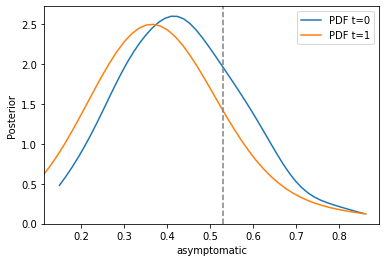

In [29]:
fig, ax = plt.subplots()

for t in range(history.max_t + 1):
    df, w = history.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(df, w,x="asymptomatic", ax=ax,label="PDF t={}".format(t))
#ax.axvline(y_observed, color="k", linestyle="dashed");
ax.axvline(x=0.53, color="grey", linestyle="dashed");
ax.legend()

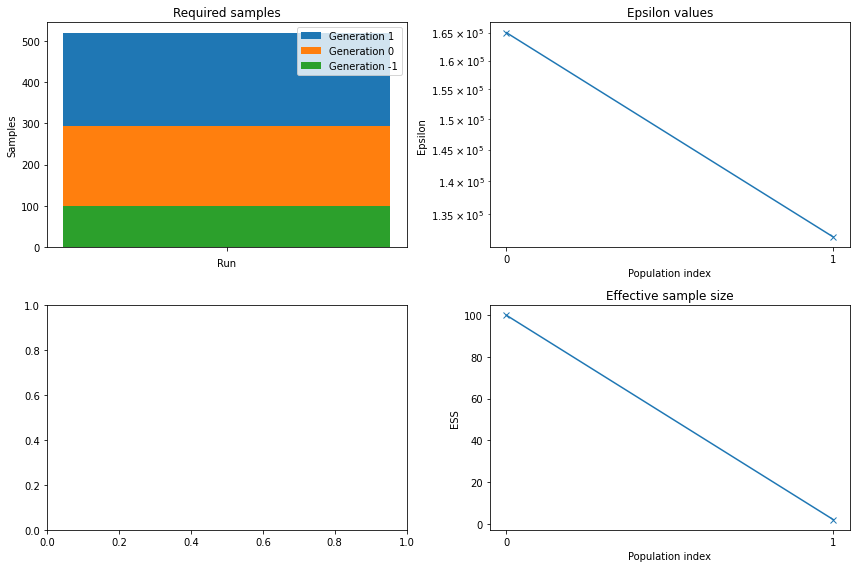

In [30]:
_, arr_ax = plt.subplots(2, 2)

pyabc.visualization.plot_sample_numbers(history, ax=arr_ax[0][0])
pyabc.visualization.plot_epsilons(history, ax=arr_ax[0][1])
#pyabc.visualization.plot_credible_intervals(
#    history, levels=[0.95, 0.9, 0.5], ts=[0, 1, 2, 3, 4],
#    show_mean=True, show_kde_max_1d=True,
#    refval={'mean': 2.5},
#    arr_ax=arr_ax[1][0])
pyabc.visualization.plot_effective_sample_sizes(history, ax=arr_ax[1][1])

plt.gcf().set_size_inches((12, 8))
plt.gcf().tight_layout()

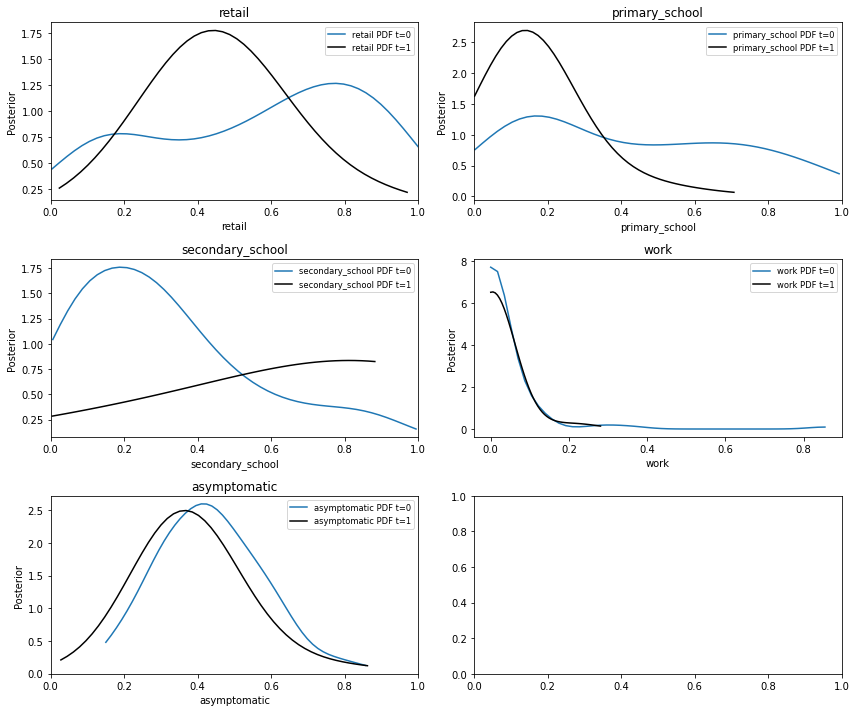

In [32]:
fig, axes = plt.subplots(3,int(len(priors)/2), figsize=(12,10))

#cmap = { 0:'k',1:'b',2:'y',3:'g',4:'r' }  # Do this automatically for len(params)

for i, param in enumerate(priors.keys()):
    ax = axes.flat[i]
    for t in range(history.max_t + 1):
        df, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(df, w, x=param, ax=ax,
                                        label=f"{param} PDF t={t}",
                                        alpha=1.0 if t==0 else float(t)/history.max_t, # Make earlier populations transparent
                                        color= "black" if t==history.max_t else None # Make the last one black
                                        )
        if param!="work":
            ax.set_xlim(0,1)
        ax.legend(fontsize="small")
        #ax.axvline(x=posterior_df.loc[1,param], color="grey", linestyle="dashed")
        #ax.set_title(f"{param}: {posterior_df.loc[0,param]}")
        ax.set_title(f"{param}")
fig.tight_layout()

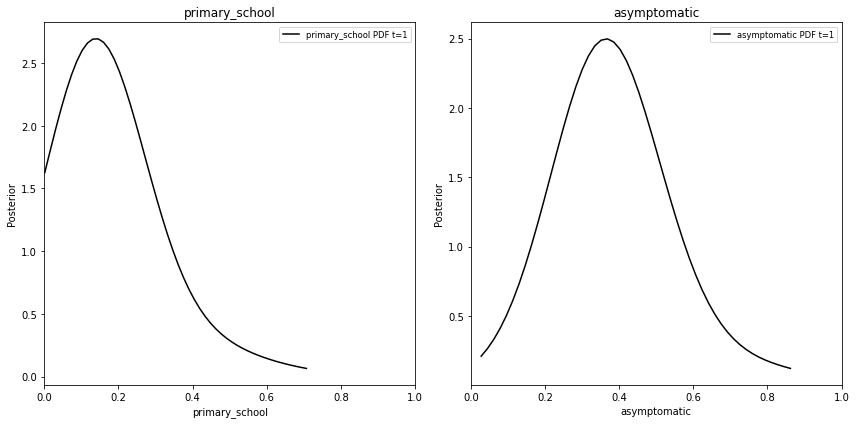

In [33]:
# As above but only show two parameters (for a Turing presentation)
fig, axes = plt.subplots(1,2, figsize=(12,6))

#cmap = { 0:'k',1:'b',2:'y',3:'g',4:'r' }  # Do this automatically for len(params)

for i, param in enumerate(['primary_school', 'asymptomatic']):
    ax = axes.flat[i]
    t = history.max_t
    df, w = history.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(df, w, x=param, ax=ax,
                                    label=f"{param} PDF t={t}",
                                    alpha=1.0 if t==0 else float(t)/history.max_t, # Make earlier populations transparent
                                    color= "black" if t==history.max_t else None # Make the last one black
                                    )
    if param!="work":
        ax.set_xlim(0,1)
    ax.legend(fontsize="small")
    ax.set_title(f"{param}")
fig.tight_layout()

In [35]:
fig, axes = plt.subplots(3,int(history.max_t/2), figsize=(10,8))
for t in range(history.max_t + 1):
   ax = axes.flat[t]
   for i, param in enumerate(priors.keys()):
       df, w = history.get_distribution(m=0, t=t)
       pyabc.visualization.plot_kde_1d(df, w, x=param, ax=ax,
           label=f"{param}")
   ax.legend()
   ax.set_title(f"t={t}")
fig.tight_layout()

ValueError: Number of columns must be a positive integer, not 0

<Figure size 720x576 with 0 Axes>

array([[<AxesSubplot:ylabel='asymptomatic'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='primary_school'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='retail'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='secondary_school'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='asymptomatic', ylabel='work'>,
        <AxesSubplot:xlabel='primary_school'>,
        <AxesSubplot:xlabel='retail'>,
        <AxesSubplot:xlabel='secondary_school'>,
        <AxesSubplot:xlabel='work'>]], dtype=object)

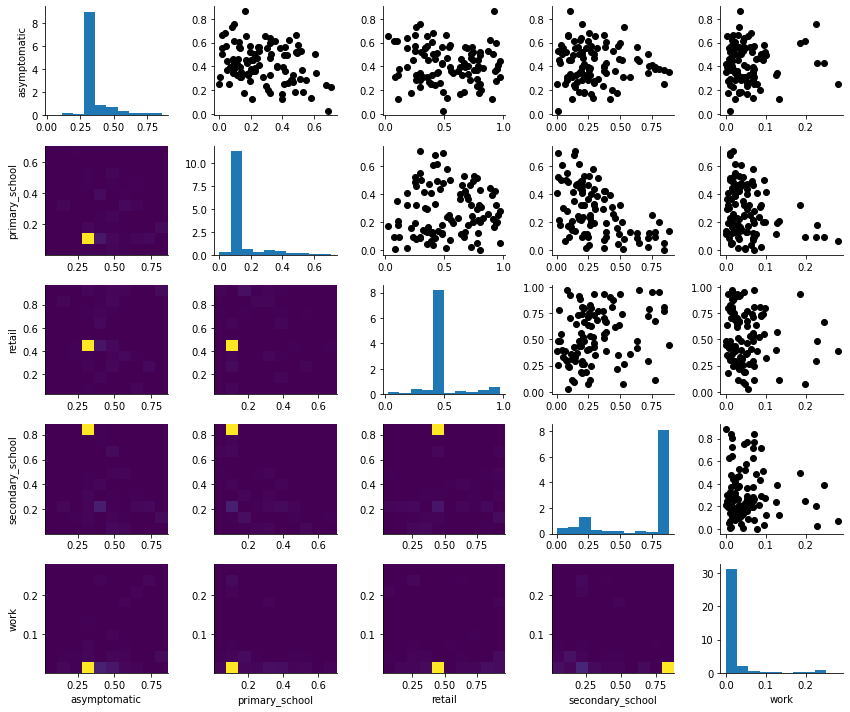

In [36]:
pyabc.visualization.plot_histogram_matrix(history, size=(12,10))

# Posterior

In [37]:
_df, _w = history.get_distribution(m=0, t=history.max_t)
# Merge dataframe and weights and sort by weight (highest weight at the top)
_df['weight'] = _w
posterior_df = _df.sort_values('weight', ascending=False).reset_index()
posterior_df

name,id,asymptomatic,primary_school,retail,secondary_school,work,weight
0,154,0.354890,0.135350,0.442683,0.881905,0.000065,0.709242
1,146,0.423208,0.114967,0.481910,0.213533,0.000608,0.035189
2,189,0.861848,0.166146,0.923077,0.107042,0.035023,0.018569
3,134,0.756646,0.093122,0.290216,0.199994,0.225888,0.014021
4,141,0.178465,0.321403,0.794078,0.213163,0.006271,0.010874
...,...,...,...,...,...,...,...
95,132,0.682720,0.037968,0.406751,0.251777,0.063515,0.000604
96,176,0.121807,0.205839,0.109668,0.124842,0.132074,0.000603
97,192,0.522242,0.488543,0.743057,0.197047,0.064755,0.000589
98,110,0.636228,0.323150,0.183835,0.188873,0.044458,0.000558


In [38]:
N_samples = 50
df, w = history.get_distribution(m=0, t=history.max_t)

# Sample from the dataframe of posteriors using KDE
kde = MultivariateNormalTransition(scaling=1)
kde.fit(df, w)
samples = kde.rvs(N_samples)

## Instead sample just using the weights (this isn't the best way to do it though, should use KDE)
#df = df.reset_index()  # So that the row index is 0-N (currently it's something else)
#sample_idx = np.random.choice(
#            a=range(history.get_nr_particles_per_population().values[-1]),
#            size=N_samples, replace=True, p=w)
#samples = df.iloc[sample_idx]

# Now run N models and store the results of each one
fitness_l = []  # Fitness values for each sample (model)
sim_l = []  # The full simulation results
obs_l = []  # Observations (should be the same for each sample)
out_params_l = []  # The parameters objects used in each sample (all parameters in the model)
out_calibrated_params_l = []  # The values of the specific calibrated parameters for the sample
summaries_l = []  # The summaries objects

negative_count = 0  # Count the number of negatives returned in the KDE posterior
for i, sample in samples.iterrows():

    # Check for negatives. If needed, resample
    while (sample < 0).values.any():
        print("Found negatives. Resampling")
        negative_count += 1
        sample = kde.rvs()

    # Create a dictionary with the parameters and their values for this sample
    param_values = { param:sample[str(param)] for param in priors}

    # Run the model
    (_fitness, _sim, _obs, _out_params, _summaries) = \
          OpenCLRunner.run_aspics_with_params_abc(param_values, return_full_details=True)
    print(f"Fitness: {_fitness}.")
    #print(f"Fitness: {_fitness}. Sample: {sample}")

    fitness_l.append(_fitness)
    sim_l.append(_sim)
    obs_l.append(_obs)
    out_params_l.append(_out_params)
    out_calibrated_params_l.append(param_values)
    summaries_l.append(_summaries)

print(f"Finished sampling. Ignored {negative_count} negative samples.")

# Sanity check
for i in range(len(obs_l)-1):
    assert np.array_equal(obs_l[0], obs_l[i])


# Save these because it took ages to sample
def pickle_samples(mode, *arrays):
    if mode=="save":
        with open("abc-2-samples.pkl", "wb") as f:
            for x in arrays:
                pickle.dump(x, f)
        return
    elif mode=="load":
        with open("abc-2-samples.pkl", "rb") as f:
            fitness_l = pickle.load(f)
            sim_l = pickle.load(f)
            obs_l = pickle.load(f)
            out_params_l = pickle.load(f)
            out_calibrated_params_l = pickle.load(f)
            summaries_l = pickle.load(f)
        return( fitness_l, sim_l, obs_l, out_params_l, out_calibrated_params_l, summaries_l)
    else:
        raise Exception(f"Unkonwn mode: {mode}")

pickle_samples('save', fitness_l, sim_l, obs_l, out_params_l, out_calibrated_params_l, summaries_l)

Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/10 [00:00<?, ?it/s]

Running a simulation  {64890}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809


/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running simulation 64891.


Running models:  10%|█         | 1/10 [00:05<00:48,  5.42s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {38804}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 38805.


Running models:  20%|██        | 2/10 [00:10<00:44,  5.51s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {96055}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 96056.


Running models:  30%|███       | 3/10 [00:16<00:37,  5.40s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {39214}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 39215.


Running models:  40%|████      | 4/10 [00:21<00:32,  5.35s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {24576}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 24577.


Running models:  50%|█████     | 5/10 [00:27<00:27,  5.43s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {60637}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 60638.


Running models:  60%|██████    | 6/10 [00:32<00:21,  5.32s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {97883}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 97884.


Running models:  70%|███████   | 7/10 [00:37<00:15,  5.27s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {74800}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 74801.


Running models:  80%|████████  | 8/10 [00:42<00:10,  5.25s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {91599}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 91600.


Running models:  90%|█████████ | 9/10 [00:47<00:05,  5.16s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {24175}  based on the study area
Loading snapshot from data/snapshots/Manchester/cache.npz
Snapshot is 42 MB
testing obesity arrays not equal
0.4180040572523386
0.3205060295277809
Running simulation 24176.


Running models: 100%|██████████| 10/10 [00:52<00:00,  5.26s/it]

.. finished, took 52.63s)
Ran Model with {'retail': 0.5396972116235904, 'primary_school': 0.1314136940524145, 'secondary_school': 0.9551823953503065, 'work': 0.0009867196463899377, 'asymptomatic': 0.3427302774620543}
Fitness: 87661.6564349545.
Found negatives. Resampling


TypeError: '<' not supported between instances of 'Parameter' and 'int'